# `Process Data`

In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

import transit
import emcee
import corner

import astroML 
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=True)

import astropy
from astropy import constants as const
from astropy import units as u
from astropy.modeling import models, fitting
from astropy.io import fits
from astropy.table import Table

from scipy import stats
import scipy.optimize as op
import scipy.signal as sig
from scipy.signal import argrelextrema, medfilt
from random import uniform, randrange

import kplr
from kplr.ld import get_quad_coeffs

import time
from collections import Counter, defaultdict, OrderedDict

import glob, os
import itertools

In [2]:
rcParams['figure.figsize'] = 16, 7
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [3]:
pgf_with_latex = {
    "pgf.texsystem": "xelatex",         # use Xelatex which is TTF font aware
    "text.usetex": True,                # use LaTeX to write all text
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "text.latex.unicode": True,
    "pgf.preamble": [
        r'\usepackage{fontspec}',
        r'\setmainfont{Ubuntu}',
        r'\setmonofont{Ubuntu Mono}',
        r'\usepackage{unicode-math}'
        r'\setmathfont{Ubuntu}'
        r'\usepackage{amsmath}' #for \text command
    ]
}

rcParams.update(pgf_with_latex)

# Introduction

## Load the data

In [4]:
path_file = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/clean_bat_files/LC_p13point5up/'
path_mergedLC = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/merge_light_curves/LC_p13point5up_merged/'

properties_sample = pd.read_csv(path_file+'all_targets_P13point5up.csv', sep=',', comment='#')
targets = pd.read_csv(path_file + 'kepler_id.txt',delimiter=',', dtype=int, header=None, names=['kepid'])

In [5]:
df = pd.merge(targets, properties_sample, on=['kepid'], how='inner') 
sc_data = df.drop_duplicates('kepid') #remove duplicates (some systems have both sc and lc LC)

print("Check files:")

if (len(targets) != len(properties_sample)):
    print("*Lengths don't match:", len(targets), len(properties_sample))
    print("\tSome systems have both sc and lc data! Remove duplicates.")

if (len(sc_data) == len(targets)):
    print("*Lengths match:", len(sc_data), len(targets))
    print('\tDuplicates have been removed.\n A total of {} systems have *short-cadence* LC with SN > 7.1 for their first transit and only 1 planet'.format(len(sc_data)))
    
sc_data.shape

Check files:
*Lengths don't match: 56 429
	Some systems have both sc and lc data! Remove duplicates.
*Lengths match: 56 56
	Duplicates have been removed.
 A total of 56 systems have *short-cadence* LC with SN > 7.1 for their first transit and only 1 planet


(56, 141)

## Define the Systems

In [6]:
class System:    
    def __init__(self, kepid, rs, rs_err, smass, smass_err, teff, logg, feh, srho,
                time_BKJD, flux, flux_err, 
                t0, P, depth, b, duration, u1, u2, diffld, num_planets, incl, eccen, dor, sma,
                 transit_times,ind_missed_transits,
                rp, rp_err, teq, mp, 
                 trans_id, ftrans, ftrans_err, ttrans,dt_trans,
                res_transfit, P_distribution, MCMC_transits):
        
        """****** Kepler Reported Stellar Parameters ******"""
        self.kepid = kepid
        self.rs = rs # [Solar radii]. 
        self.rs_err = rs_err
        self.smass = smass # [Solar mass]
        self.smass_err = smass_err
        
        self.teff = teff;     
        self.logg = logg; # Stellar Surface Gravity [log10(cm/s**2)]  
        self.feh = feh;   
        self.srho = srho; #g/cm3
        
        """****** LC parameters ******"""
        self.time_BKJD = time_BKJD
        self.flux = flux
        self.flux_err = flux_err
        
        """****** Transit Parameters ******"""
        self.t0 = t0
        self.P = P;            
        self.depth = depth;  
        self.b = b; 
        self.duration = duration; 
        self.u1 = u1; 
        self.u2 = u2
        self.diffld = 0.0
        self.num_planets = num_planets
        self.incl = incl #[º]
        self.eccen = 0.0
        self.dor = dor #Planet-Star Distance over Star Radius
        self.sma = sma #Orbital semi-major axis [AU]
        
        self.transit_times = transit_times
        self.ind_missed_transits = ind_missed_transits
        #self.depth = rprs ** 2 
            # Transit depth in absolute terms. To 1st order (assuming stellar disk has uniform brightness and 
            # neglecting any flux coming from planet), the ratio X of the observed change in flux, Delta(F), 
            # to that of the stellar flux F is: X = (Rp/Rs)^2 = depth.
                   
        """****** Planetary Parameters ******"""
        self.rp = rp # [Earth radii]. This is "prad"  in the original file
        self.rp_err = rp_err
        self.teq = teq
        self.mp = 2.69*(rp)**(0.93) #Weiss & Marcy rel'n. It requires Rp in Earth radii
        
        """****** Internal Variables ******"""
        self.trans_id = np.empty(0)
        self.ftrans = np.empty(0)
        self.ftrans_err = np.empty(0)
        self.ttrans = np.empty(0)
        self.dt_trans = np.empty(0)
        self.res_transfit = np.empty(0)
        self.P_distribution = np.empty(0)
        self.MCMC_transits = np.empty(0)

## Characterize the Systems

Some initialization functions: `quadraticLD`calculates the quadratic LD coefficients of a star based on the model from Claret & Bloemen (2011). As for `fetchLC`, it simply loads the systems' light curves.

In [7]:
bjd_ref = 2454833

def quadraticLD(T, G, FEH): 
    """Confirm the quadratic LD coefficients with a model from Claret & Bloemen (2011).
    Use the Claret coefficients instead."""
    mu1, mu2 = get_quad_coeffs(T, G, FEH)
    return (mu1, mu2)

def fetchLC(name):
    id_kep = "%.0f" % name
    lc = path_mergedLC+('KID'+id_kep+'.txt')
    df = pd.read_csv(lc, sep="\t", skiprows=1, header=None, names=["Time BKJD", "Flux", "Flux_Err"])
    y = df['Flux']
    yerr = df['Flux_Err']
    x = df['Time BKJD']
    #print(np.median(y),np.mean(y),np.std(y))
    return (y, yerr, x)

Create the planet+star system. In this research, we will only evaluate systems with only 1 planet. 

In [8]:
targets = []

for row in sc_data.itertuples(index = True, name='Pandas'):
    kepid = getattr(row, "kepid")
    fluxLC, fluxLC_err, timeLC_BKJD = fetchLC(kepid)

    ## Store the stellar parameters
    rs = getattr(row, "koi_srad") #solar radii
    smass = getattr(row, "koi_smass")
    #Assuming that we have a 5% error on radius and mass (this is sensible thanks to Gaia)
    rs_err = rs*0.05
    smass_err = smass*0.05
    
    #rs_errPos = getattr(row, "koi_srad_err1"); rs_errNeg = getattr(row, "koi_srad_err2")
    #rs_err = np.abs((rs_errPos+rs_errNeg)/2.)
    
    #smass_errPos = getattr(row, "koi_smass_err1"); smass_errNeg = getattr(row, "koi_smass_err2")
    #smass_err = np.abs((smass_errPos+smass_errNeg)/2.)
    
    teff = getattr(row, "koi_steff")
    logg = getattr(row, "koi_slogg") # Stellar Surface Gravity [log10(cm/s**2)]  
    feh = getattr(row, "koi_smet")
    srho = getattr(row, "koi_srho") #g/cm3
    
    #### Store LC Parameters
    t0 = getattr(row, "koi_time0bk")
    P = getattr(row, "koi_period") # Orbital Period [days]
    depth = getattr(row, "koi_depth")/1e6
    b = getattr(row, "koi_impact")
    
    u1, u2 = quadraticLD(teff,logg,feh)

    num_planets = getattr(row, "koi_count")
    incl =  getattr(row, "koi_incl") #in degrees
    dor = getattr(row, "koi_dor")  #Planet-Star Distance over Star Radius
    
    time0bk = getattr(row, "koi_time0bk")
    duration = getattr(row, "koi_duration")/24. #in days. "Duration is measured from first contact between the planet and star until last contact."
    
    #Planetary parameters
    sma = getattr(row, "koi_sma")  #Orbit Semi-Major Axis [AU]
    sma_solarRad = sma*215
    teq = getattr(row, "koi_teq") 
    rp = getattr(row, "koi_prad") # in Earth radii
    rp_solarRad = getattr(row, "koi_prad")*0.009168 # in solar radii
    rp_errPos = getattr(row, "koi_prad_err1"); rp_errNeg = getattr(row, "koi_prad_err2")
    rp_err = np.sqrt(rp_errPos**2+rp_errNeg**2)
        
    if (num_planets == 1):
        system = System(kepid, rs, rs_err, smass, smass_err, teff, logg, feh, srho,
                    timeLC_BKJD, fluxLC, fluxLC_err, 
                    t0, P, depth, b, duration, u1, u2, u1-u2, num_planets, incl, 0.0, dor, sma,
                        None, None,
                    rp, rp_err, teq, None, 
                        None, None, None, None, None,
                       None, None, None)

        targets.append(system)
                
    else:
        print('Star {:s} not stored (koi_count > 1)'.format(str(kepid)))

# Global Parameters

MCMC Global Initialization Parameters

In [9]:
sc = 58.0  #sc = 58 sec
tKep = sc/60/60/24  # sc in days
G = 6.6730e-11

In [10]:
steps, nwalkers = 1000, 100
steps_rho, nwalkers_rho = 1000, 100

id_mcmc = ["Depth:", "Impact parameter (b):", "sigma:", "Stellar Mass (Ms, [Solar mass]):",
           "Stellar Radius (Rs, [Solar Radii]):", "Out-of-transit flux (f0):", "Orbital Period (P, [days]):", 
           "Time of transit (tc, [days]):", "Planetary Radius (Rp, [Rearth]):", "Rs_a:"]

header_mcmc = "This file shows the 50% percentile and the +- 1 sigma error interval of the parameters.\n"

header_rs = "This file shows the 50% percentile for the Stellar Radius (in solar radii), \
its +- 1 sigma error interval, and the MCMC acceptance fraction (in %). Note that these results \
are for the star's *observed* transits with a minimum SNR of 3.0. \n"

# Transit Detection

In [11]:
def find_transits(star):
    ti = min(star.time_BKJD)
    tf = max(star.time_BKJD)
    
    n_min = int((ti-star.t0)/star.P)
    n_max = int((tf-star.t0)/star.P+1.)
    n = np.arange(n_min, n_max)
    
    t = star.t0+n*star.P
    t = t[t>ti] 
    t = t[t<tf]
    return(t)

In [12]:
def show_folded_lightcurve(star, plot=False):
    if plot==True:
        plt.figure(figsize=(15,6))
        plt.plot(star.dt_trans,star.ftrans,'.')     
        plt.title('Folded LC for KID'+str(star.kepid))
        plt.xlabel('Time BKJD [d]'); plt.ylabel('Normalized Flux')
        plt.show(block=False)    
        time.sleep(0.2)
        plt.close()

def mark_transits(star, obs_trans, plot=False):
    if plot==True:
        plt.figure(figsize=(15,6))
        plt.plot(star.time_BKJD,star.flux,'.')        
        for j in range(len(star.transit_times)): 
            plt.axvline(star.transit_times[j], color='k', ls='-')
        for k in range(len(obs_trans)): 
            plt.axvline(obs_trans[k], color='r', ls='--')
        plt.title('KID'+str(star.kepid))
        plt.xlabel('Time BKJD [d]'); plt.ylabel('Normalized Flux')
        plt.show(block=False)    
        time.sleep(0.2)
        plt.close()
        
def show_transits(star, bad_trans, plot=False):        
    s1 = set(bad_trans)
    if plot==True:   
        for i in range(len(star.transit_times)):
            if (i not in bad_trans):
                plt.figure(figsize=(15,6))
                plt.title('Folded Light Curve for Transit '+str(i+1))
                plt.plot(star.ttrans[star.trans_id==i]-star.transit_times[i],star.ftrans[star.trans_id==i], 'k.')     
                plt.xlabel('Time [d]'); plt.ylabel('Normalized Flux')
                plt.show(block=False)    
                time.sleep(0.2)
                plt.close()

In [13]:
def get_data_in_transit(star, factor):
    window = factor*star.duration # In days
    total_points = 0
    
    for i in range(0,len(star.transit_times)):
        residual = star.time_BKJD - star.transit_times[i]
        points_in_transit = np.abs(residual) <= window
        total_points += np.sum(points_in_transit)

    time_in_transit = np.empty(total_points)
    flux_in_transit = np.empty(total_points)
    flux_err_in_transit = np.empty(total_points)
    flag_transit = np.empty(total_points)
    mid_trans = np.empty(total_points)

    total_points = 0

    for i in range(0, len(star.transit_times)):
        points_in_transit = np.abs(star.time_BKJD - star.transit_times[i]) <= window
        count_points = np.sum(points_in_transit)
        time_in_transit[(0 + total_points):(count_points + total_points)] = star.time_BKJD[points_in_transit]
        flux_in_transit[(0 + total_points):(count_points + total_points)] = star.flux[points_in_transit] #, star.flux_err[points_in_transit])[0]
        flux_err_in_transit[(0 + total_points):(count_points + total_points)] = star.flux_err[points_in_transit] #normalize(star.flux[points_in_transit], 
        flag_transit[(0 + total_points):(count_points + total_points)] = i
        mid_trans[(0 + total_points):(count_points + total_points)] = star.transit_times[i] 
        total_points += count_points
        
    star.trans_id = flag_transit
    star.ttrans = time_in_transit
    star.ftrans = flux_in_transit
    star.ftrans_err = flux_err_in_transit
    star.dt_trans = time_in_transit - mid_trans #if interested in the folded LC, plot target.dt_trans vs target.ftrans

In [14]:
def oot_fit(star, polyorder):
    transit_range = star.duration/2 #in days
    for i in range(0, len(star.transit_times)):
        
        dt = star.ttrans[star.trans_id == i] - star.transit_times[i]
        y = star.ftrans[star.trans_id==i]
        
        outside_trans = np.abs(dt) >= transit_range
        inside_trans = np.abs(dt) < transit_range
        num_oot_points = len(dt[outside_trans])
        
        if  (num_oot_points!= 0):
            z = np.polyfit(dt[outside_trans], y[outside_trans], polyorder)
            p = np.poly1d(z)
            y = y/p(dt)

In [15]:
def find_missed_transits(star):
    gaps = []
    for i in range(len(star.transit_times)):
        if len(star.ttrans[star.trans_id==i])==0: 
            gaps.append(i)
    missing_transits = sorted(gaps, reverse=True)
    return(missing_transits)

In [16]:
def export_folded_lc(system):
    lc = pd.DataFrame(OrderedDict({'Time': system.time_BKJD, 'Flux': system.flux, 'Flux_Err': system.flux_err}))
     
    np.savetxt("/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/folded_LC/"+str(system.kepid)+".txt", 
               lc.values, fmt='%f', delimiter="\t") 

The code below performs two functions: 
    1. It identifies the light curves that don't have a visible transit. (With the data being used as of June 30, this amounts to 4 systems).
    2. For the remaining light curves, it calculates all the expected transits and then looks at which transits are actually visible (sometimes, there are gaps in the data and transits are lost). 

In [17]:
stars_wo_transits = []
poly_order = 2
amplify = 2
print("Amplification of transit duration by:", amplify)

Amplification of transit duration by: 2


In [18]:
for target in targets:
    print("\n******************************** KID"+str(target.kepid)+" ********************************\n")

    target.transit_times = find_transits(target)
    get_data_in_transit(target, amplify)
    oot_fit(target, poly_order)
    
    if (len(target.transit_times)==0): stars_wo_transits.append(target.kepid)

    target.ind_missed_transits = find_missed_transits(target)
    observed_transits = np.delete(target.transit_times, target.ind_missed_transits)
    mark_transits(target, observed_transits, False)
    show_transits(target, target.ind_missed_transits, False)

    if len(observed_transits!=0): 
        show_folded_lightcurve(target, False)
        
    #export_folded_lc(target)
    print("Transit duration: {0:0.5} [d]".format(target.duration))
    print("Period: {0:s} [d]".format(str(target.P)))
    print("Estimated transits at ({0:s}):".format(str(len(target.transit_times))), target.transit_times)
    print("Observed transits at ({0:s}):".format(str(len(observed_transits))), observed_transits)
    print("Index of missed transits:", target.ind_missed_transits)


******************************** KID5009743 ********************************

Transit duration: 0.2377 [d]
Period: 41.6980186 [d]
Estimated transits at (1): [878.4417962]
Observed transits at (1): [878.4417962]
Index of missed transits: []

******************************** KID8802165 ********************************

Transit duration: 0.20822 [d]
Period: 17.42115972 [d]
Estimated transits at (2): [759.14417676 776.56533648]
Observed transits at (2): [759.14417676 776.56533648]
Index of missed transits: []

******************************** KID6471021 ********************************

Transit duration: 0.3795 [d]
Period: 125.6291479 [d]
Estimated transits at (9): [ 504.6090858  630.2382337  755.8673816  881.4965295 1007.1256774
 1132.7548253 1258.3839732 1384.0131211 1509.642269 ]
Observed transits at (4): [ 630.2382337 1258.3839732 1384.0131211 1509.642269 ]
Index of missed transits: [5, 4, 3, 2, 0]

******************************** KID11133306 ********************************

Transit

Transit duration: 0.16541 [d]
Period: 16.23847733 [d]
Estimated transits at (86): [ 203.49651866  219.73499599  235.97347332  252.21195065  268.45042798
  284.68890531  300.92738264  317.16585997  333.4043373   349.64281463
  365.88129196  382.11976929  398.35824662  414.59672395  430.83520128
  447.07367861  463.31215594  479.55063327  495.7891106   512.02758793
  528.26606526  544.50454259  560.74301992  576.98149725  593.21997458
  609.45845191  625.69692924  641.93540657  658.1738839   674.41236123
  690.65083856  706.88931589  723.12779322  739.36627055  755.60474788
  771.84322521  788.08170254  804.32017987  820.5586572   836.79713453
  853.03561186  869.27408919  885.51256652  901.75104385  917.98952118
  934.22799851  950.46647584  966.70495317  982.9434305   999.18190783
 1015.42038516 1031.65886249 1047.89733982 1064.13581715 1080.37429448
 1096.61277181 1112.85124914 1129.08972647 1145.3282038  1161.56668113
 1177.80515846 1194.04363579 1210.28211312 1226.52059045 1242.7590

Transit duration: 0.33696 [d]
Period: 19.55662003 [d]
Estimated transits at (54): [ 541.06270054  560.61932057  580.1759406   599.73256063  619.28918066
  638.84580069  658.40242072  677.95904075  697.51566078  717.07228081
  736.62890084  756.18552087  775.7421409   795.29876093  814.85538096
  834.41200099  853.96862102  873.52524105  893.08186108  912.63848111
  932.19510114  951.75172117  971.3083412   990.86496123 1010.42158126
 1029.97820129 1049.53482132 1069.09144135 1088.64806138 1108.20468141
 1127.76130144 1147.31792147 1166.8745415  1186.43116153 1205.98778156
 1225.54440159 1245.10102162 1264.65764165 1284.21426168 1303.77088171
 1323.32750174 1342.88412177 1362.4407418  1381.99736183 1401.55398186
 1421.11060189 1440.66722192 1460.22384195 1479.78046198 1499.33708201
 1518.89370204 1538.45032207 1558.0069421  1577.56356213]
Observed transits at (52): [ 541.06270054  560.61932057  580.1759406   599.73256063  619.28918066
  638.84580069  658.40242072  677.95904075  697.5156

Transit duration: 0.1955 [d]
Period: 14.00640392 [d]
Estimated transits at (31): [268.26648528 282.2728892  296.27929312 310.28569704 324.29210096
 338.29850488 352.3049088  366.31131272 380.31771664 394.32412056
 408.33052448 422.3369284  436.34333232 450.34973624 464.35614016
 478.36254408 492.368948   506.37535192 520.38175584 534.38815976
 548.39456368 562.4009676  576.40737152 590.41377544 604.42017936
 618.42658328 632.4329872  646.43939112 660.44579504 674.45219896
 688.45860288]
Observed transits at (24): [268.26648528 282.2728892  296.27929312 310.28569704 324.29210096
 338.29850488 352.3049088  366.31131272 380.31771664 394.32412056
 408.33052448 422.3369284  436.34333232 506.37535192 520.38175584
 534.38815976 548.39456368 562.4009676  576.40737152 590.41377544
 604.42017936 618.42658328 674.45219896 688.45860288]
Index of missed transits: [28, 27, 26, 16, 15, 14, 13]

******************************** KID8866102 ********************************

Transit duration: 0.18797 [d]

In [19]:
print("There are {:s} stars without transits. These targets won't be studied".format(str(len(stars_wo_transits))))

print(stars_wo_transits)

There are 4 stars without transits. These targets won't be studied
[10795103, 7761545, 11622600, 11027624]


# Fit of the Stellar Density

## Transit Routine (DFM)

A Python library for generating light curves of transiting planets. See https://github.com/dfm/transit/blob/master/transit/transit.py for original code

In [ ]:
def lnprior_rho(theta, maxb):
    pdepth, pb, sigma, pradius, f0, ptc = theta 
    if ((0 <= pb < maxb) and (0 <= sigma) and (pradius > 0) and (pdepth > 0) and (ptc**2<0.01)):
        return 0.0
    return -np.inf  

def lnlike_rho(theta, timeLC, fluxLC, errorLC, allfixed):
    ecc,  mass, masserr, tKep, u1, u2, maxb, P = allfixed
    pdepth, pb, sigma, pradius, f0, ptc = theta 
    
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass = mass, radius = pradius))
    body = transit.Body(radius=np.sqrt(pdepth)*pradius, period=P, t0=ptc, b=np.abs(pb), e=ecc)
    s.add_body(body)
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    try: 
        ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)
    except ValueError:
        return -np.inf
    ftheo = ftheo-1+f0
    chi2 = -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)))
    return chi2
                 
def lnprob_rho(theta, timeLC, fluxLC, errorLC, allfixed):
    ecc, mass, masserr, tKep, u1, u2, maxb, P = allfixed
    lp_rho = lnprior_rho(theta, maxb)
    if not np.isfinite(lp_rho):
        return -np.inf
    return lp_rho + lnlike_rho(theta, timeLC, fluxLC, errorLC, allfixed)

## MCMC

In [ ]:
def fit_rho(star, t, f, ferr, num_trans, showLC, showMCMC):
    max_b = 1+star.rp/star.rs
    
    allfixed_rho = np.array([star.eccen, star.smass, 0.0, tKep, star.u1, star.u2, max_b, star.P])
    first_guess =  np.array([1.2*star.depth, star.b, 0.0, star.rs, 1.0, 0.0])
    
    nll_rho = lambda *args: -lnprob_rho(*args)
       
    result = op.minimize(nll_rho, first_guess, args=(t, f, ferr, allfixed_rho), 
                       options={'disp': True},
                       method='Nelder-Mead') 
    
    depth_ml, b_ml, sigma_ml, radius_ml, f0_ml, tc_ml = result["x"]
        
    # Compute the theoretical light curve integrated over a Kepler short-cadence exposure time.
    s = transit.System(transit.Central(mu1=star.u1, mu2=star.u2, mass=star.smass, radius=radius_ml))
    body = transit.Body(radius=np.sqrt(depth_ml)*radius_ml,period=star.P, t0=tc_ml,b=np.abs(b_ml),e=star.eccen)
    s.add_body(body)
    t_fit = np.arange(-1, 1, tKep*0.01)
    f_fit = s.light_curve(t_fit, texp=tKep, tol=1e-08, maxdepth=4)
    f_fit = f_fit - 1.0 + f0_ml
    
    if showLC == True:
        fig = plt.figure(figsize=(16,7))
        plt.title(str(star.kepid)+'. Stellar Density Fit for Transit '+str(num_trans+1), fontsize = 15)
        plt.plot(t, f, '.')
        plt.plot(t_fit, f_fit, color='r', lw = 3)
        plt.xlabel('Time from midtransit [days]')
        plt.ylabel('Normalized flux')
        plt.xlim([min(t),max(t)]) 
        plt.show(block=False)    
        time.sleep(0.2)
        plt.close()
        
    ndim_rho = len(result["x"])
    
    p0 = [result["x"]*(1+1e-8*np.random.randn(ndim_rho)) for i in range(nwalkers_rho)]
    sampler = emcee.EnsembleSampler(nwalkers_rho, ndim_rho, lnprob_rho, args=(t, f, ferr, allfixed_rho))
    
    print("Running burn-in")
    pos, prob, state = sampler.run_mcmc(p0, 200, progress=True);
    sampler.reset() # Reset the chain to remove the burn-in samples.
    print("\n------ Run MCMC -------")
    sampler.run_mcmc(p0, steps_rho, rstate0 = state, progress=True);
    samples = sampler.chain[:, int(steps_rho/10):, :].reshape((-1, ndim_rho)) #burnin currently set to 10%
    
    samples[:, 2] = np.exp(samples[:, 2])
    
    #Get the 50% percentile and the +- 1 sigma error of the parameters and 2 derived quantities 
    depth_mcmc, b_mcmc, sigma_mcmc, \
    rs_mcmc, f0_mcmc, tc_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                               zip(*np.percentile(samples, [15.86, 50, 84.14], axis=0)))
    
    if showMCMC == True:
        print("\n------ Post-MCMC Results ------")
        print("\nDepth:\n\tTrue = {:0.3f}".format(star.depth))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(depth_mcmc[0],depth_mcmc[1],depth_mcmc[2]))
        print("\nImpact parameter:\n\tTrue = {:0.3f}".format(star.b))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(b_mcmc[0],b_mcmc[1],b_mcmc[2]))
        print("\nStellar radius [Rsun]:\n\tREPORTED = {:0.3f}".format(star.rs))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(rs_mcmc[0], rs_mcmc[1],rs_mcmc[2]))
   
    #---------- Plot the LC with the MCMC fit ----------
    s = transit.System(transit.Central(mu1=star.u1, mu2=star.u2, mass=star.smass, radius=rs_mcmc[0]))
    body = transit.Body(radius=np.sqrt(depth_mcmc[0])*rs_mcmc[0], period=star.P, t0=tc_mcmc[0], 
                        b=np.abs(b_mcmc[0]), e=star.eccen)
    s.add_body(body)
    t_fit = np.arange(-1, 1, tKep*0.01)
    f_fit = s.light_curve(t_fit, texp=tKep, tol=1e-08, maxdepth=4)
    f_fit = f_fit - 1.0 + f0_mcmc[0]
    fig_lc = plt.figure(figsize=(15,4))
    plt.title('MCMC Fit for KID'+str(star.kepid))
    plt.plot(t, f, '.')
    plt.plot(t_fit, f_fit, 'r', lw = 3)
    plt.xlabel('Time [d]'); plt.ylabel('Normalized Flux')
    plt.xlim([min(t),max(t)])
    
    filepath_rho = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/new_rs/'
    store_lcfit = "fit"+str(star.kepid)+"_st"+str(steps_rho)+"_trans"+str(num_trans+1)+".png"
    fig_lc.savefig(filepath_rho+store_lcfit)
    plt.close(fig_lc)
        
    true_params = [star.depth, star.b, None, star.rs, 1.0, 0.0]
    res_labels = [r'Depth', r'$b$', r'$\sigma$', r'$R_{s} [R_{\odot}]$', r'$f_{0}$', r'$t_{c}$']
    
    fig_corner = corner.corner(samples, weights = None, labels = res_labels, quantiles=[0.16, 0.5, 0.84],
                               truths = true_params, show_titles = True, title_args={"fontsize": 12}, 
                               plot_contours=True, truth_color='r', plot_datapoints=True) 
        
    plt.suptitle("KID"+str(star.kepid)+". Corner Plot for Transit "+str(num_trans+1), fontsize = 20)
    store_corner = "corner"+str(star.kepid)+"_st"+str(steps_rho)+"_trans"+str(num_trans+1)+".png"
    fig_corner.savefig(filepath_rho+store_corner)
    plt.close(fig_corner)
   
    #Acceptance fraction: s a rule of thumb, the acceptance fraction (af) should be between 0.2 and 0.5. 
    #If af < 0.2 decrease the a parameter. If af > 0.5 increase the a parameter. 
    af = sampler.acceptance_fraction  
    af_percentage = 100*np.mean(sampler.acceptance_fraction)
    
    print("Mean acceptance fraction:", np.mean(af))
    print("Acceptance fraction: {0:.2f} %".format(af_percentage))
    
    #Steps plot
    fig_steps, axes = plt.subplots(ndim_rho, 1, sharex=True, figsize=(8, 9))
    axes[0].plot(sampler.chain[:, :, 0].T, ls='dotted', color = "xkcd:sky blue") #depth = 0
    axes[0].set_ylabel(r'Depth'); axes[0].axhline(true_params[0], color='red')
    axes[1].plot(sampler.chain[:, :, 1].T,'.', ls='dotted', color="xkcd:sky blue")
    axes[1].set_ylabel(r'$b$'); axes[1].axhline(true_params[1], color='red')
    axes[2].plot((sampler.chain[:, :, 2]).T, ls='dotted', color="xkcd:sky blue")
    axes[2].set_ylabel(r'$\sigma$');
    axes[3].plot((sampler.chain[:, :, 3]).T, ls='dotted', color="xkcd:sky blue")
    axes[3].set_ylabel(r'$R_{s} [R_{\odot}]$'); axes[3].axhline(true_params[3], color='red')
    axes[4].plot((sampler.chain[:, :, 4]).T, ls='dotted', color="xkcd:sky blue")
    axes[4].set_ylabel(r'$f_{0}$'); axes[4].axhline(true_params[4], color='red')
    axes[5].plot((sampler.chain[:, :, 5]).T, ls='dotted',color="xkcd:sky blue")
    axes[5].set_ylabel(r"$t_{c}$"); axes[5].axhline(true_params[5], color='red')
    axes[5].set_xlabel("Step number")
    fig_steps.tight_layout(h_pad=0.0)
    store_steps= "steps"+str(star.kepid)+"_st"+str(steps_rho)+"_trans"+str(num_trans+1)+".png"
    fig_steps.savefig(filepath_rho+store_steps)
    plt.close(fig_steps)
    
    results_mcmc = [depth_mcmc, b_mcmc, sigma_mcmc, rs_mcmc, f0_mcmc, tc_mcmc]
    rs_results = np.array([rs_mcmc[0],rs_mcmc[1],rs_mcmc[2]])
    
    return radius_ml, rs_results, af_percentage

Store the KID of stars with missing or bad (SNR < 3) transits 

In [ ]:
no_transits = set(stars_wo_transits)
ugly_stars = defaultdict(list)

for i in range(len(stars_wo_transits)):
    idx_target = stars_wo_transits[i]
    ugly_stars[idx_target] = []
    
print(ugly_stars)

Fit the stellar radius to obtain a better estimate of the stellar density

Update stellar radius.

# Fit of Individual Transits

## Transit Routine (DFM)

A Python library for generating light curves of transiting planets. See https://github.com/dfm/transit/blob/master/transit/transit.py for original code

In [ ]:
def ln_probtrans(P, rstar, mstar):
    alog = (1/3)*np.log(mstar)+(2/3)*np.log(P)
    prob = np.log(rstar)-alog
    return(prob)

In [ ]:
def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):
    """
    Calculates the log of the likelihood of the transit model being the right model given the following parameters:
    theta[0] = pdepth = (Rp/Rs)^2 #b=0 centre of stellar disk & b=1 at the cusp of the disc
    theta[1] = pb = the mean impact parameter, measured in stellar radii (not Solar radii). See documentation.
    theta[2] = sigma = an additional white noise term
    theta[3] = pmass = the mass of the star (controlled via gaussian prior)
    theta[4] = pradius = the radius of the star (controlled via gaussian prior)
    theta[5] = f0 = the out of eclipse flux
    theta[6] = pperiod = Orbital period 
    theta[7] = ptc = Transit time (time of conjunction) 
    
    Note: pmass and prad (stellar mass and radius) controlled via gaussian prior. 
    By letting M* and R* be free parameters in the model, we allow the stellar density to fluctuate. 
    """
    ecc, mass, masserr, radius, radiuserr, tKep, u1, u2, maxb = allfixed
    pdepth, pb, sigma, pmass, pradius, f0, pperiod, ptc = theta 
    
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass = pmass, radius = pradius))
    body = transit.Body(radius=np.sqrt(pdepth)*pradius, period=pperiod, t0=ptc, b=np.abs(pb), e=ecc)
    s.add_body(body)
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    
    try: 
        ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)
    except ValueError:
        return -np.inf
    
    ftheo = ftheo-1+f0
    
    return -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)) + ((pmass-mass)/masserr)**2
            + ((pradius-radius)/radiuserr)**2)

In [ ]:
def lnprior(theta, maxb):
    ##https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations
    pdepth, pb, sigma, pmass, pradius, f0, pperiod, ptc = theta
    if ((0 <= pb < maxb) and (0 <= sigma) and (pradius > 0) 
        and (pdepth > 0) and (pmass > 0.0) and (13.5 < pperiod)  and (ptc**2<0.01)):
        return ln_probtrans(pperiod, pradius, pmass)
    return -np.inf  

def lnprior_MCMC(theta, maxb): ##https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations
    pdepth, pb, sigma, pmass, pradius, f0, pperiod, ptc = theta
    if ((0 <= pb < maxb) and (0 <= sigma) and (pradius > 0) 
        and (pdepth > 0) and (pmass > 0.0) and (13.5 < pperiod)  and (ptc**2<0.01)):
        return ln_probtrans(pperiod, pradius, pmass) 
    return -np.inf    

In [ ]:
def lnprob(theta, timeLC, fluxLC, errorLC, allfixed):
    ecc, mass, masserr, radius, radiuserr, tKep, u1, u2, maxb = allfixed
    lp = lnprior(theta, maxb)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)

def lnprob_MCMC(theta, timeLC, fluxLC, errorLC, allfixed_MCMC):
    ecc, mass, masserr, radius, radiuserr, tKep, u1, u2, maxb = allfixed_MCMC
    lp_MCMC = lnprior_MCMC(theta, maxb)
    if not np.isfinite(lp_MCMC):
        return -np.inf
    return lp_MCMC + lnlike(theta, timeLC, fluxLC, errorLC, allfixed_MCMC)

In [ ]:
def run_transit_routine(star, t, f, ferr, transit_num, showLC):
    period_guess = 250 #randrange(14,500) #uniform(13.5, 500) print("Period guess [d]:", period_guess)
    depth_guess = 1-min(f)
    rp_guess = np.sqrt(depth_guess)*star.rs
    max_b = 1+rp_guess/star.rs  
    print("Max. depth (guess) = {0:0.5f}".format(max_b))
    print("Depth guess = {0:0.5f}. True depth = {1:0.5f}".format(depth_guess, star.depth))
    
    allfixed = np.array([star.eccen, star.smass, star.smass_err, star.rs, star.rs_err, tKep, star.u1, star.u2, max_b])
    
    #initial_simplex = np.tile(first_guess, (len(first_guess)+1,1))
    
    nll = lambda *args: -lnprob(*args)
    
    res0 = op.minimize(nll, [1.2*depth_guess, 0.5, 0.0, star.smass, star.rs, 1.0, period_guess, 0.0], 
                       args=(t, f, 0.0, allfixed), 
                       options={'maxiter':1e5, 'disp': True},
                       method='Nelder-Mead') #options={'maxiter': 1e3, 'disp': True}
    
    res1 = op.minimize(nll, res0["x"], 
                       args=(t, f, ferr, allfixed), 
                       options={'maxiter':1e5, 'disp': True},
                       method='Nelder-Mead')
    
    depth_ml, b_ml, sigma_ml, mass_ml, radius_ml, f0_ml, period_ml, tc_ml = res1["x"]
        
    # Compute the theoretical light curve integrated over a Kepler short-cadence exposure time.
    s = transit.System(transit.Central(mu1=star.u1, mu2=star.u2, mass=mass_ml, radius=radius_ml))
    body = transit.Body(radius=np.sqrt(depth_ml)*radius_ml,period=period_ml, t0=tc_ml,b=np.abs(b_ml),e=star.eccen)
    s.add_body(body)
    t_fit = np.arange(-1, 1, tKep*0.01)
    f_fit = s.light_curve(t_fit, texp=tKep, tol=1e-08, maxdepth=4)
    f_fit = f_fit - 1.0 + f0_ml
    
    if showLC == True:
        fig = plt.figure(figsize=(16,5))
        plt.title("KID"+str(star.kepid)+". Preliminary Fit for Transit "+str(transit_num+1), fontsize = 15)
        plt.plot(t, f, '.', label = 'Kepler data')
        plt.plot(t_fit, f_fit, color='r', lw = 3, label = 'Fit')
        plt.xlabel('Time from midtransit [days]')
        plt.ylabel('Normalized flux')
        plt.xlim([min(t),max(t)]) 
        plt.show(block=False)    
        time.sleep(0.5)
        plt.close()

    #star.duration = body.duration #from eq'n 14 in Winn (2010)
    print("------ Pre-MCMC Results ------")
    print("\tTransit duration [d]:\t Fit={0:0.3f}\tTrue={1:0.3f}".format(body.duration, star.duration))
    print("\tPeriod [days]:\t Fit={0:0.8f}\tTrue={1:0.8f}".format(period_ml,star.P))
    print("\tImpact Parameter:\t Fit={0:0.6f}\tTrue={1:0.6f}".format(b_ml,star.b))
    print("\tDepth:\t Fit={0:0.6f}\tTrue={1:0.6f}".format(depth_ml,star.depth))
    print("\tStellar mass:\t Fit={0:0.3f}\tTrue={1:0.3f}".format(mass_ml,star.smass))
    print("\tStellar radius:\t Fit={0:0.3f}\tTrue={1:0.3f}".format(radius_ml,star.rs))
    print("\tSigma (white noise):\t Fit={0:0.3f}".format(sigma_ml))
    print("\tOut-of-transit flux:\t Fit={0:0.3f}".format(f0_ml))
    
    return(res1["x"])

## MCMC 

In [ ]:
def run_mcmc(star, t, f, ferr, num_trans, fit_results, show_mcmc_res):
    
    depth_ml, b_ml, sigma_ml, mass_ml, radius_ml, f0_ml, period_ml, tc_ml = fit_results
    rp_guess = np.sqrt(depth_ml)*radius_ml
    max_depth = 1+rp_guess/radius_ml
    
    print("\n------------------ Prepare MCMC ------------------")
    print("Guess impact parameter: {0:0.5f}".format(b_ml))
    print("Guess of Rp [in Rsun]: {0:0.5f}".format(rp_guess))
    print("1+rp_guess/rs: {0:0.5f}".format(max_depth))

    allfixed_MCMC = [star.eccen, star.smass, star.smass_err, star.rs, star.rs_err, tKep, star.u1, star.u2, max_depth]
    ndim = len(fit_results)
    
    p0 = [fit_results*(1+1e-8*np.random.randn(ndim)) for i in range(nwalkers)]
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_MCMC, args=(t, f, ferr, allfixed_MCMC))
    
    print("Running burn-in")
    pos, prob, state = sampler.run_mcmc(p0, 250, progress=True);
    sampler.reset() # Reset the chain to remove the burn-in samples.
    print("\n------ Run MCMC -------")
    sampler.run_mcmc(p0, steps, rstate0 = state, progress=True);
    samples = sampler.chain[:, int(steps/10):, :].reshape((-1, ndim)) #burnin currently set to 10%
    
    """
    ************ BE CAREFUL WITH THE INDEXES OF THE FOLLOWING FOUR LINES!!!!! ************
    This is bc the indexes depend on the list of parameters being fitted.
    """
    period_distribution = samples[:,6]
    samples[:, 2] = np.exp(samples[:, 2])
    planetradsamp = 109.045*np.sqrt(samples[:,0])*samples[:, 4] #in earth rad (rp = sqrt(depth)*rs)
    P1 = period_ml*24.0*3600.0 #in sec
    r_asamp = ((3.0*np.pi/(G*P1**2))*((samples[:,4]**3/samples[:, 3])/1408.0))**0.3333

    #Get the 50% percentile and the +- 1 sigma error of the parameters and 2 derived quantities 
    depth_mcmc, b_mcmc, sigma_mcmc, smass_mcmc, rs_mcmc, \
    f0_mcmc, period_mcmc, tc_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                               zip(*np.percentile(samples, [15.86, 50, 84.14], axis=0)))
    
    v = np.percentile(planetradsamp, [15.86, 50, 84.14], axis=0)
    planetrad_mcmc =(v[1], v[2]-v[1], v[1]-v[0])
    v = np.percentile(r_asamp, [15.86, 50, 84.14], axis=0)
    r_a_mcmc =(v[1], v[2]-v[1], v[1]-v[0])
    
    results_mcmc = [depth_mcmc, b_mcmc, sigma_mcmc, smass_mcmc, rs_mcmc, f0_mcmc, 
                    period_mcmc, tc_mcmc, planetrad_mcmc, r_a_mcmc]
    
    if show_mcmc_res == True:
        print("\n------------------ Post-MCMC Results ------------------")
        print("\nDepth:\n\tTrue = {:0.3f}".format(star.depth))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(depth_mcmc[0],depth_mcmc[1],depth_mcmc[2]))
        print("\nImpact parameter:\n\tTrue = {:0.3f}".format(star.b))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(b_mcmc[0],b_mcmc[1],b_mcmc[2]))
        print("\nPlanet radius [REarth]:\n\tTrue = {:0.3f}".format(star.rp))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(planetrad_mcmc[0],planetrad_mcmc[1],planetrad_mcmc[2]))
        print("\nPeriod [d]:\n\tTrue = {:0.3f}".format(star.P))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(period_mcmc[0],period_mcmc[1],period_mcmc[2]))
        print("\nInverse of scaled semi-major axis:\n\tTrue = {:0.4f}".format(1/star.dor))
        print("\tMCMC Fit = {0:0.4f} (+{1:0.4f},-{2:0.4f})".format(r_a_mcmc[0],r_a_mcmc[1],r_a_mcmc[2]))
        print("\nStellar radius [Rsun]:\n\tTrue = {:0.3f}".format(star.rs))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(rs_mcmc[0],rs_mcmc[1],rs_mcmc[2]))
        print("\nStellar Mass [Msun]:\n\tTrue = {:0.3f}".format(star.smass))
        print("\tMCMC Fit = {0:0.3f} (+{1:0.3f},-{2:0.3f})".format(smass_mcmc[0],smass_mcmc[1],smass_mcmc[2]))

    #---------- Plot the LC with the MCMC fit ----------
    s = transit.System(transit.Central(mu1=star.u1, mu2=star.u2, mass=smass_mcmc[0], radius=rs_mcmc[0]))
    body = transit.Body(radius=np.sqrt(depth_mcmc[0])*rs_mcmc[0], period=period_mcmc[0],
                        t0=tc_mcmc[0], b=np.abs(b_mcmc[0]), e=star.eccen)
    s.add_body(body)
    t_fit = np.arange(-1.5, 1.5, tKep*0.01)
    f_fit = s.light_curve(t_fit, texp=tKep, tol=1e-08, maxdepth=4)
    f_fit = f_fit - 1.0 + f0_mcmc[0]
    fig_lc = plt.figure(figsize=(15,4))
    plt.title('MCMC Fit for KID'+str(star.kepid))
    plt.plot(t, f, '.', label = 'kepler')
    plt.plot(t_fit, f_fit, 'r', lw = 3, label = 'fit')
    plt.xlabel('Time [d]'); plt.ylabel('Normalized Flux')
    plt.xlim([min(t),max(t)]); 
    file_path_fit = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/MCMC_fits/'
    store_mcmc_fit = "fit"+str(star.kepid)+"_st"+str(steps)+"_trans"+str(num_trans+1)+".png"
    fig_lc.savefig(file_path_fit+store_mcmc_fit)
    plt.close(fig_lc)
        
    #Create a corner plot
    true_params = [star.depth, star.b, None, star.smass, star.rs, 1.0, star.P, 0.0]
    res_labels = ['Depth', 'b', r'$\sigma$', r'$M_{*} [M_{\odot}]$', r'$R_{*} [R_{\odot}]$', 
              r'$f_{0}$', 'P [d]', r'$t_c$']
    fig_corner = corner.corner(samples, weights = None, labels = res_labels, quantiles=[0.16, 0.5, 0.84],
                               truths = true_params, show_titles = True, title_args={"fontsize": 12}, 
                               plot_contours=True, truth_color='r', plot_datapoints=True)     
    plt.suptitle('Corner Plot for KID'+str(star.kepid), fontsize = 20)
    file_path = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/corner/'
    store_corner = "corner"+str(star.kepid)+"_st"+str(steps)+"_trans"+str(num_trans+1)+".png"
    fig_corner.savefig(file_path+store_corner)
    plt.close(fig_corner)
   
    #Acceptance fraction: as a rule of thumb, the acceptance fraction (af) should be between 0.2 and 0.5. 
    #If af < 0.2 decrease the a parameter. If af > 0.5 increase the a parameter (see emcee.EnsembleSampler input options) 
    af = sampler.acceptance_fraction  
    print("Mean acceptance fraction:", np.mean(af))
    print("Acceptance fraction: {0:.2f} %".format(100*np.mean(sampler.acceptance_fraction)))
    
    #Create a steps plot
    fig_b, axes = plt.subplots(8, 1, sharex=True, figsize=(8, 9))
    axes[0].plot(sampler.chain[:, :, 0].T, ls='dotted', color = "xkcd:sky blue") #depth = 0
    axes[0].set_ylabel(r'Depth'); axes[0].axhline(true_params[0], color='red')
    axes[1].plot(sampler.chain[:, :, 1].T,'.', ls='dotted', color="xkcd:sky blue")
    axes[1].set_ylabel(r'$b$'); axes[1].axhline(true_params[1], color='red')
    axes[2].plot((sampler.chain[:, :, 2]).T, ls='dotted', color="xkcd:sky blue")
    axes[2].set_ylabel(r'$\sigma$');
    axes[3].plot((sampler.chain[:, :, 3]).T, ls='dotted', color="xkcd:sky blue")
    axes[3].set_ylabel(r'$M_{*} [M_{\odot}]$'); axes[3].axhline(true_params[3], color='red')
    axes[4].plot((sampler.chain[:, :, 4]).T, ls='dotted', color="xkcd:sky blue")
    axes[4].set_ylabel(r'$R_{*} [R_{\odot}]$'); axes[4].axhline(true_params[4], color='red')
    axes[5].plot((sampler.chain[:, :, 5]).T, ls='dotted', color="xkcd:sky blue")
    axes[5].set_ylabel('$f_{0}$'); axes[5].axhline(true_params[5], color='red')
    axes[6].plot((sampler.chain[:, :, 6]).T, ls='dotted',color="xkcd:sky blue")
    axes[6].set_ylabel("$P [d]$"); axes[6].axhline(true_params[6], color='red')
    axes[7].plot((sampler.chain[:, :, 7]).T, ls='dotted',color="xkcd:sky blue")
    axes[7].set_ylabel("$t_{c}$");
    axes[7].set_xlabel("Step number")
    fig_b.tight_layout(h_pad=0.0)
    filepath = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/burnin/'
    store_steps= "steps"+str(star.kepid)+"_st"+str(steps)+"_trans"+str(num_trans+1)+".png"
    fig_b.savefig(filepath+store_steps)
    plt.close(fig_b)
    
    return (period_distribution, results_mcmc)

## Transit Analysis

In [ ]:
amplify

Fit each transit with the new stellar density

# Period Analysis

In [58]:
def plot_periods(star):
    bin_num = 20
    
    fig = plt.figure(figsize=(16,14))
    ax=fig.add_subplot(211)
    for i in range(len(star.full_P_trans)):
        ax.hist(star.full_P_trans[i]['Period'], density = True, bins=30, histtype='step', label='Transit '+str(i+1));
    ax.set_title('KID'+str(star.kepid)+' - Transit Period distribution', fontsize = 20)
    plt.axvline(x = star.P, color = 'r', linewidth = 4, label = 'True Period' )
    ax.set_xlabel(r'$P$ [d]')
    ax.set_ylabel('Frequency')
    #ax.set_xlim([10,star.full_stats['min'][0]*4])Co
    #ax.set_yscale('log')
    if (len(star.transit_times) < 10): ax.legend(loc='best', fontsize = 12)

    ax2 = fig.add_subplot(212)
    ax2.set_title('KID'+str(star.kepid)+' - Full Period Distribution', fontsize = 20)
    ax2.hist(star.full_P['Period'], bins=bin_num*3, density = True, color='steelblue', alpha = 0.5) 
    ax2.set_xlabel(r'$P$ [d]')
    ax2.set_ylabel('Frequency')
    #ax.set_xlim([star.full_stats['min'][0]-5,star.P+20])
    #ax.set_yscale('log')
    plt.axvline(x = star.P, color = 'r', linewidth = 4, label = 'True Period')
    plt.axvline(x = star.full_stats['mode'][0], color = 'b', ls = 'dashed', lw = 3, label = 'Mode')
    plt.axvline(x = star.full_stats['mean'][0], color = 'k', ls = 'dashed', lw = 3, label = 'Mean')
    plt.axvline(x = star.full_stats['median'][0], color = 'r',  ls = 'dashed', lw = 3, label = 'Median')
    plt.axvline(x = star.full_stats['16%'][0], color = 'k', ls = ':', lw = 3, label = '16%')
    plt.axvline(x = star.full_stats['50%'][0], color = 'm', ls = ':', lw = 3, label = '50%')
    plt.axvline(x = star.full_stats['84%'][0], color = 'g', ls = ':', lw = 3, label = '84%')
    ax2.legend(loc = 'best', fontsize = 12)
    plt.show()
    plt.tight_layout()
    
    fig.savefig("KID"+str(star.kepid)+"Pres.png")
    plt.close(fig)

In [59]:
def get_statistics(data):
    full_statistics = pd.DataFrame({'mean': data.mean(), 'median': data.median(),'mode': data.mode(),
                        'std': data.std(), 'min': data.min(), 'max': data.max(), 
                   '16%': data.quantile(0.16), '50%': data.quantile(0.5), '84%': data.quantile(0.84)})
    return full_statistics

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def closest_statistic(df, P):
    cols = ['Mean', 'Median', 'Mode']
    stats = [df['mean'], df['median'],df['mode']]
    res = find_nearest(stats, P)
    idx_res = np.where(stats == res)[0][0]
    return cols[idx_res]

def show_best_stats(star):
    fig = plt.figure(figsize=(16,6))
    ax=fig.add_subplot(111)
    ax.hist(star.best_stats, density = False)
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Statistical Parameter', fontsize = 15)
    ax.set_title("KID"+str(star.kepid)+". Best Statistics Measure from Individual Transits", fontsize = 20)
    plt.show()
    plt.tight_layout()
    plt.close(fig)

In [60]:
keylist = set(list(ugly_stars.keys()))
bad_transits = list(ugly_stars.values())

print(keylist)
#print(bad_transits)
print(ugly_stars)

NameError: name 'ugly_stars' is not defined

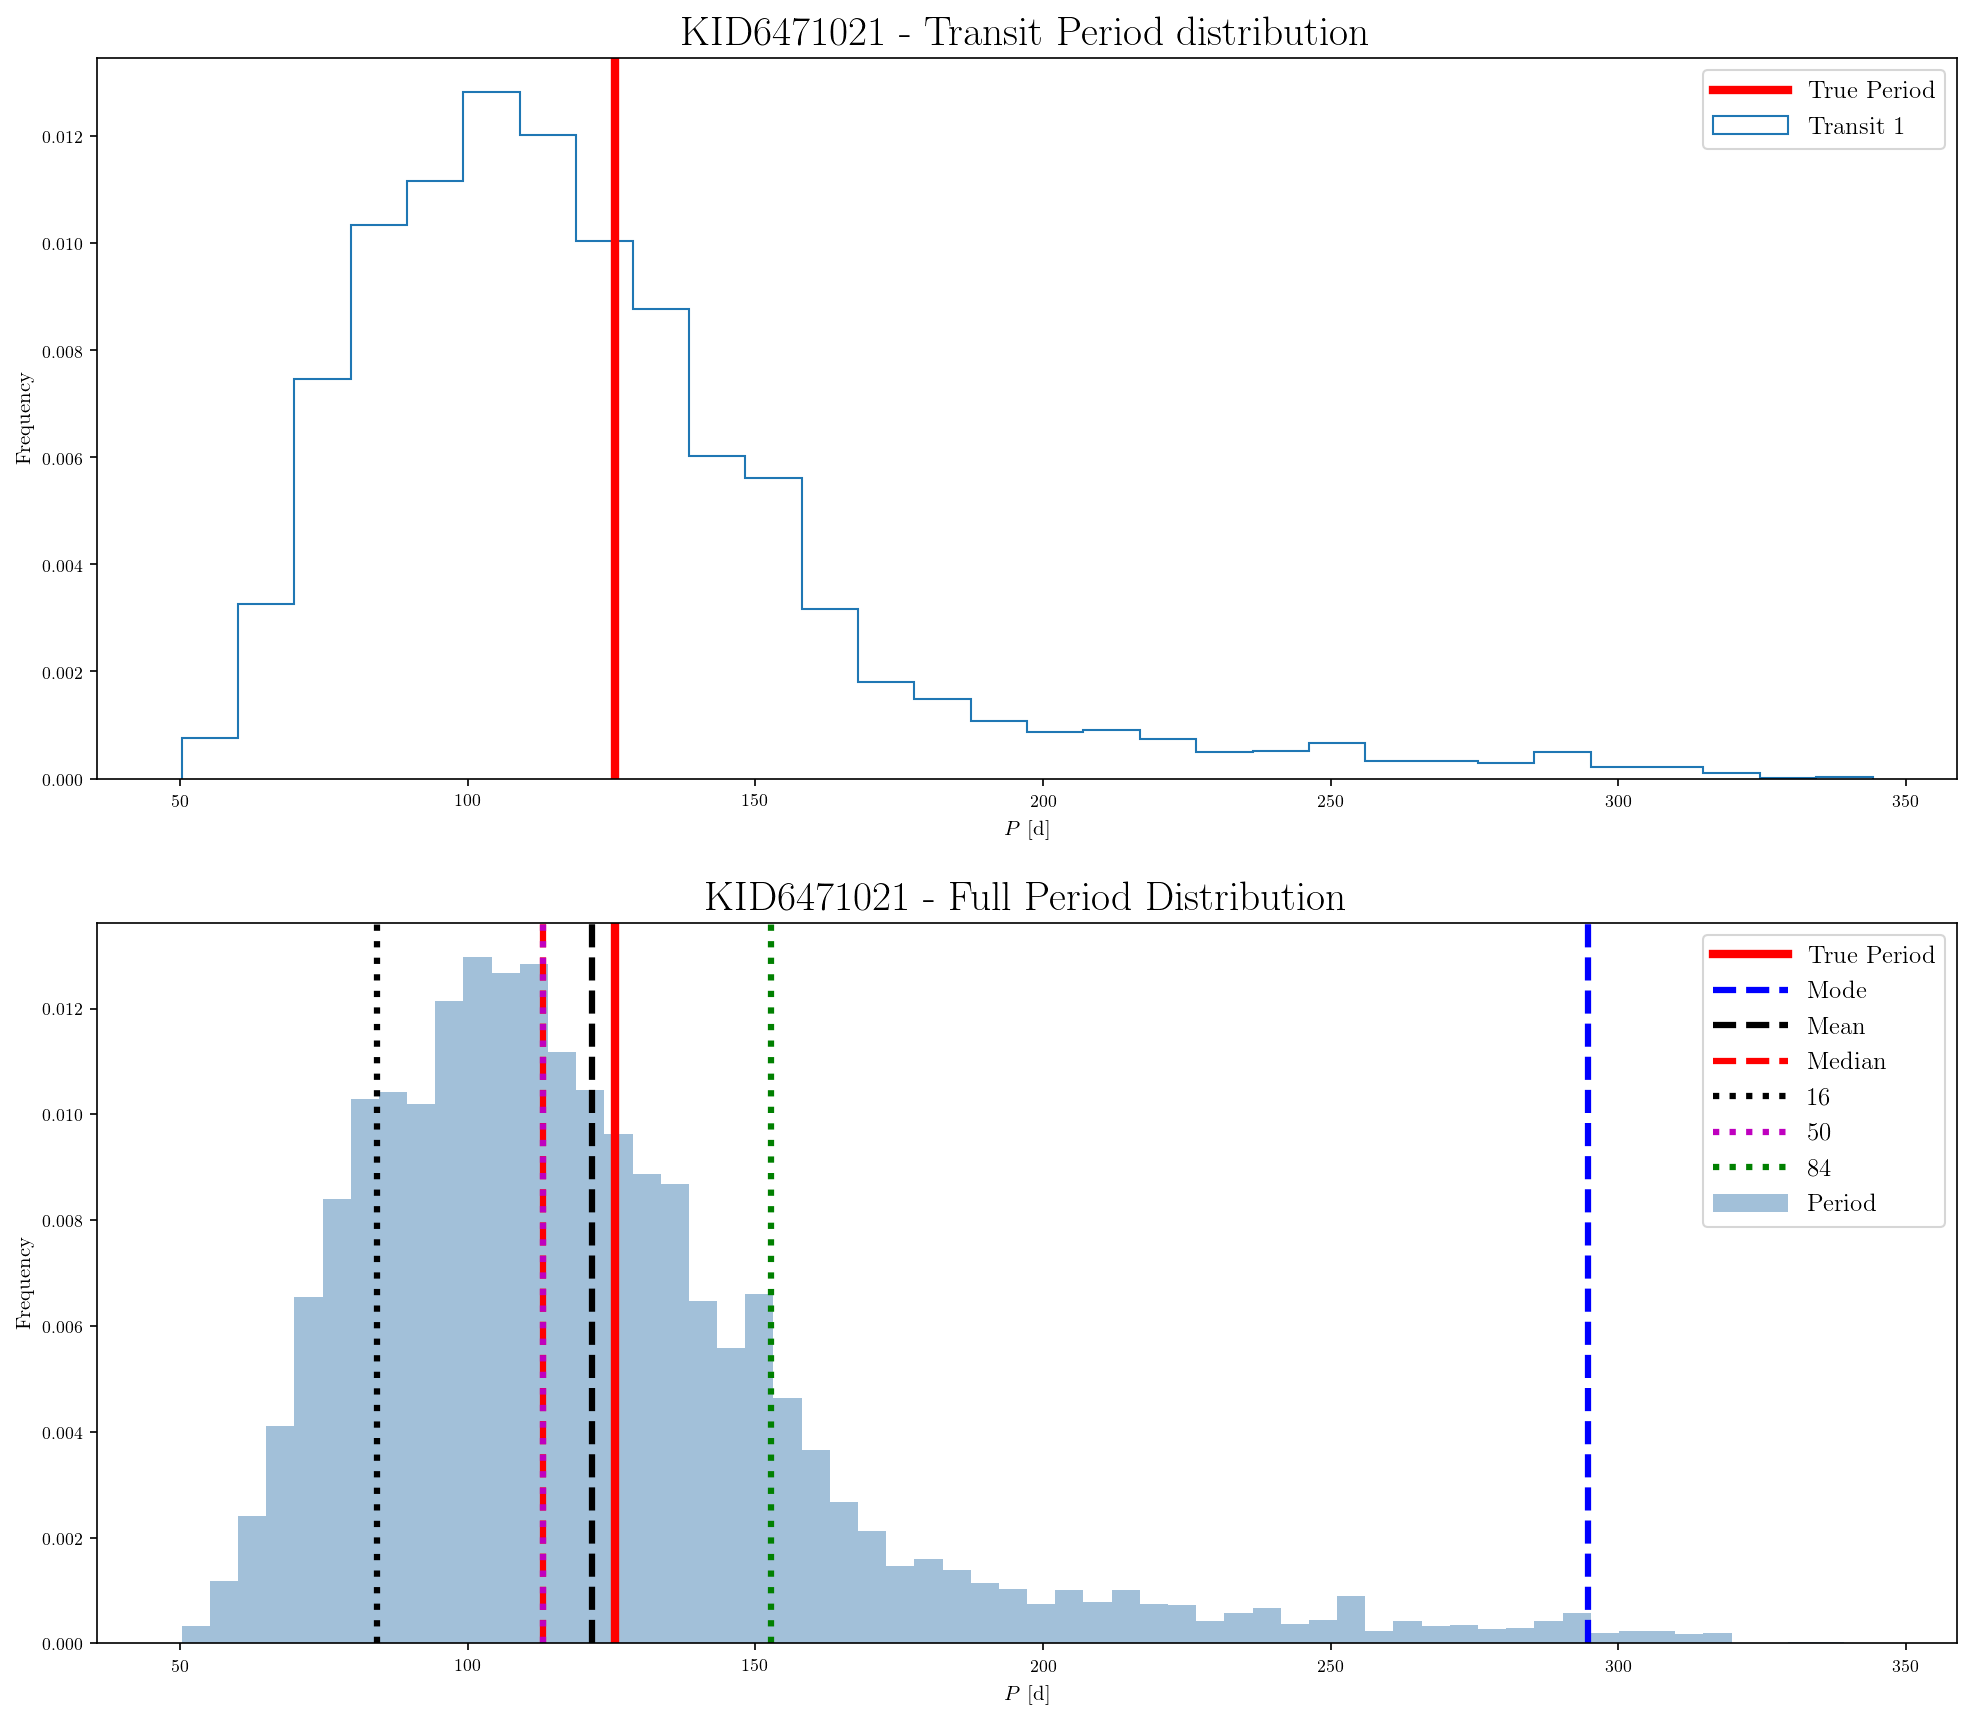

<Figure size 2400x1050 with 0 Axes>

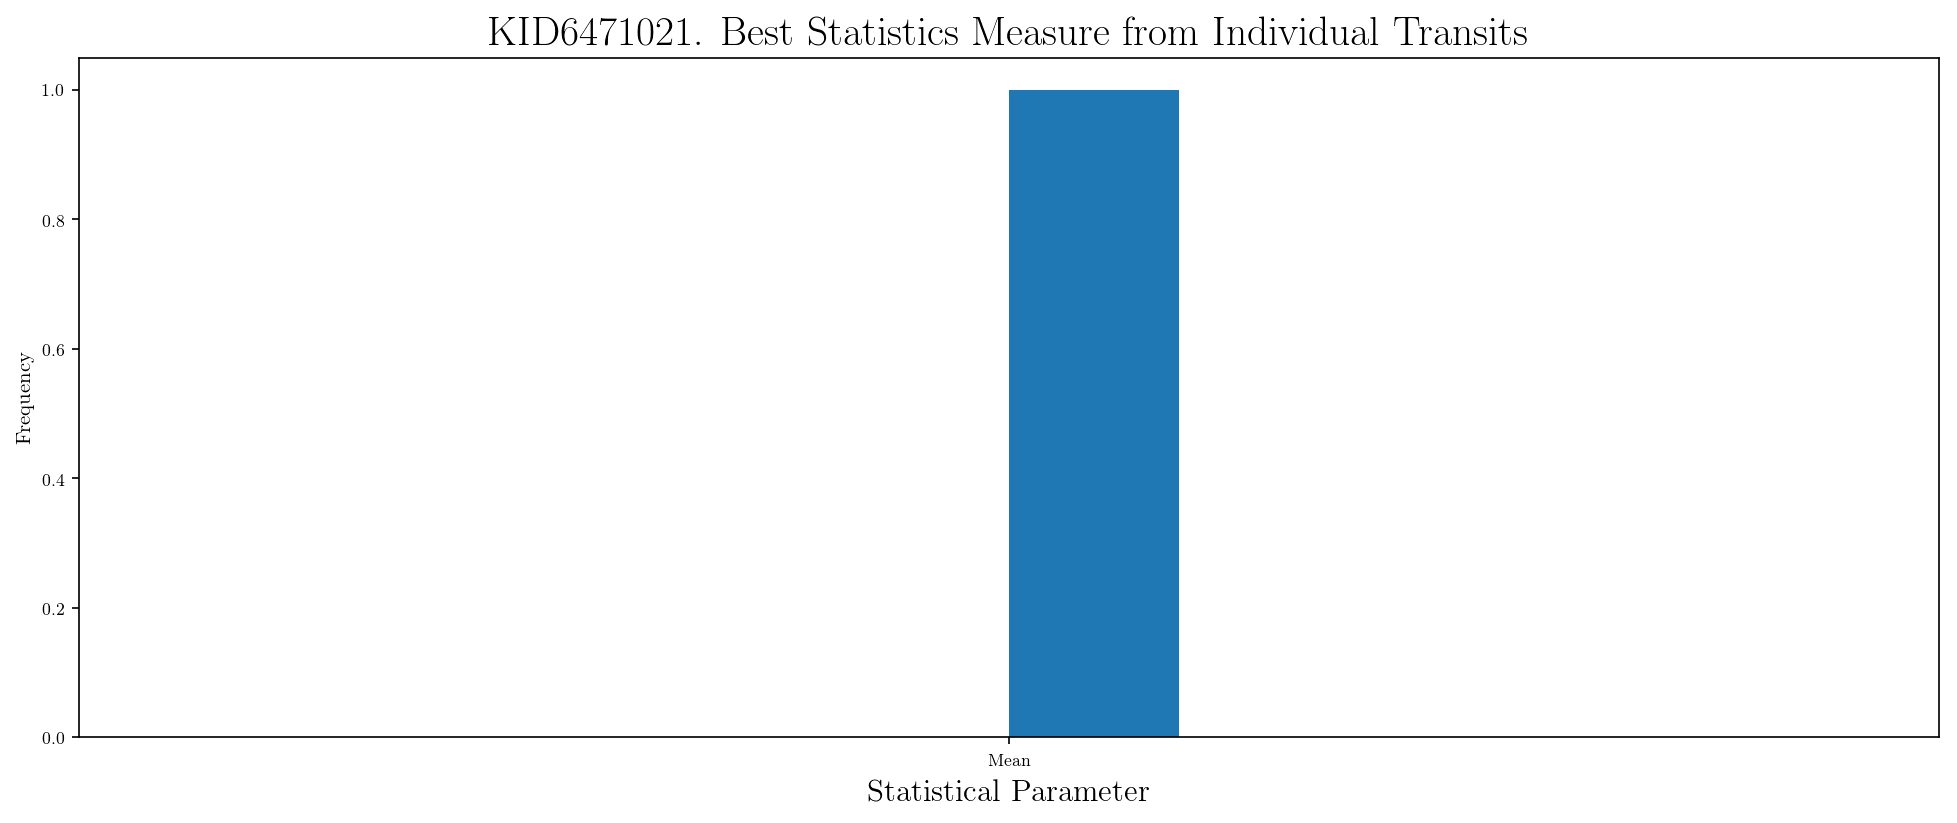

<Figure size 2400x1050 with 0 Axes>

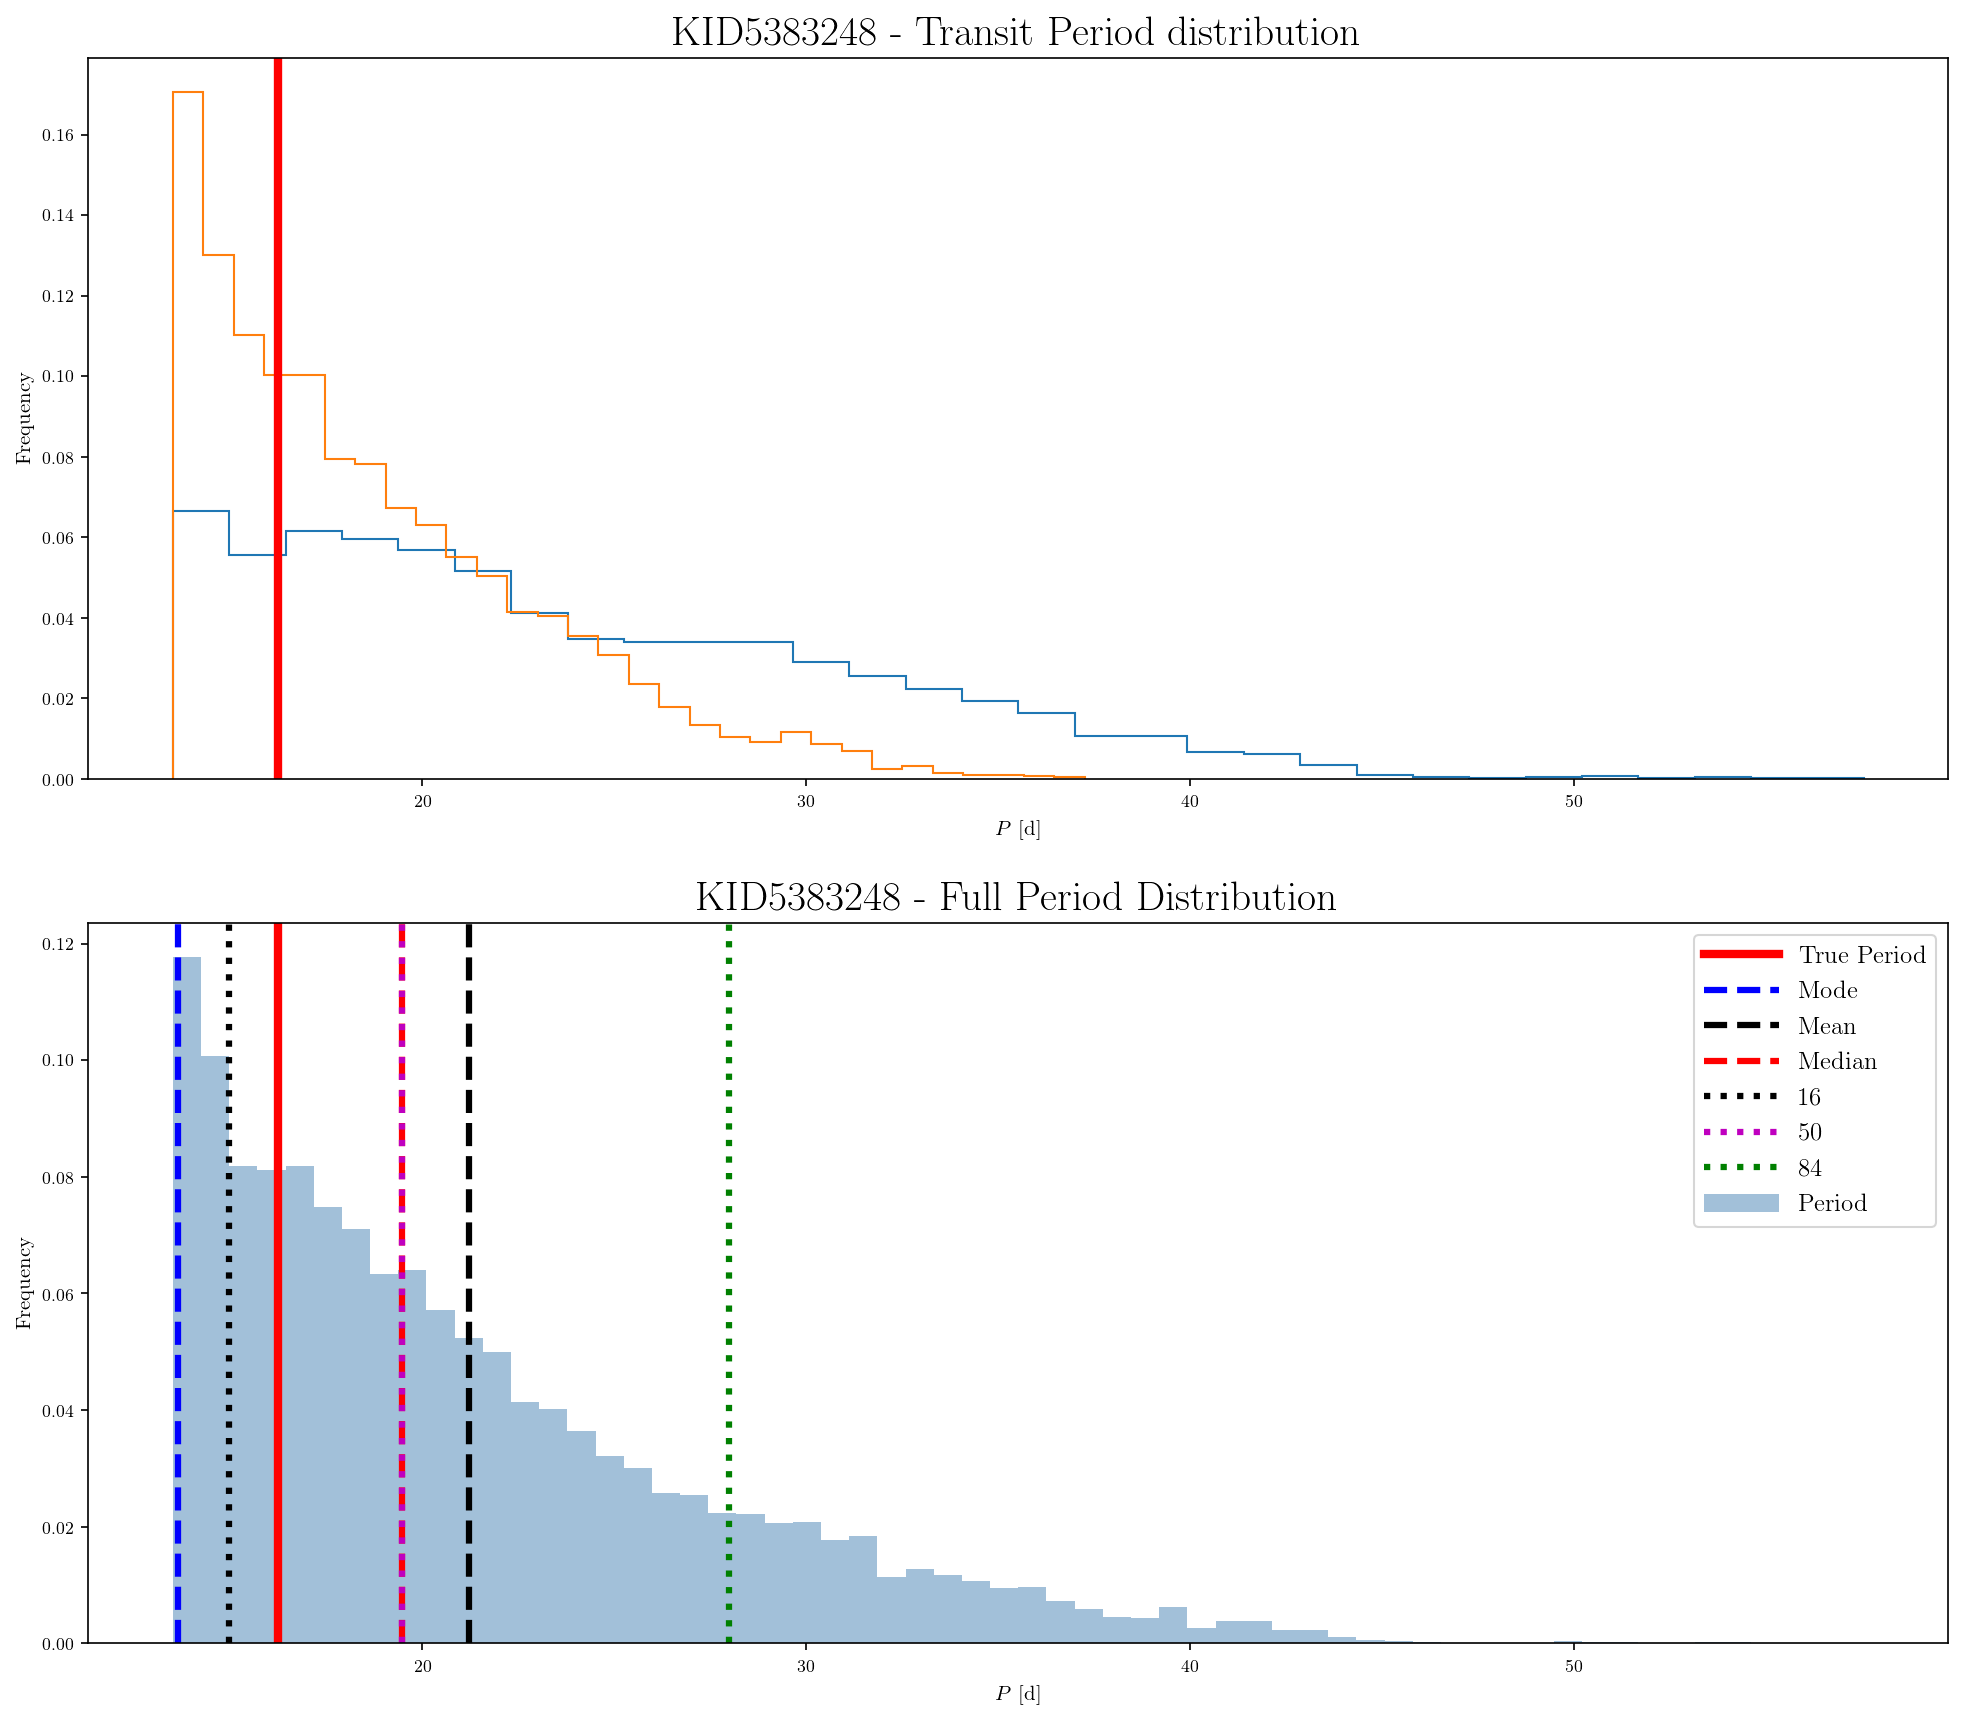

<Figure size 2400x1050 with 0 Axes>

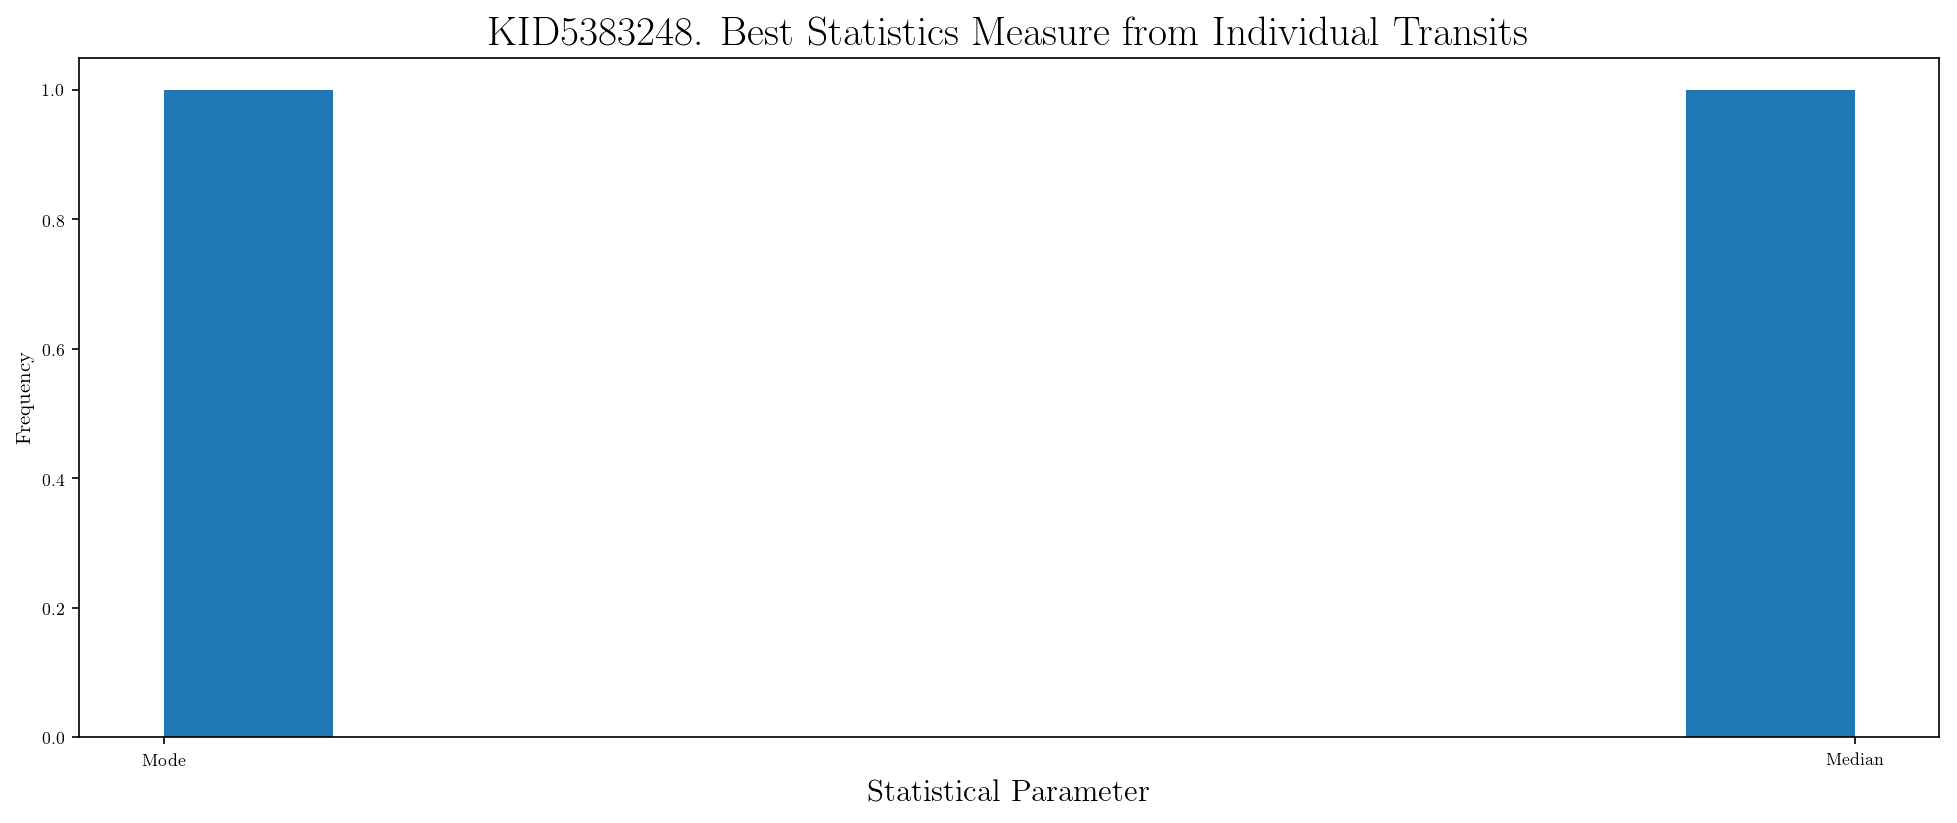

<Figure size 2400x1050 with 0 Axes>

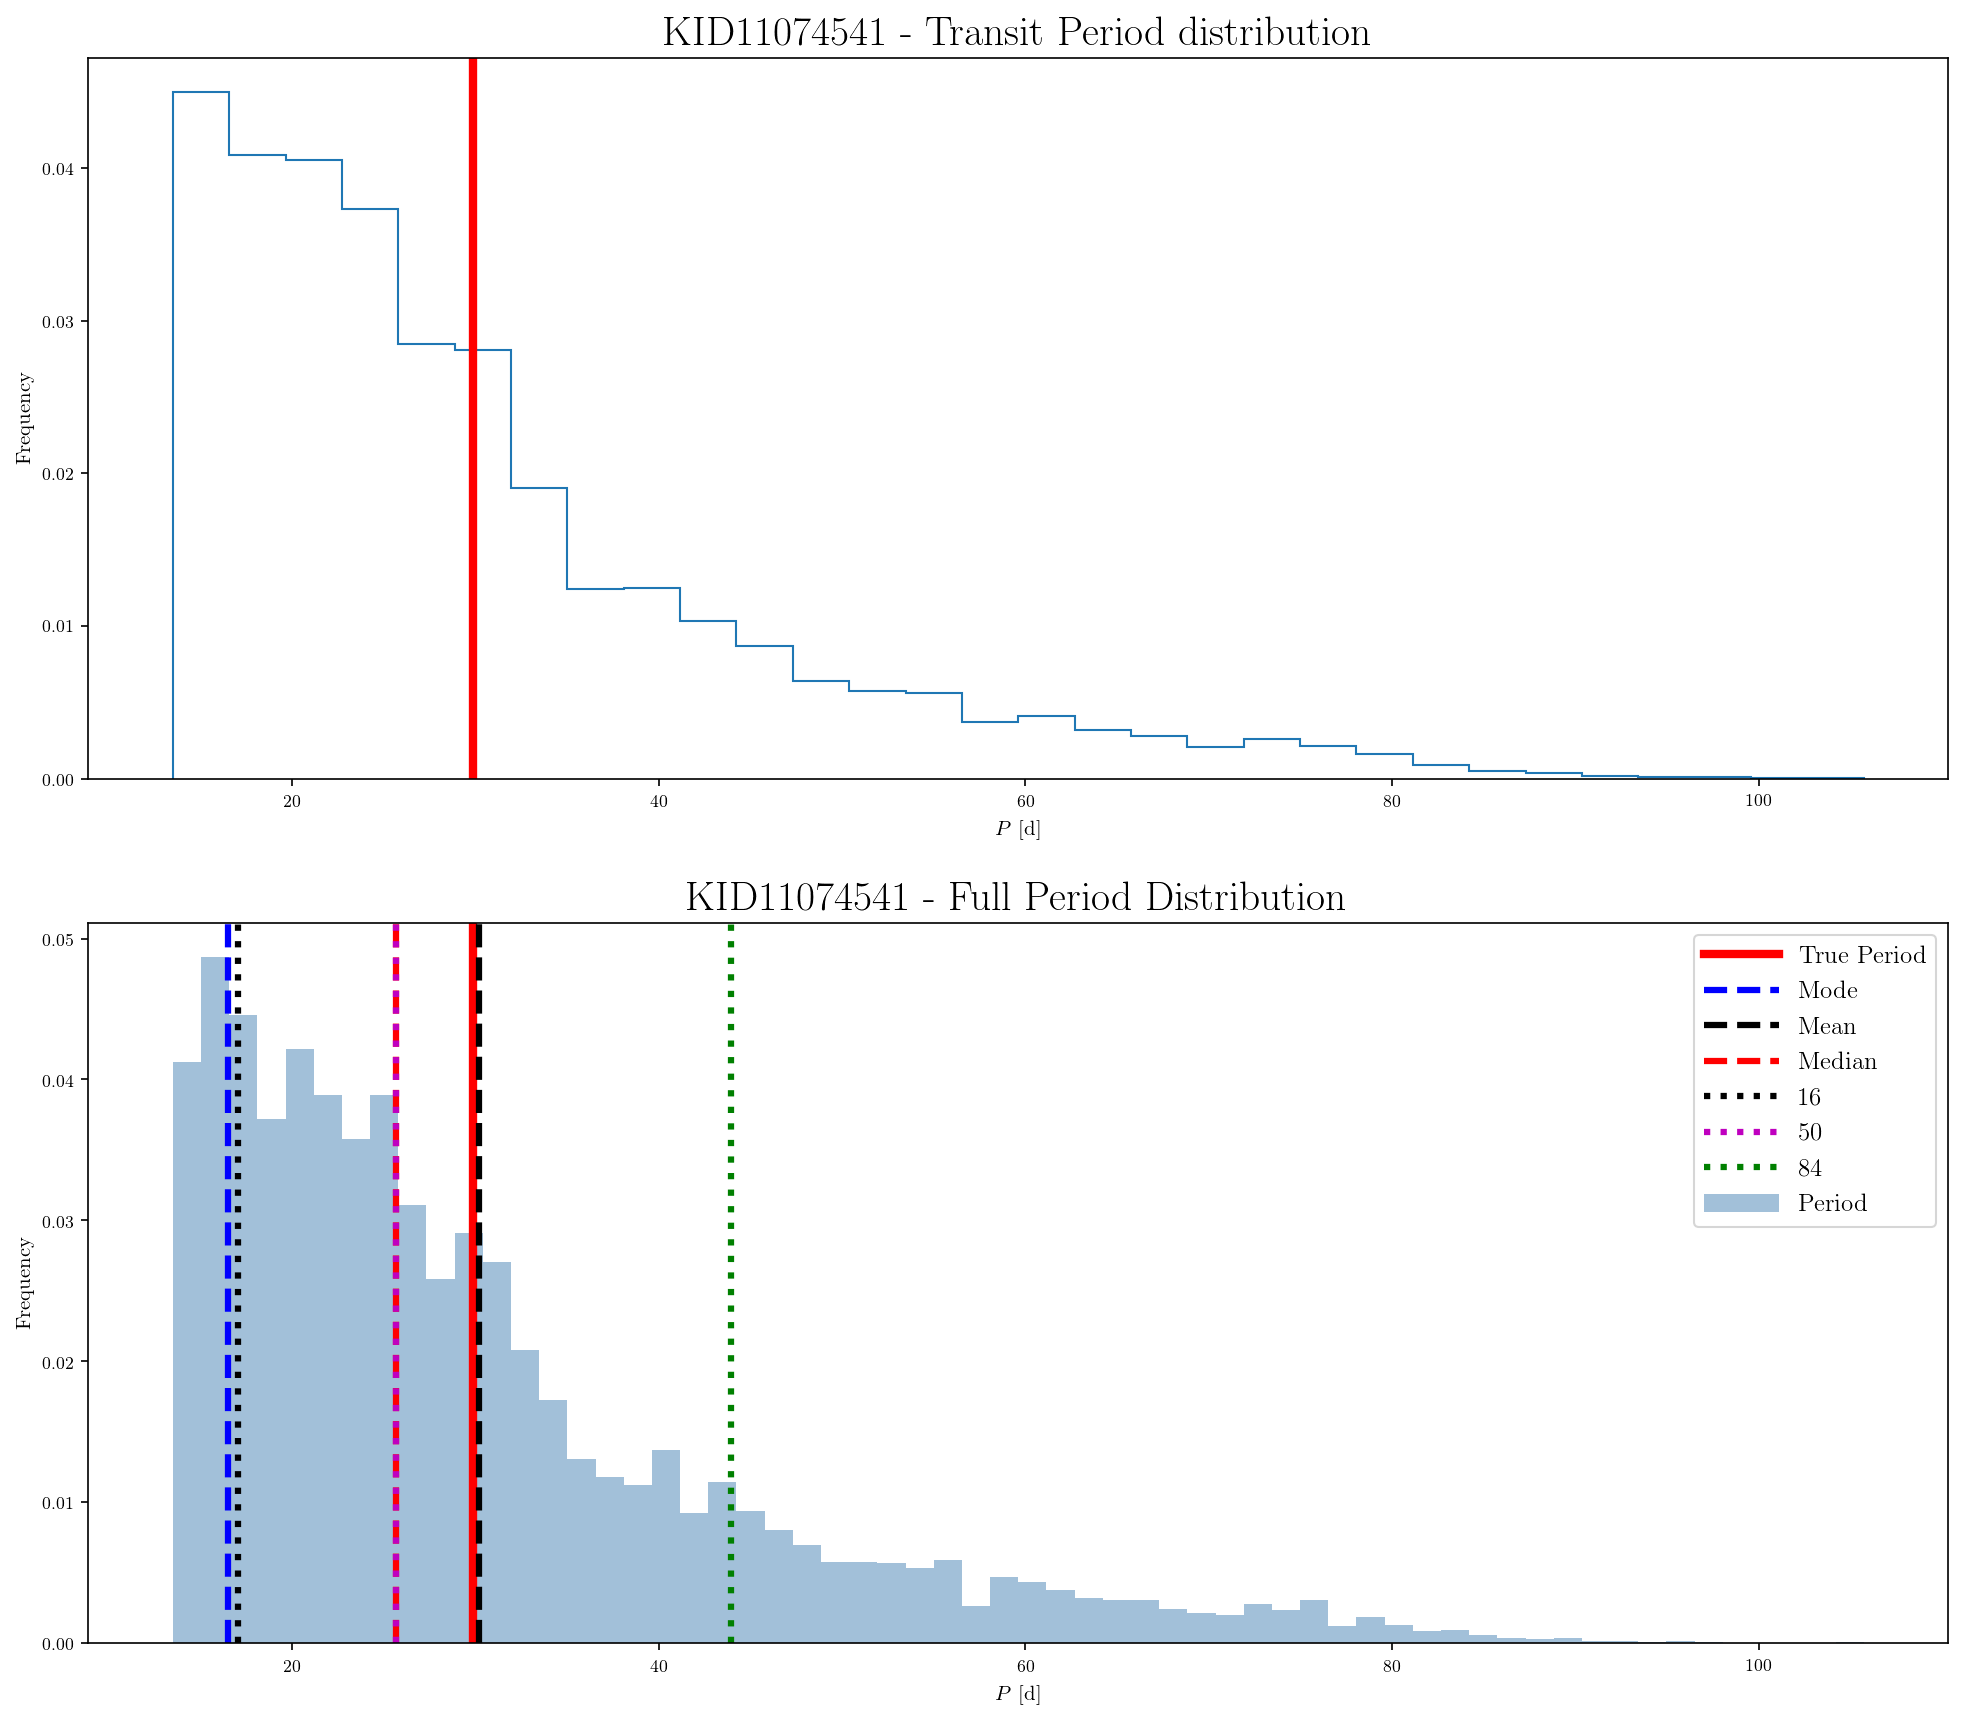

<Figure size 2400x1050 with 0 Axes>

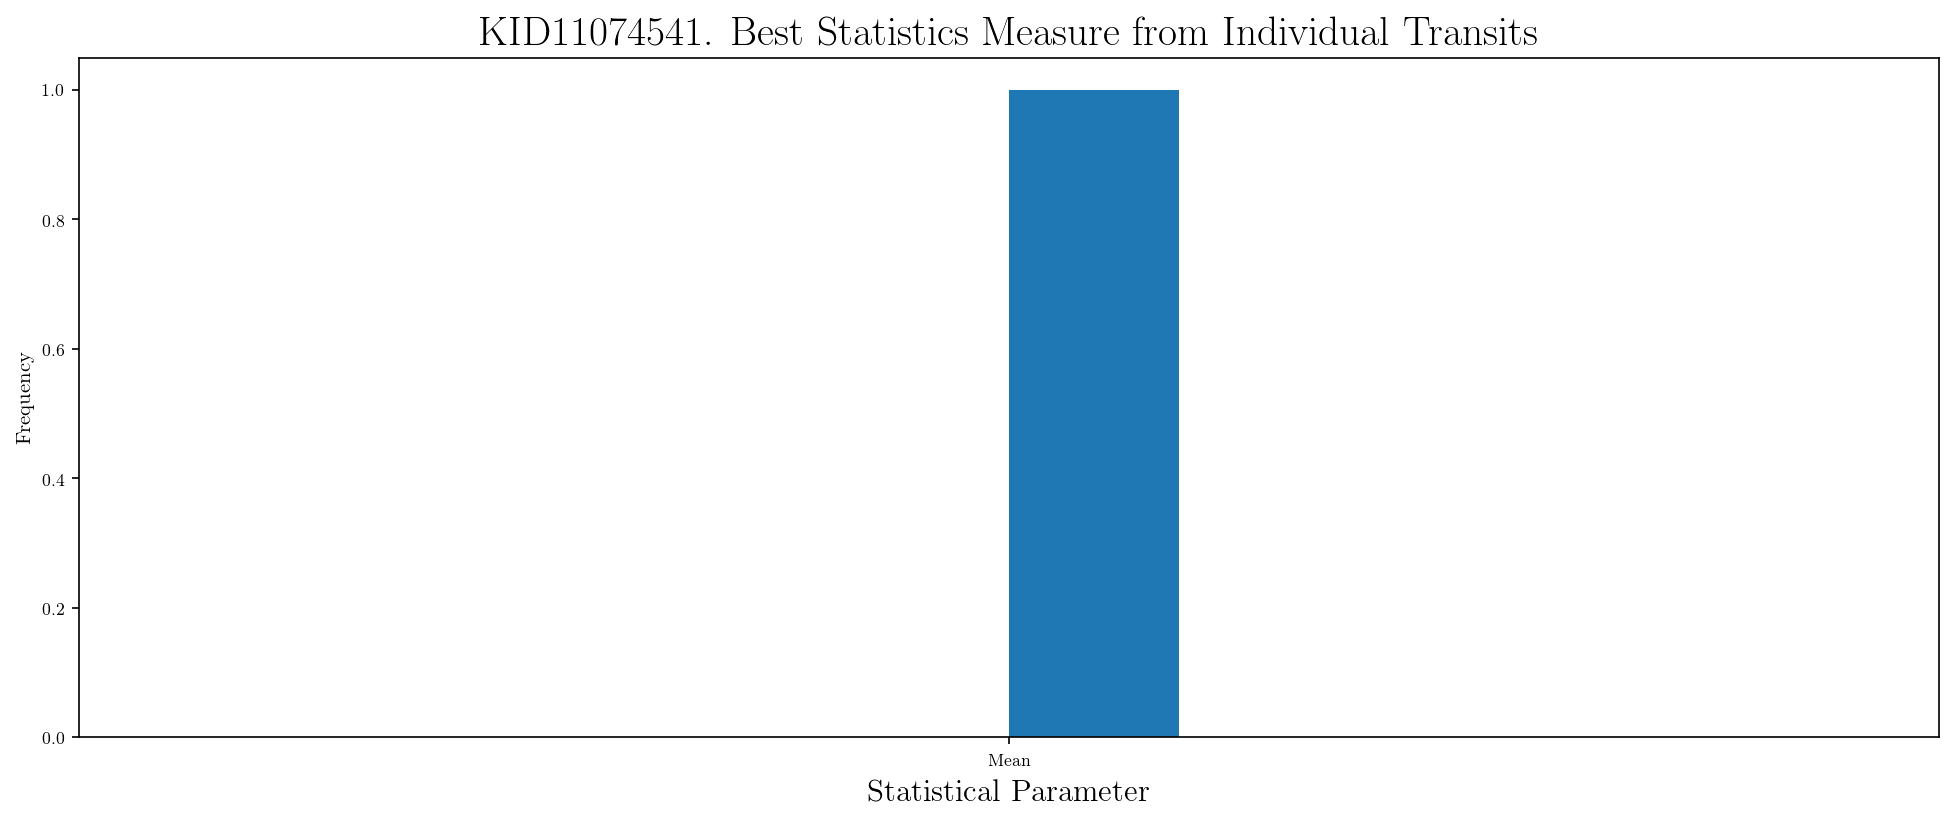

<Figure size 2400x1050 with 0 Axes>

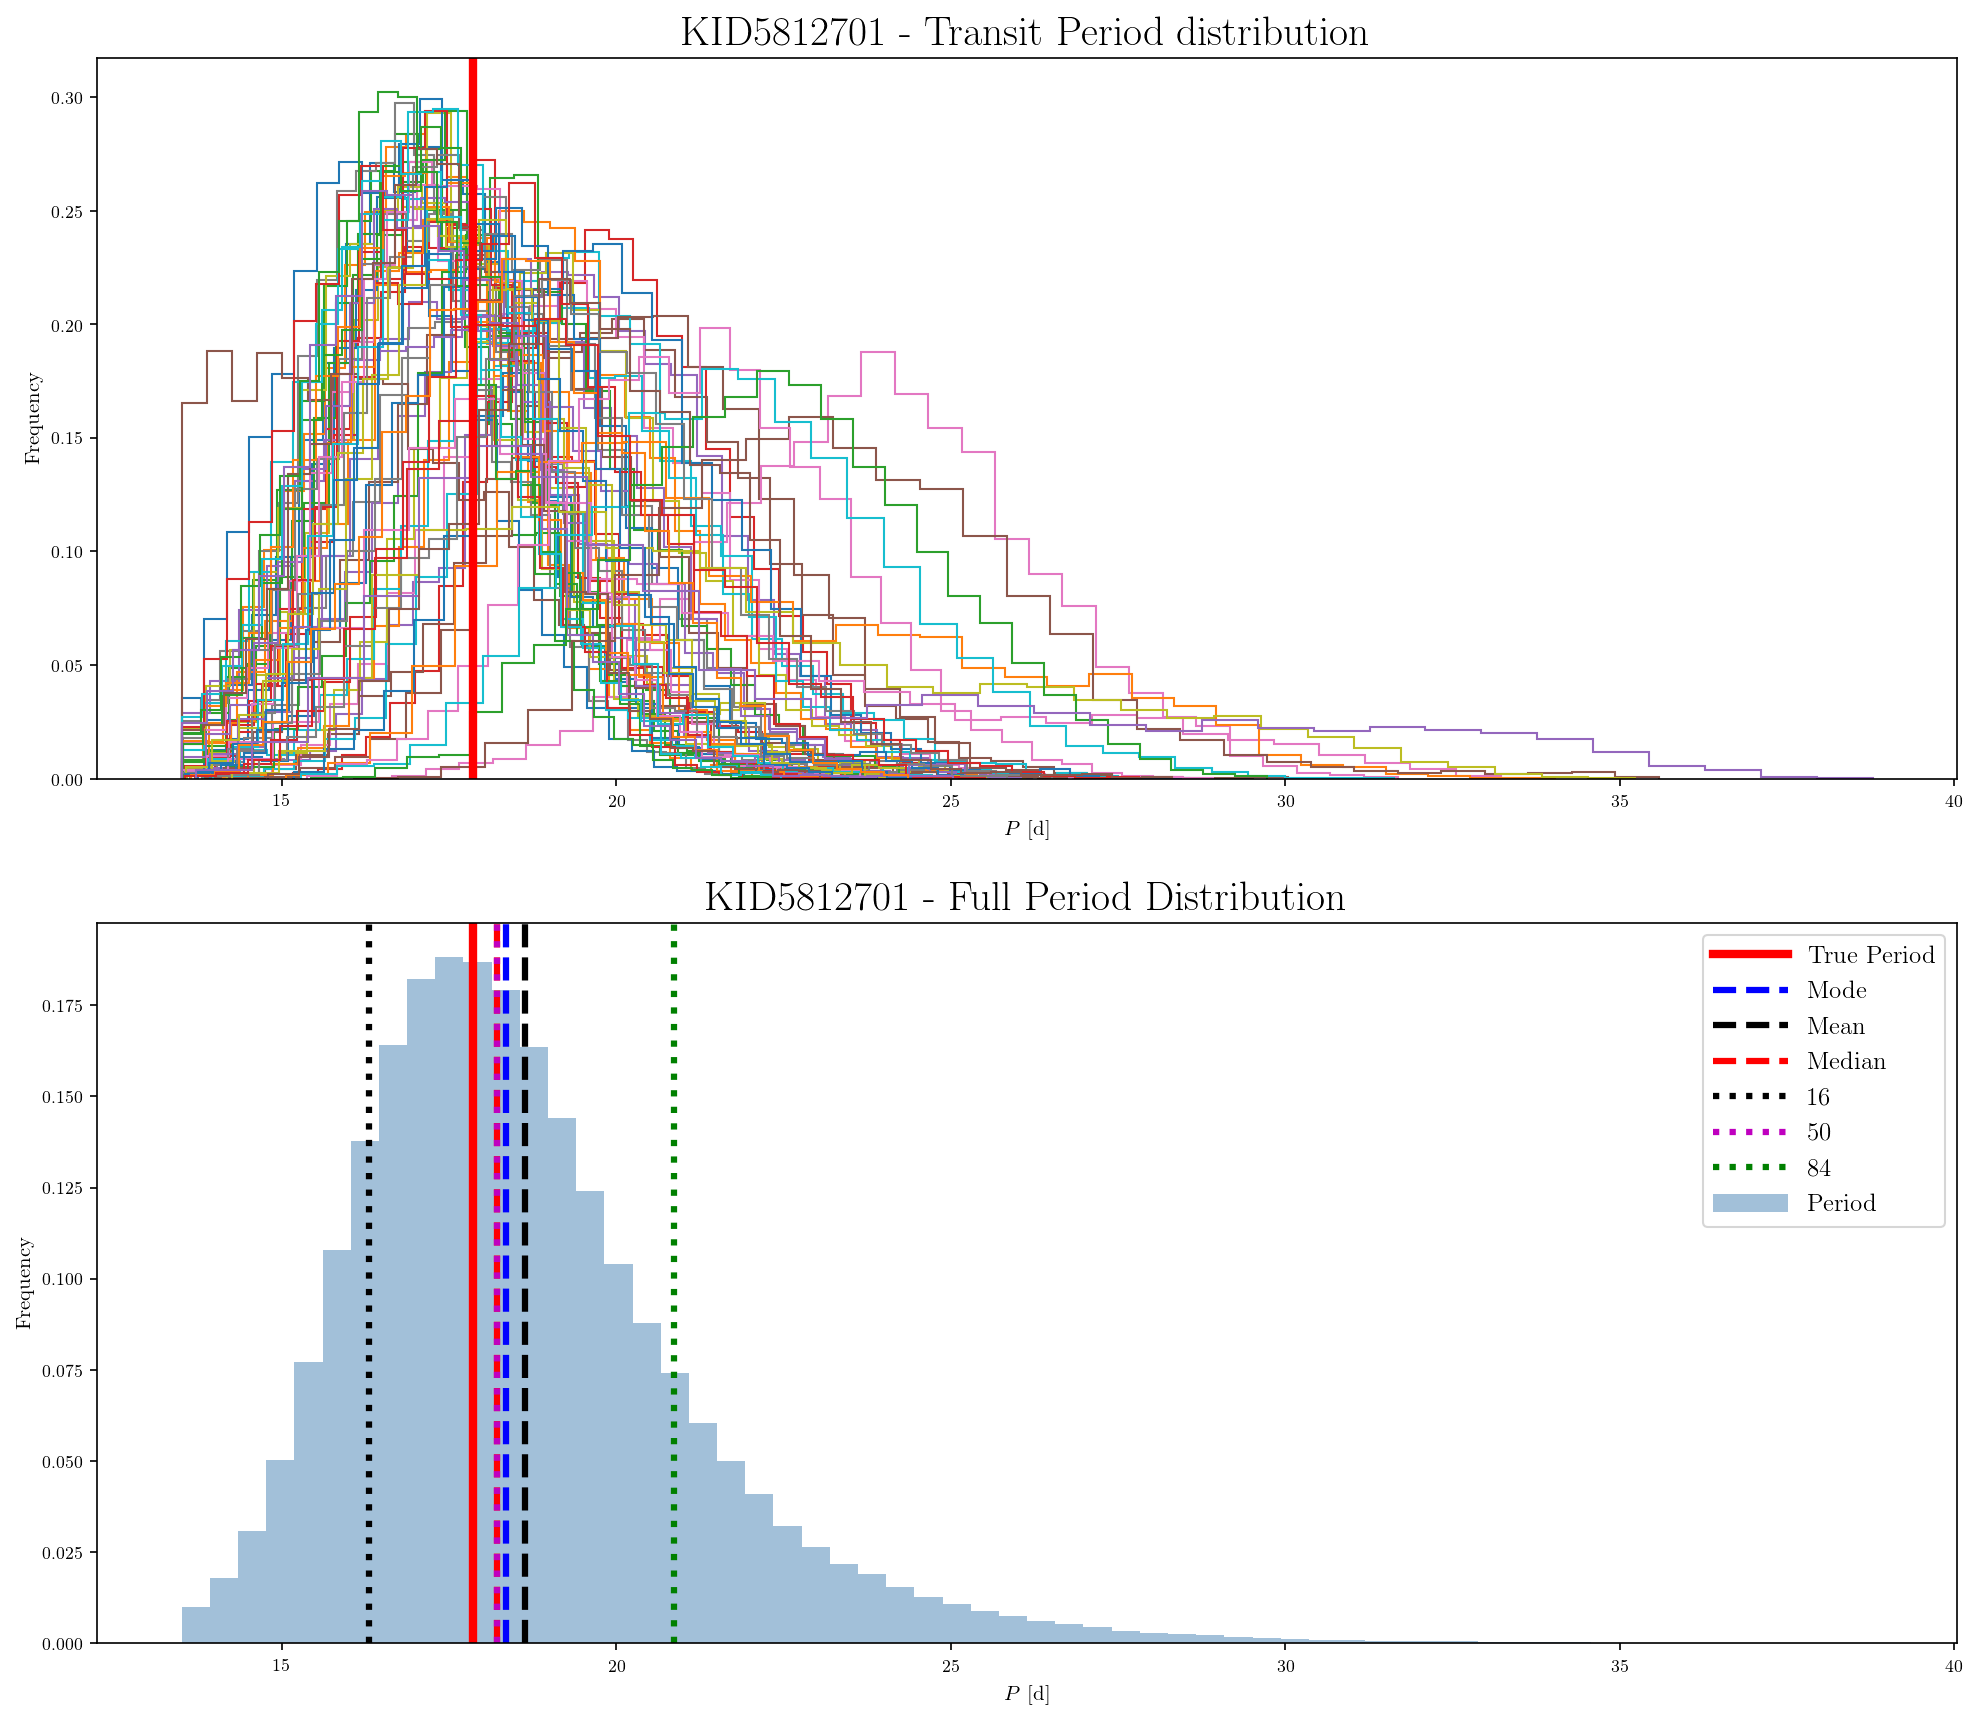

<Figure size 2400x1050 with 0 Axes>

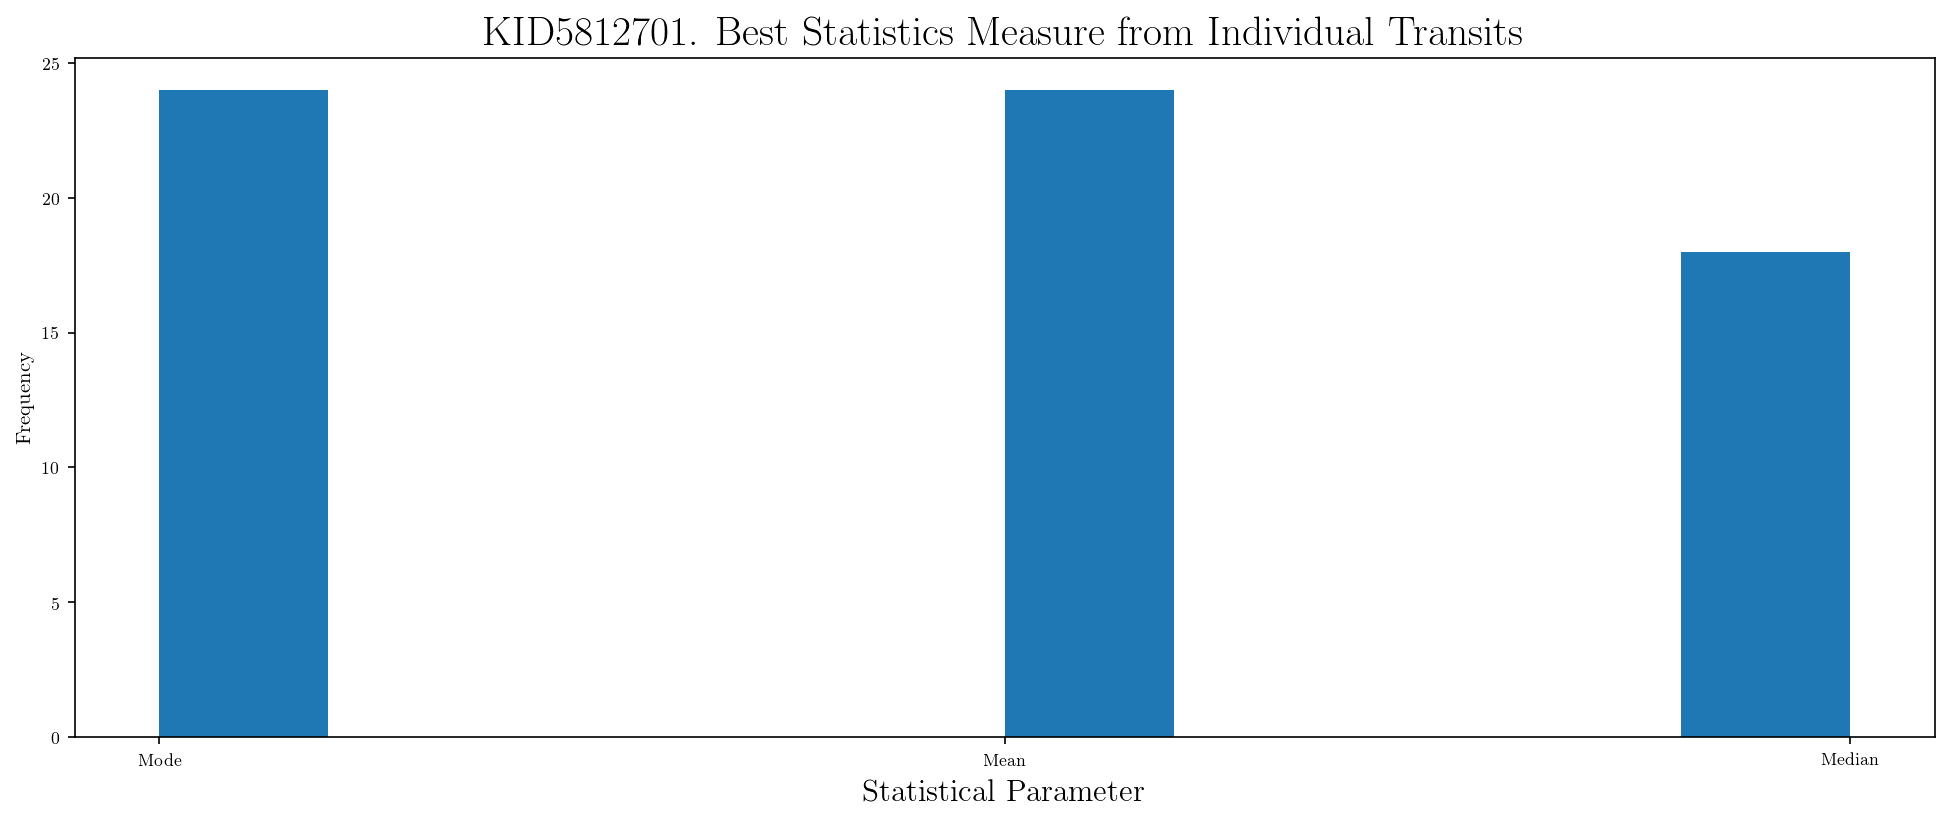

<Figure size 2400x1050 with 0 Axes>

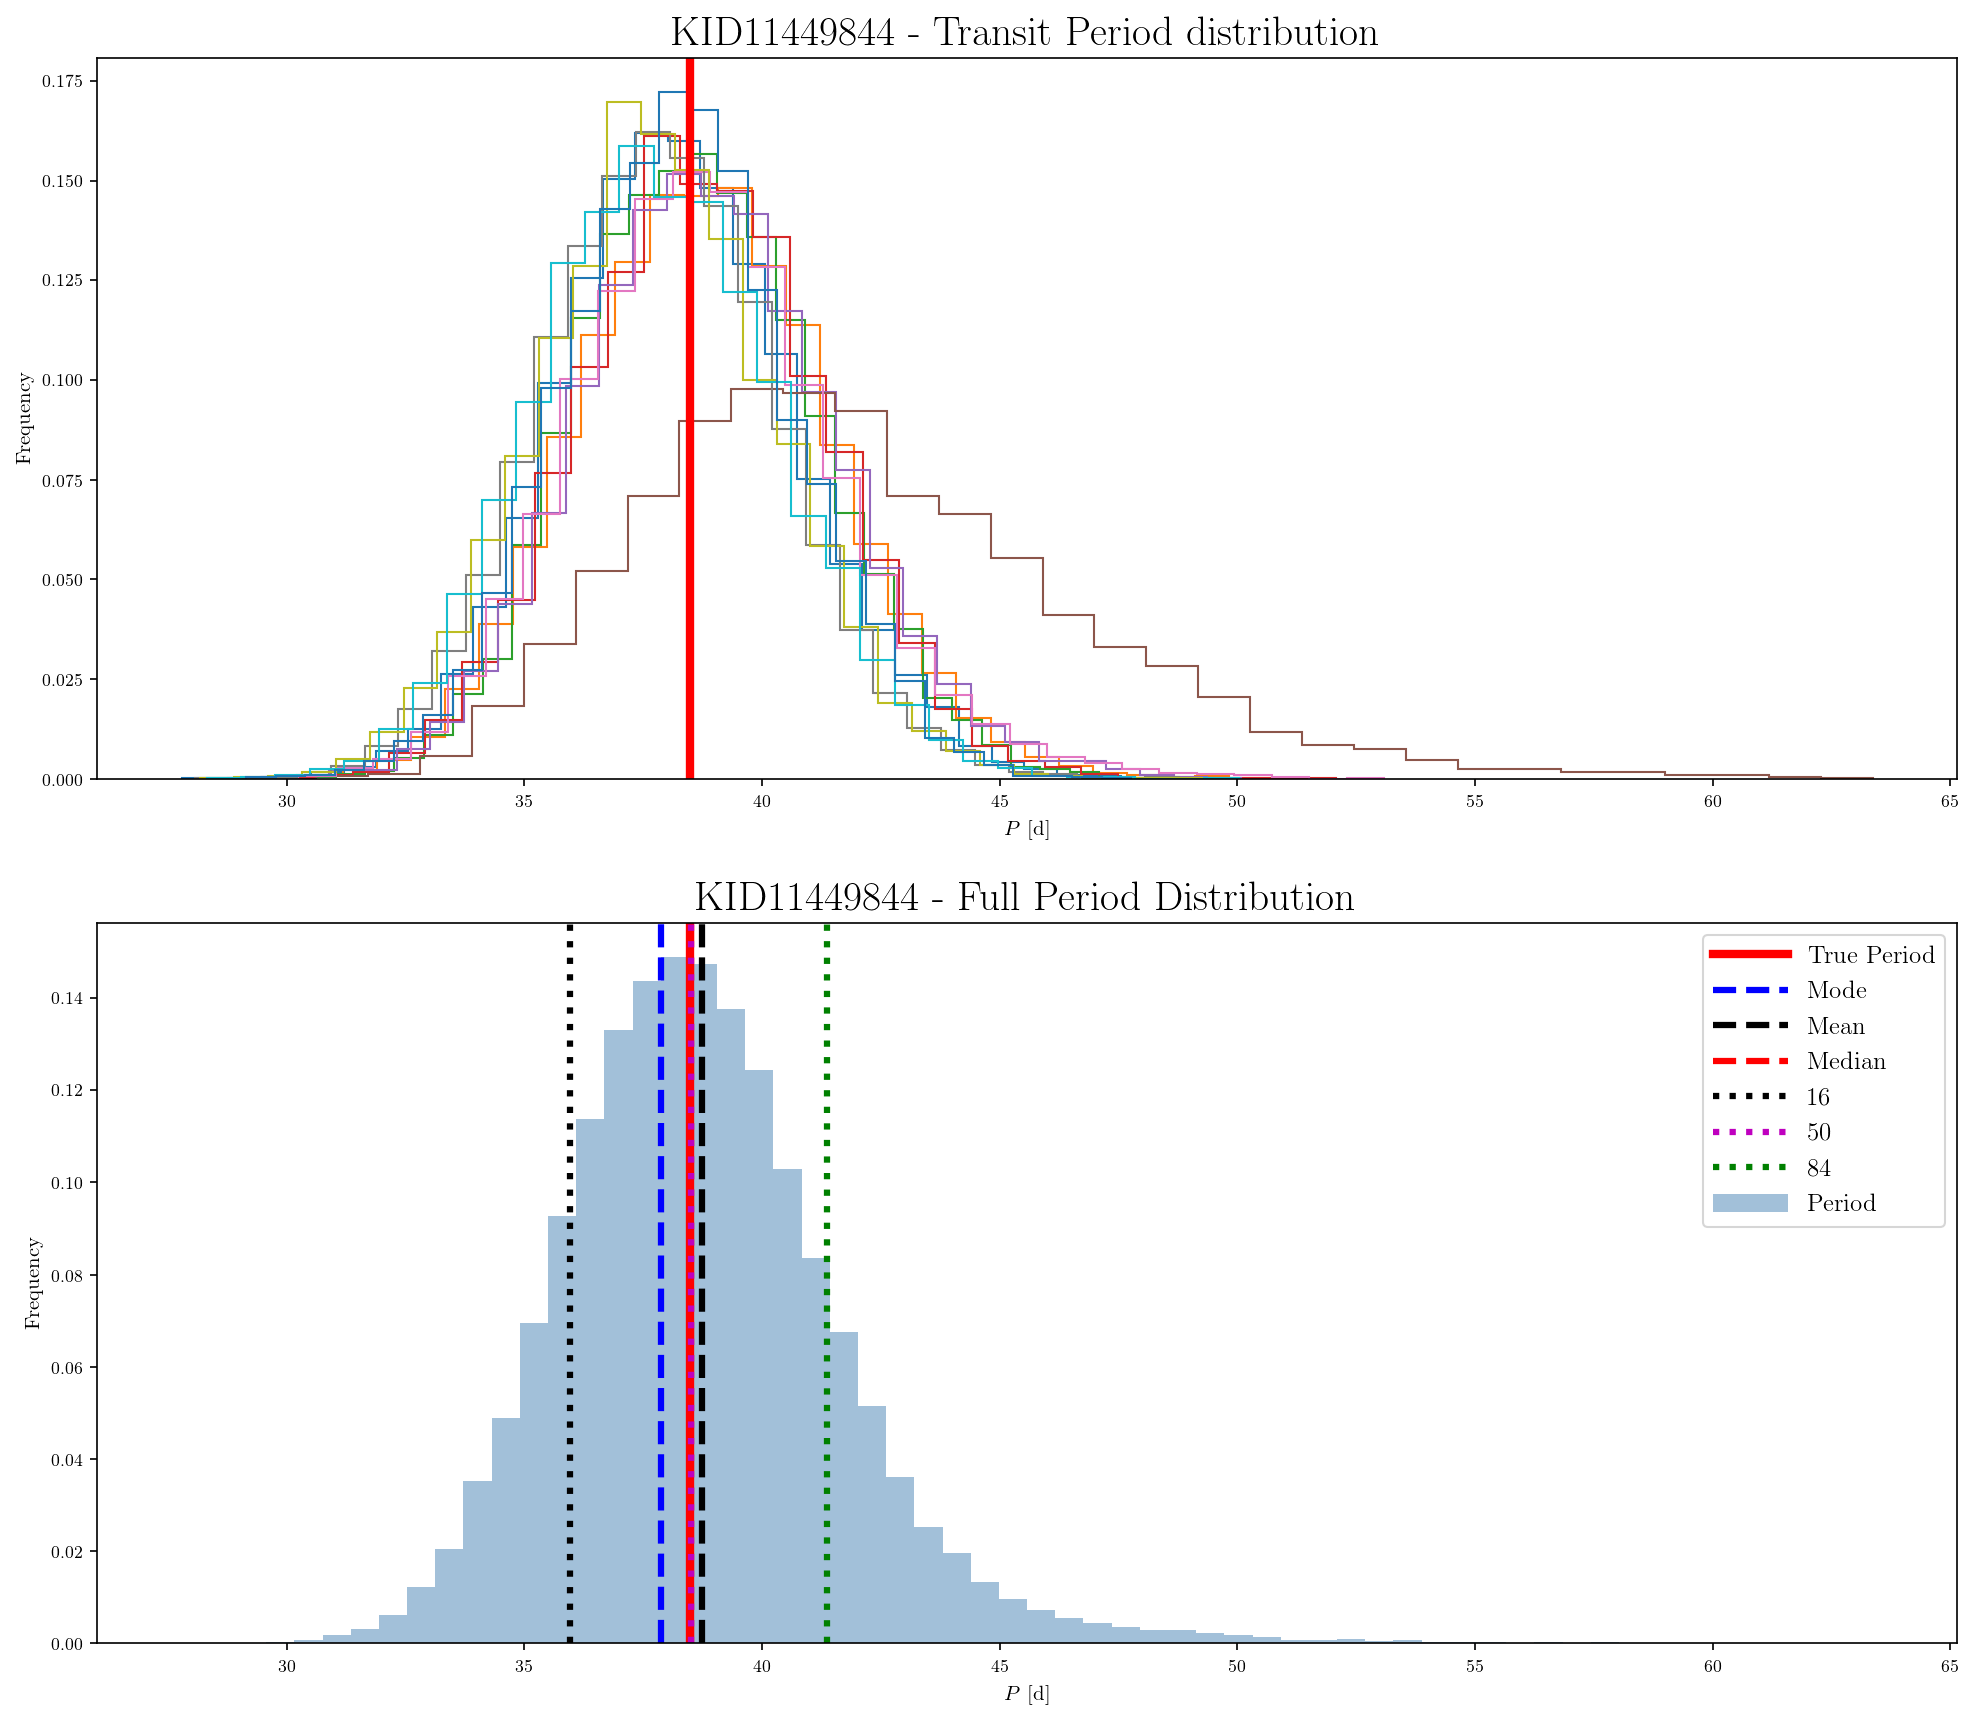

<Figure size 2400x1050 with 0 Axes>

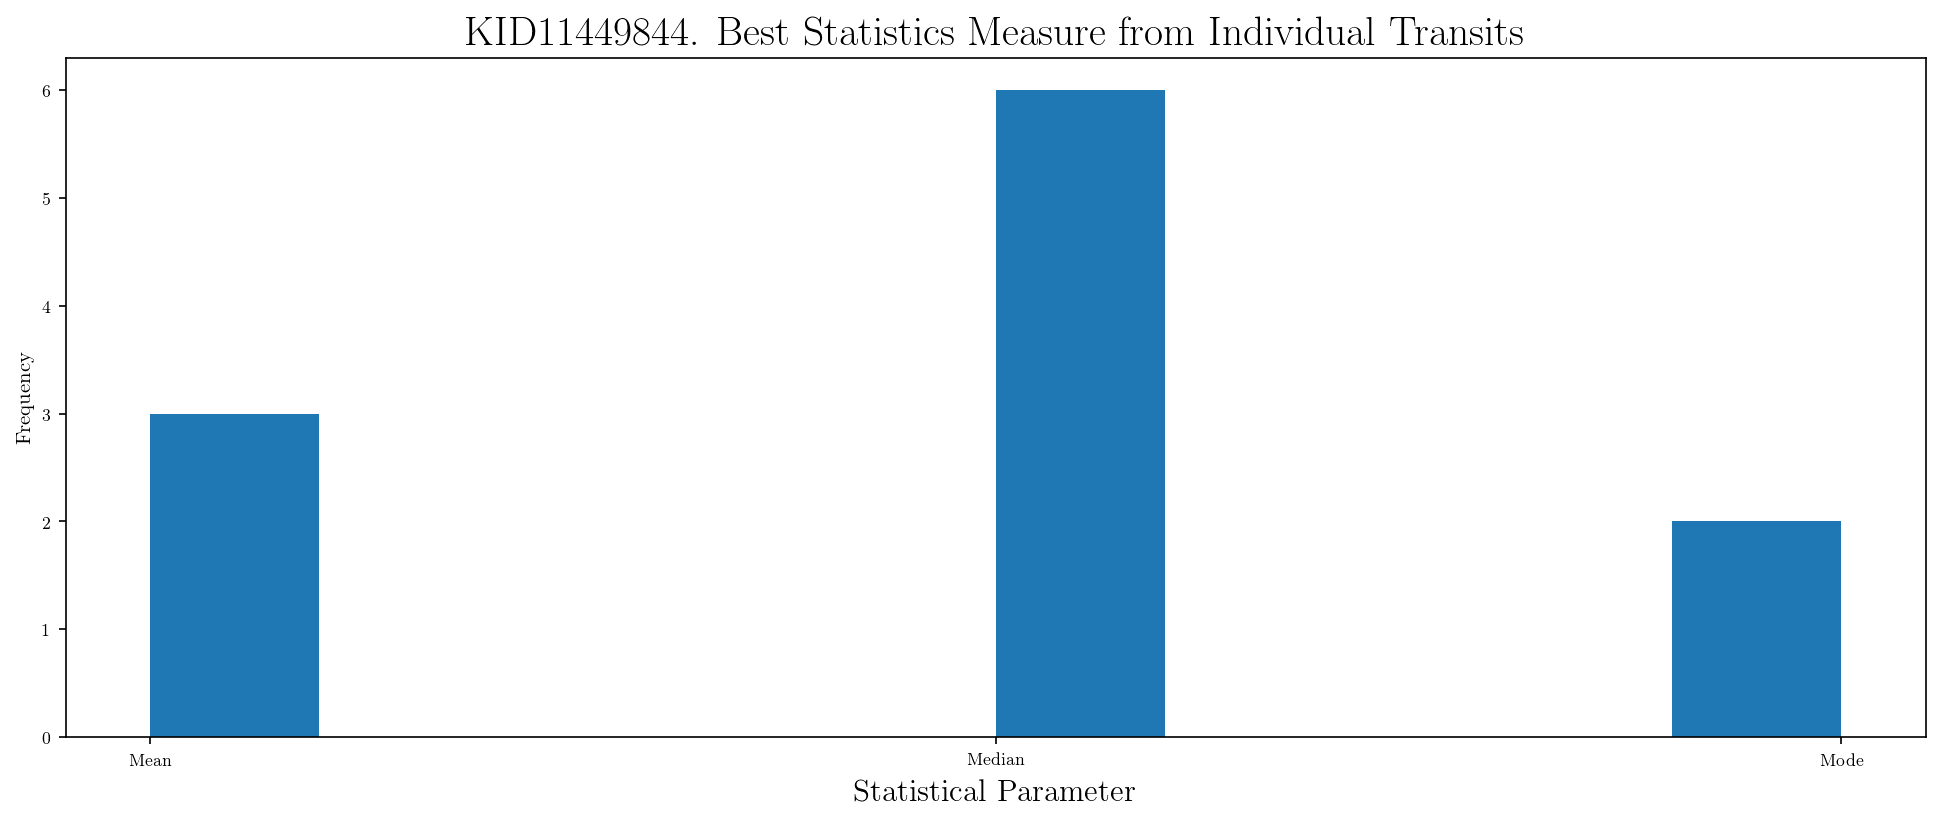

<Figure size 2400x1050 with 0 Axes>

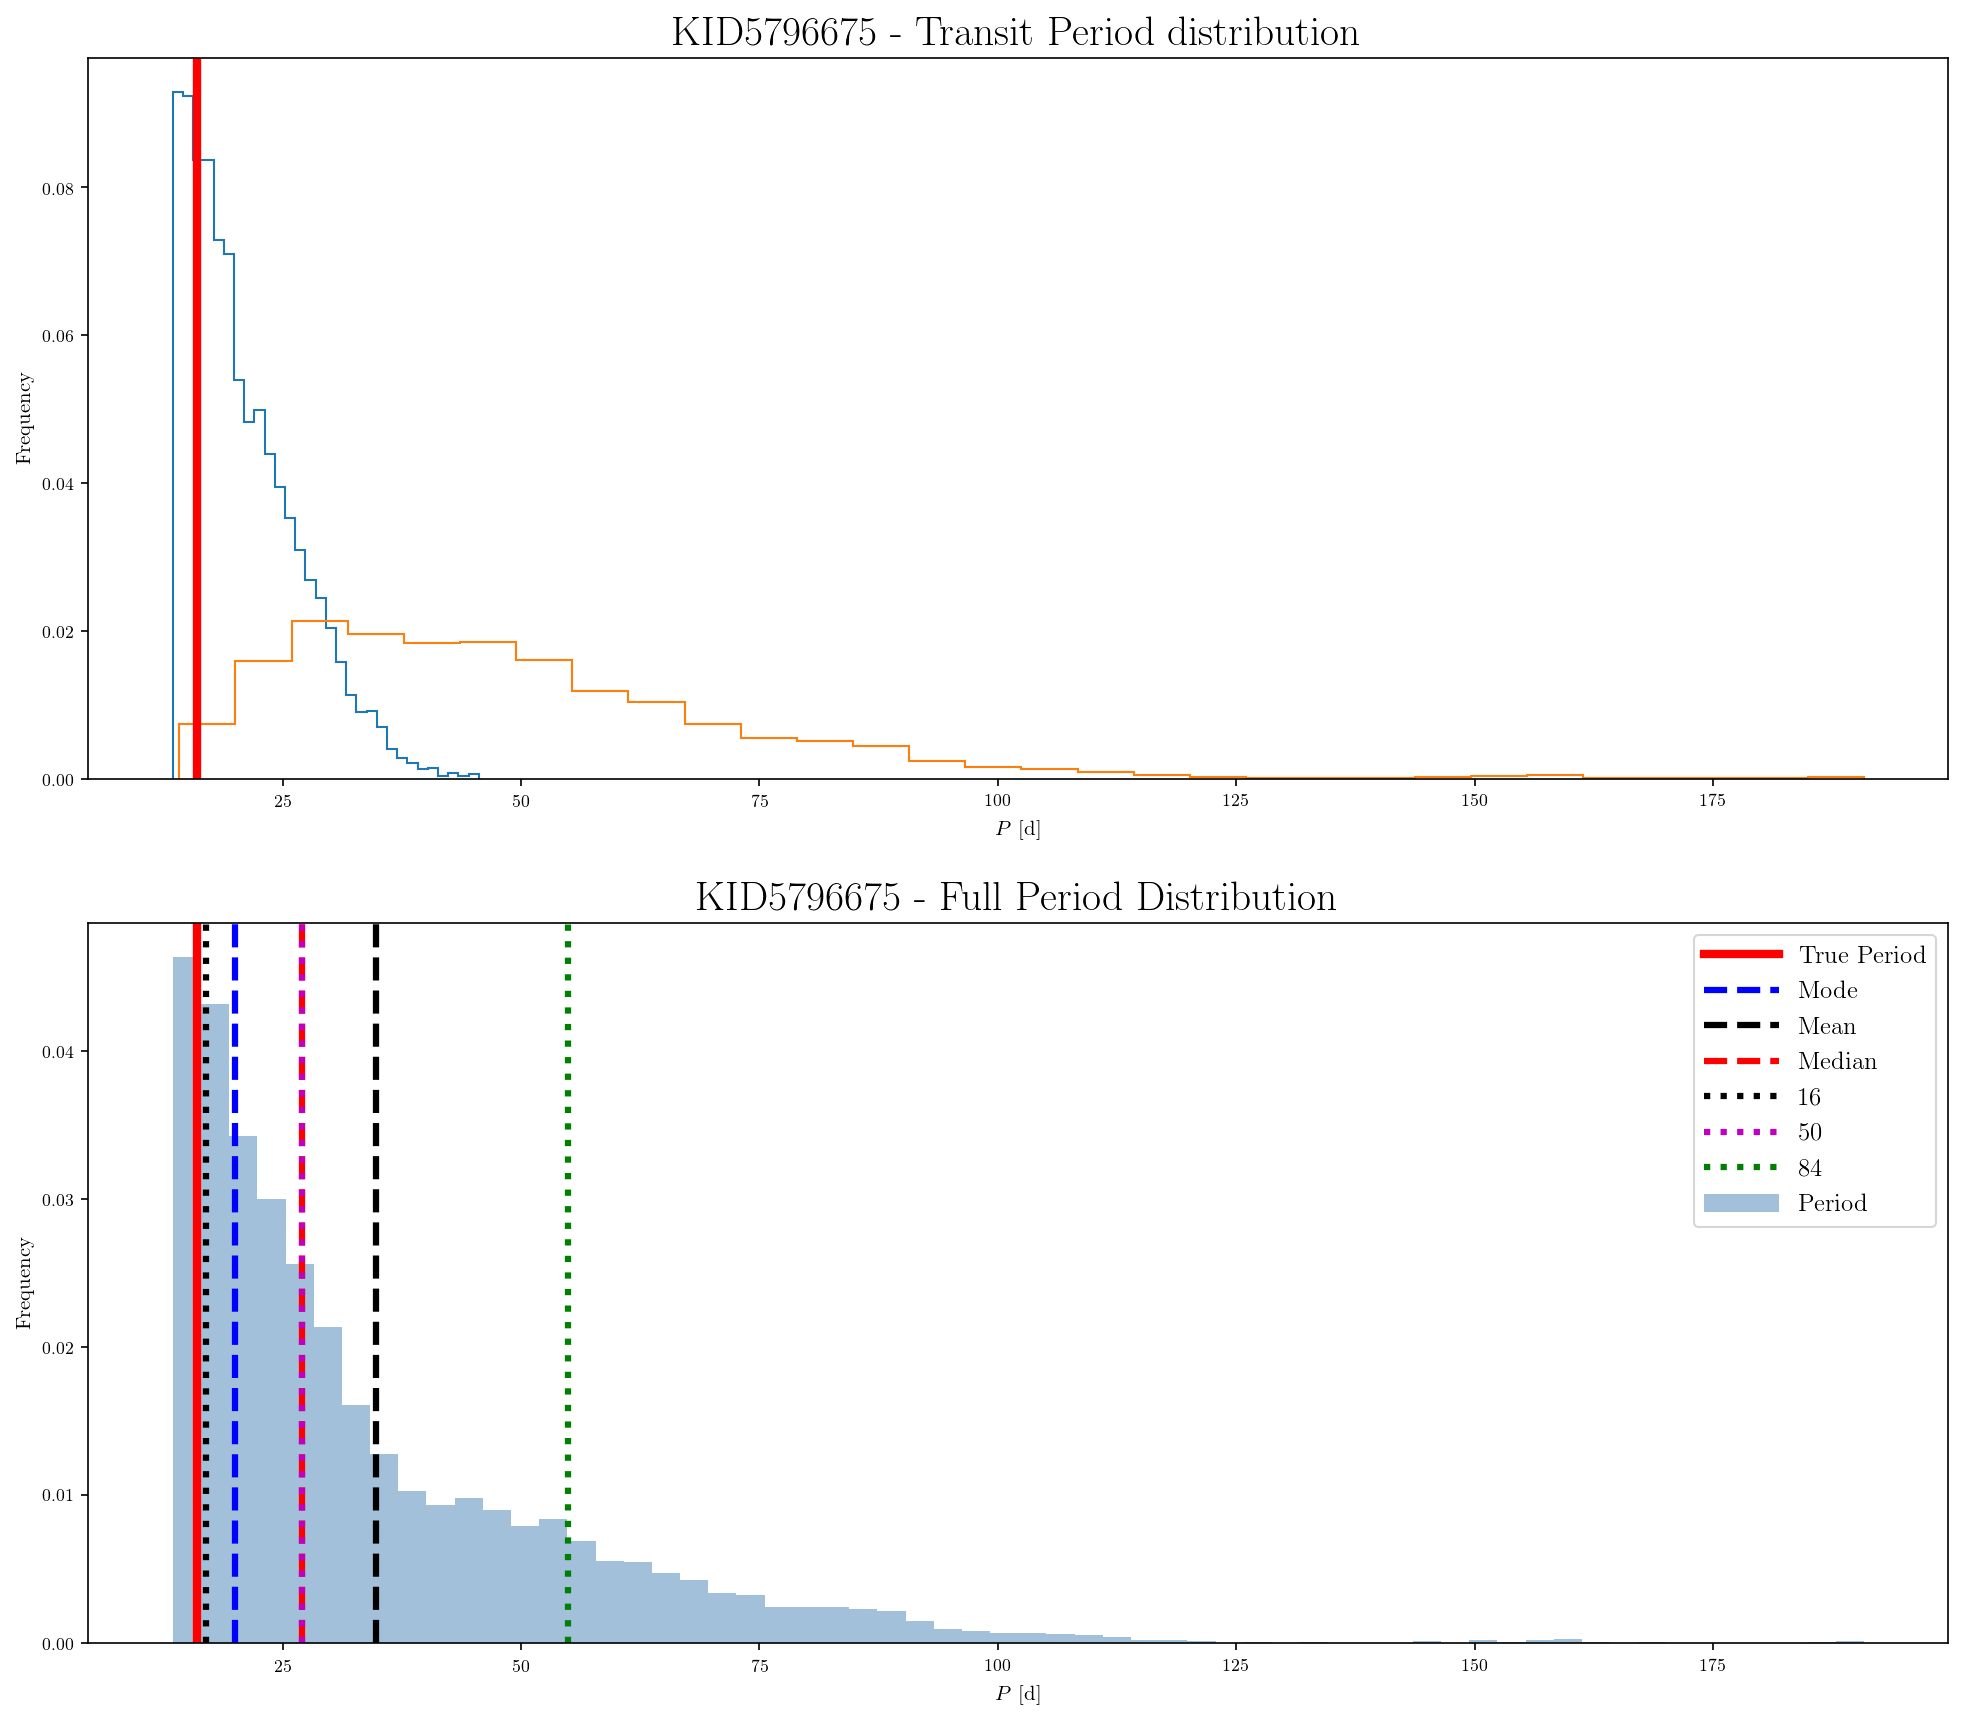

<Figure size 2400x1050 with 0 Axes>

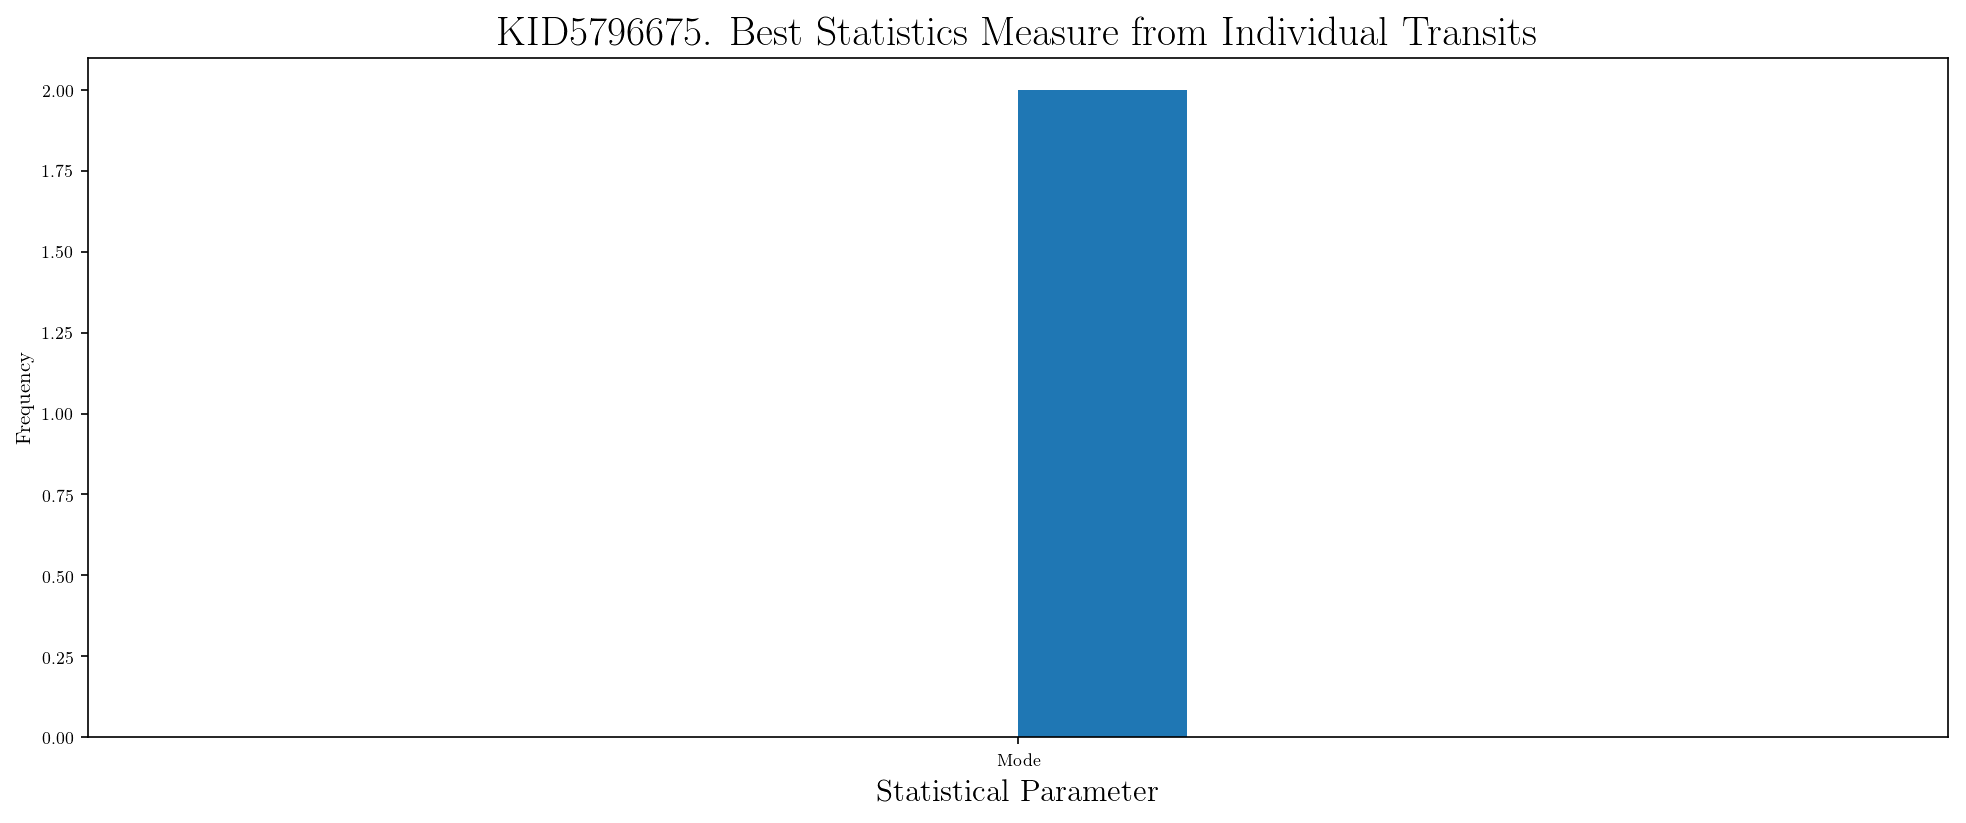

<Figure size 2400x1050 with 0 Axes>

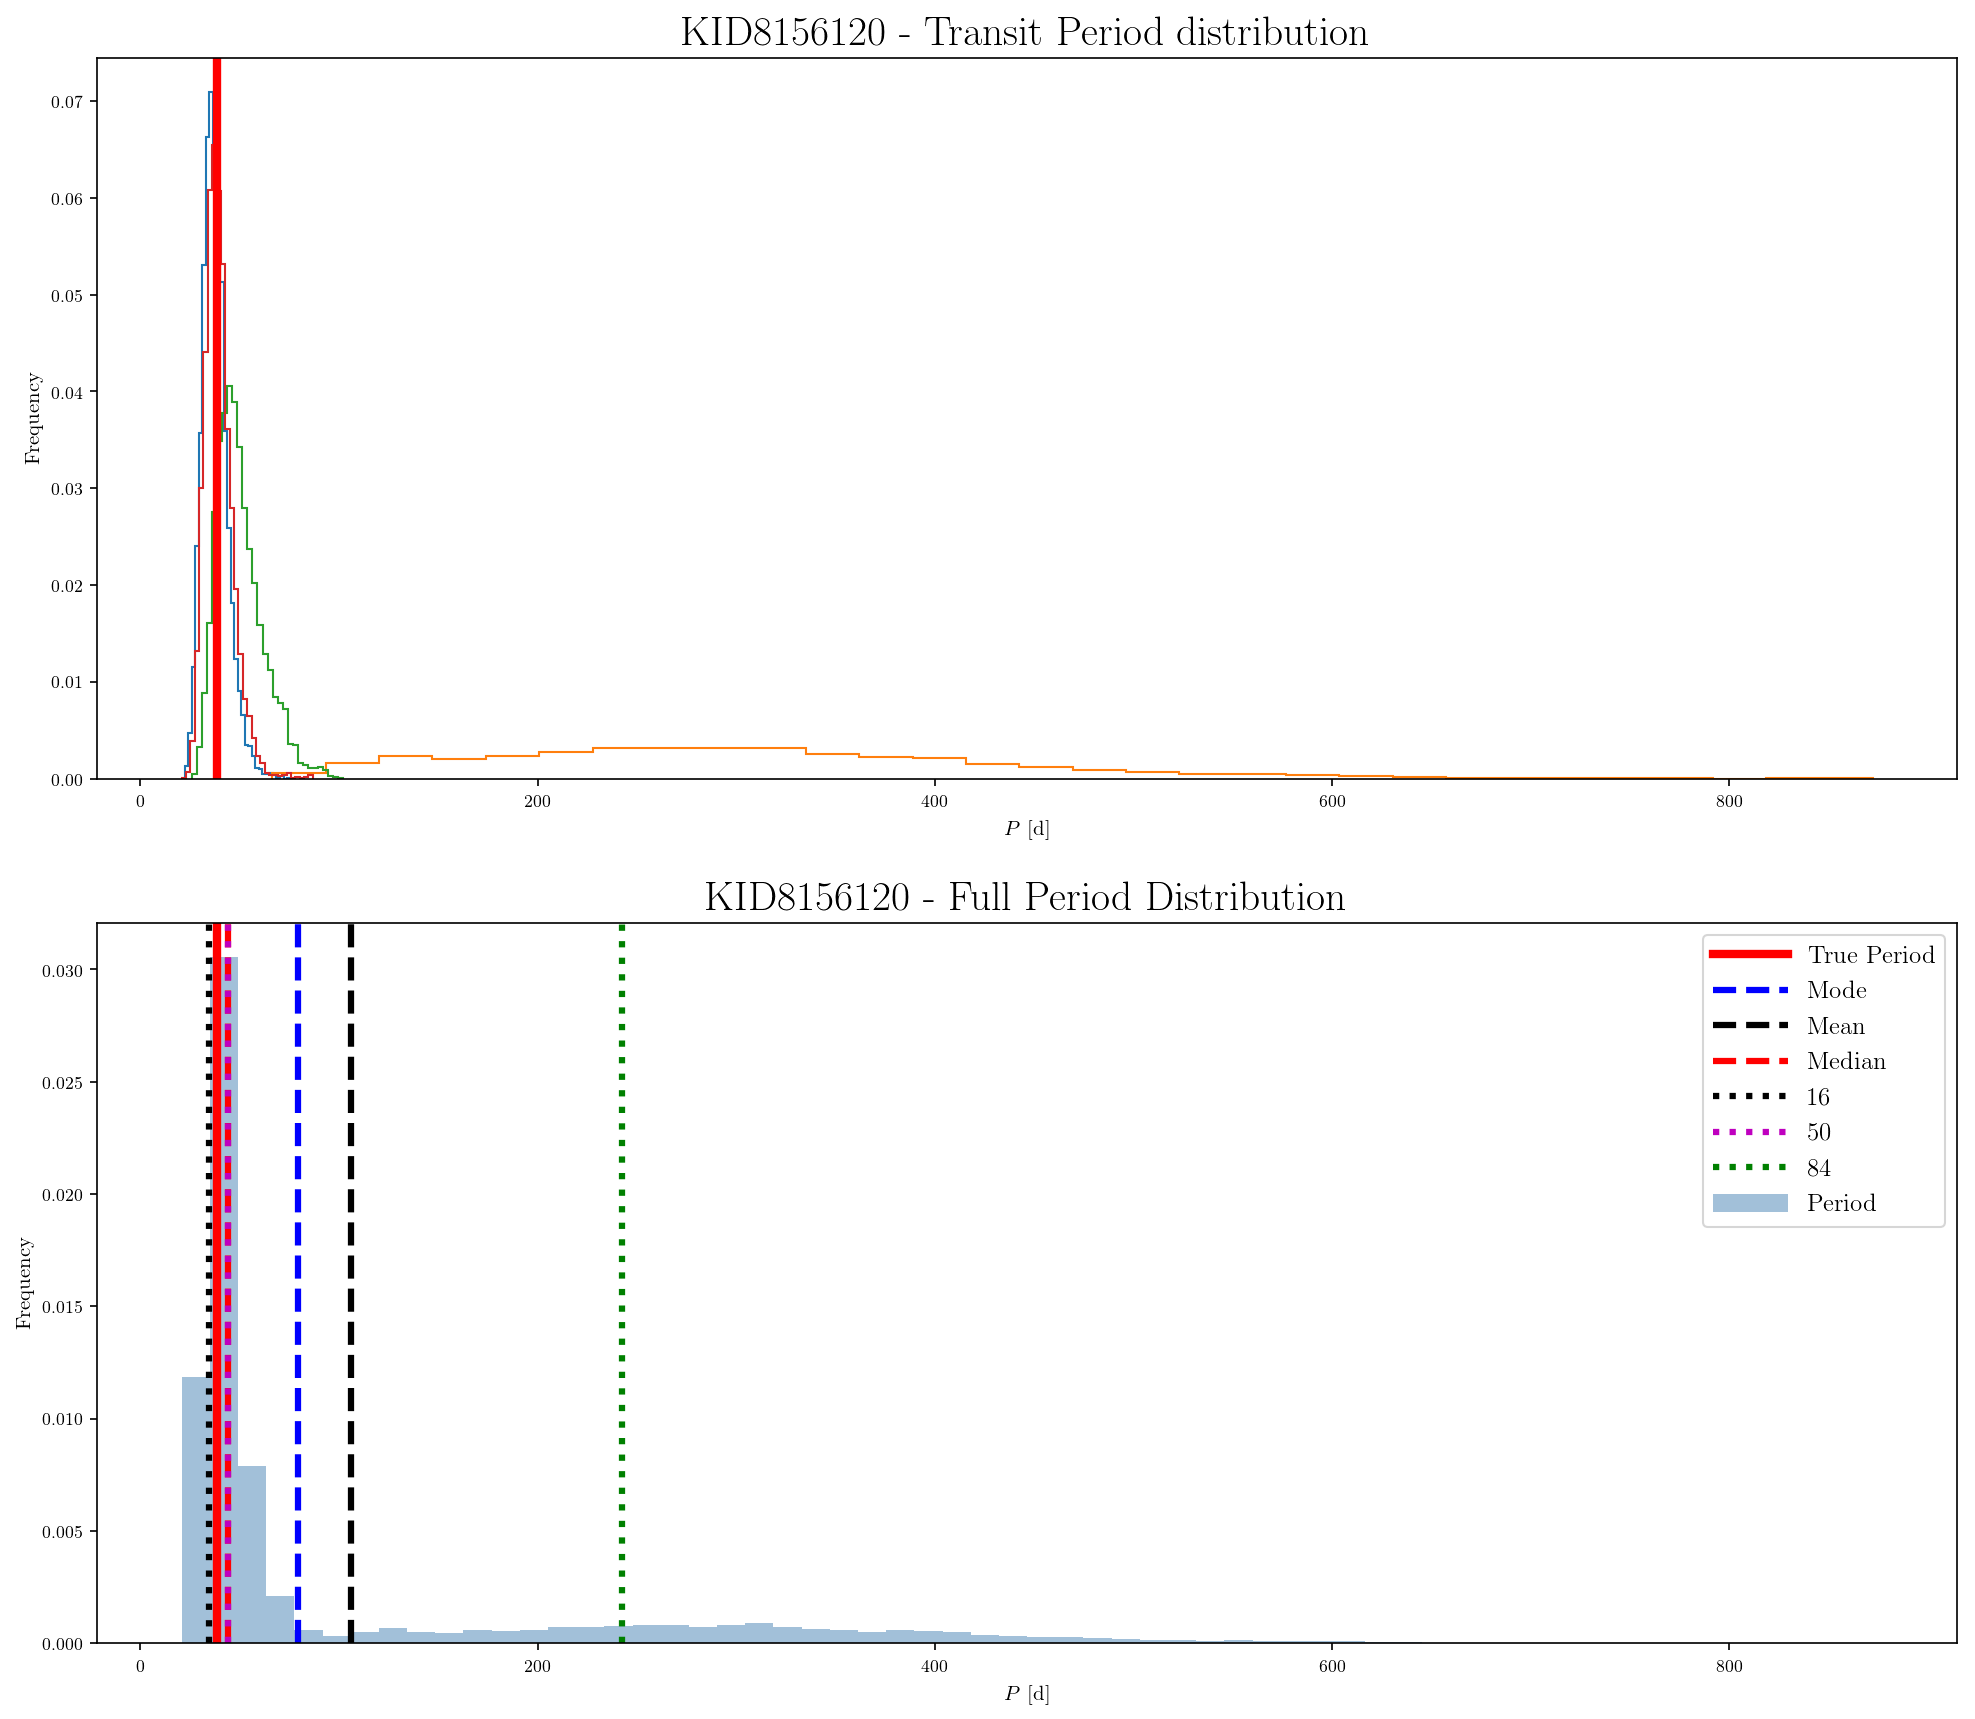

<Figure size 2400x1050 with 0 Axes>

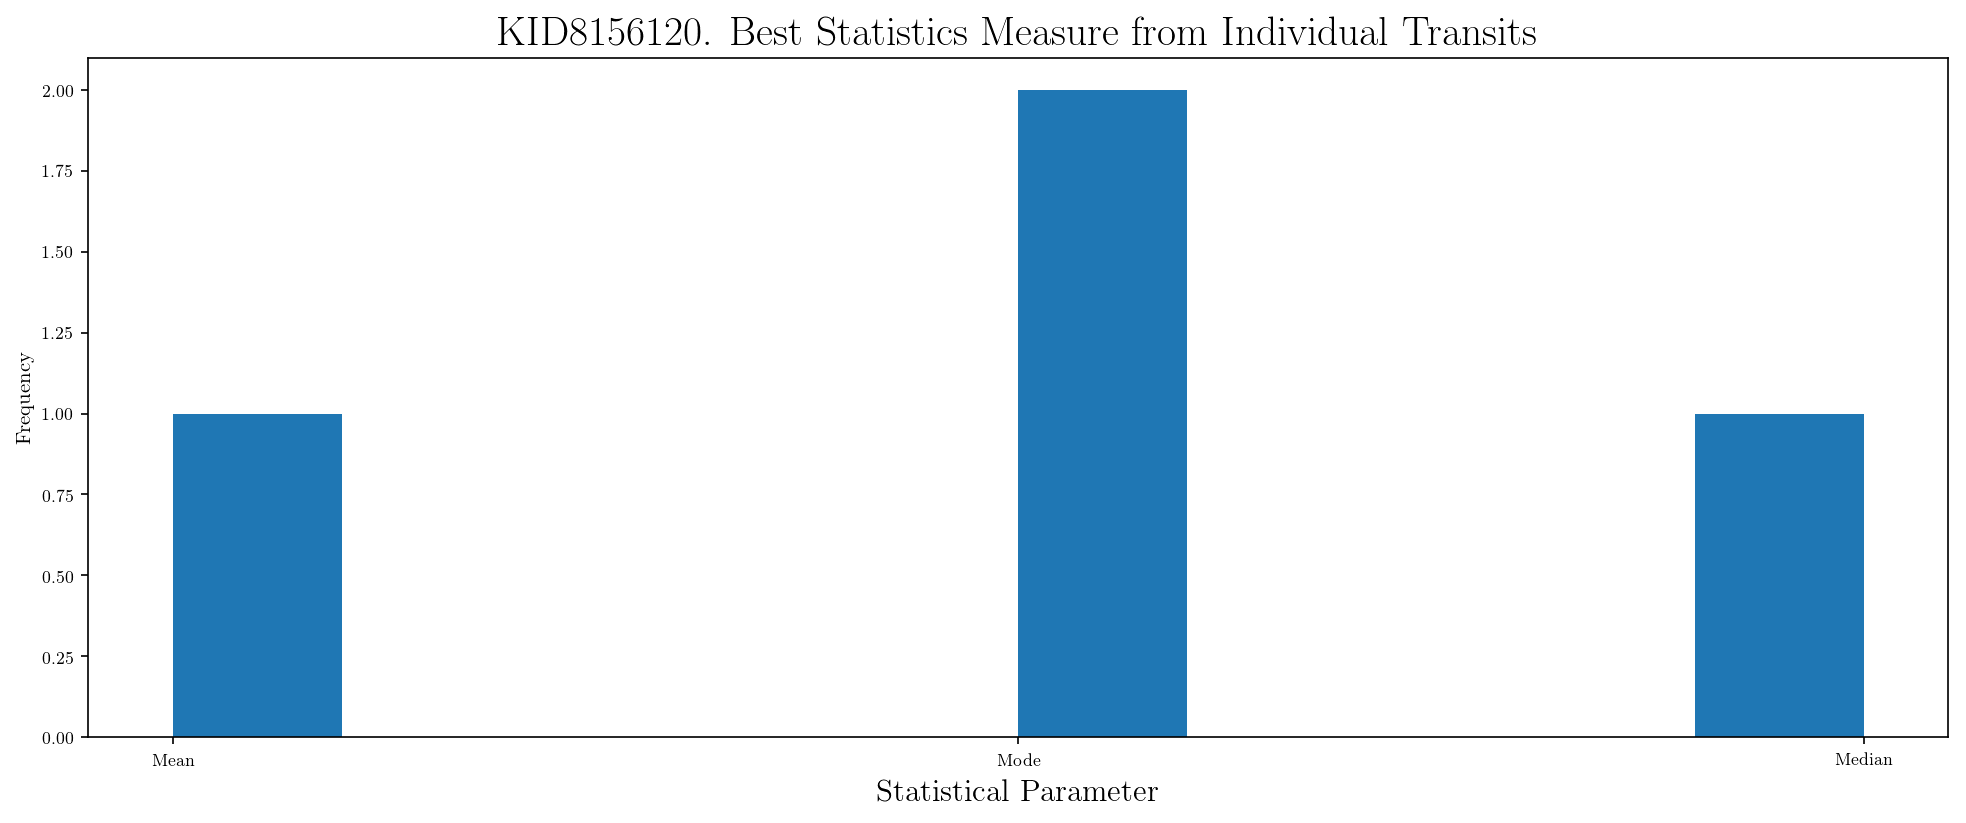

<Figure size 2400x1050 with 0 Axes>

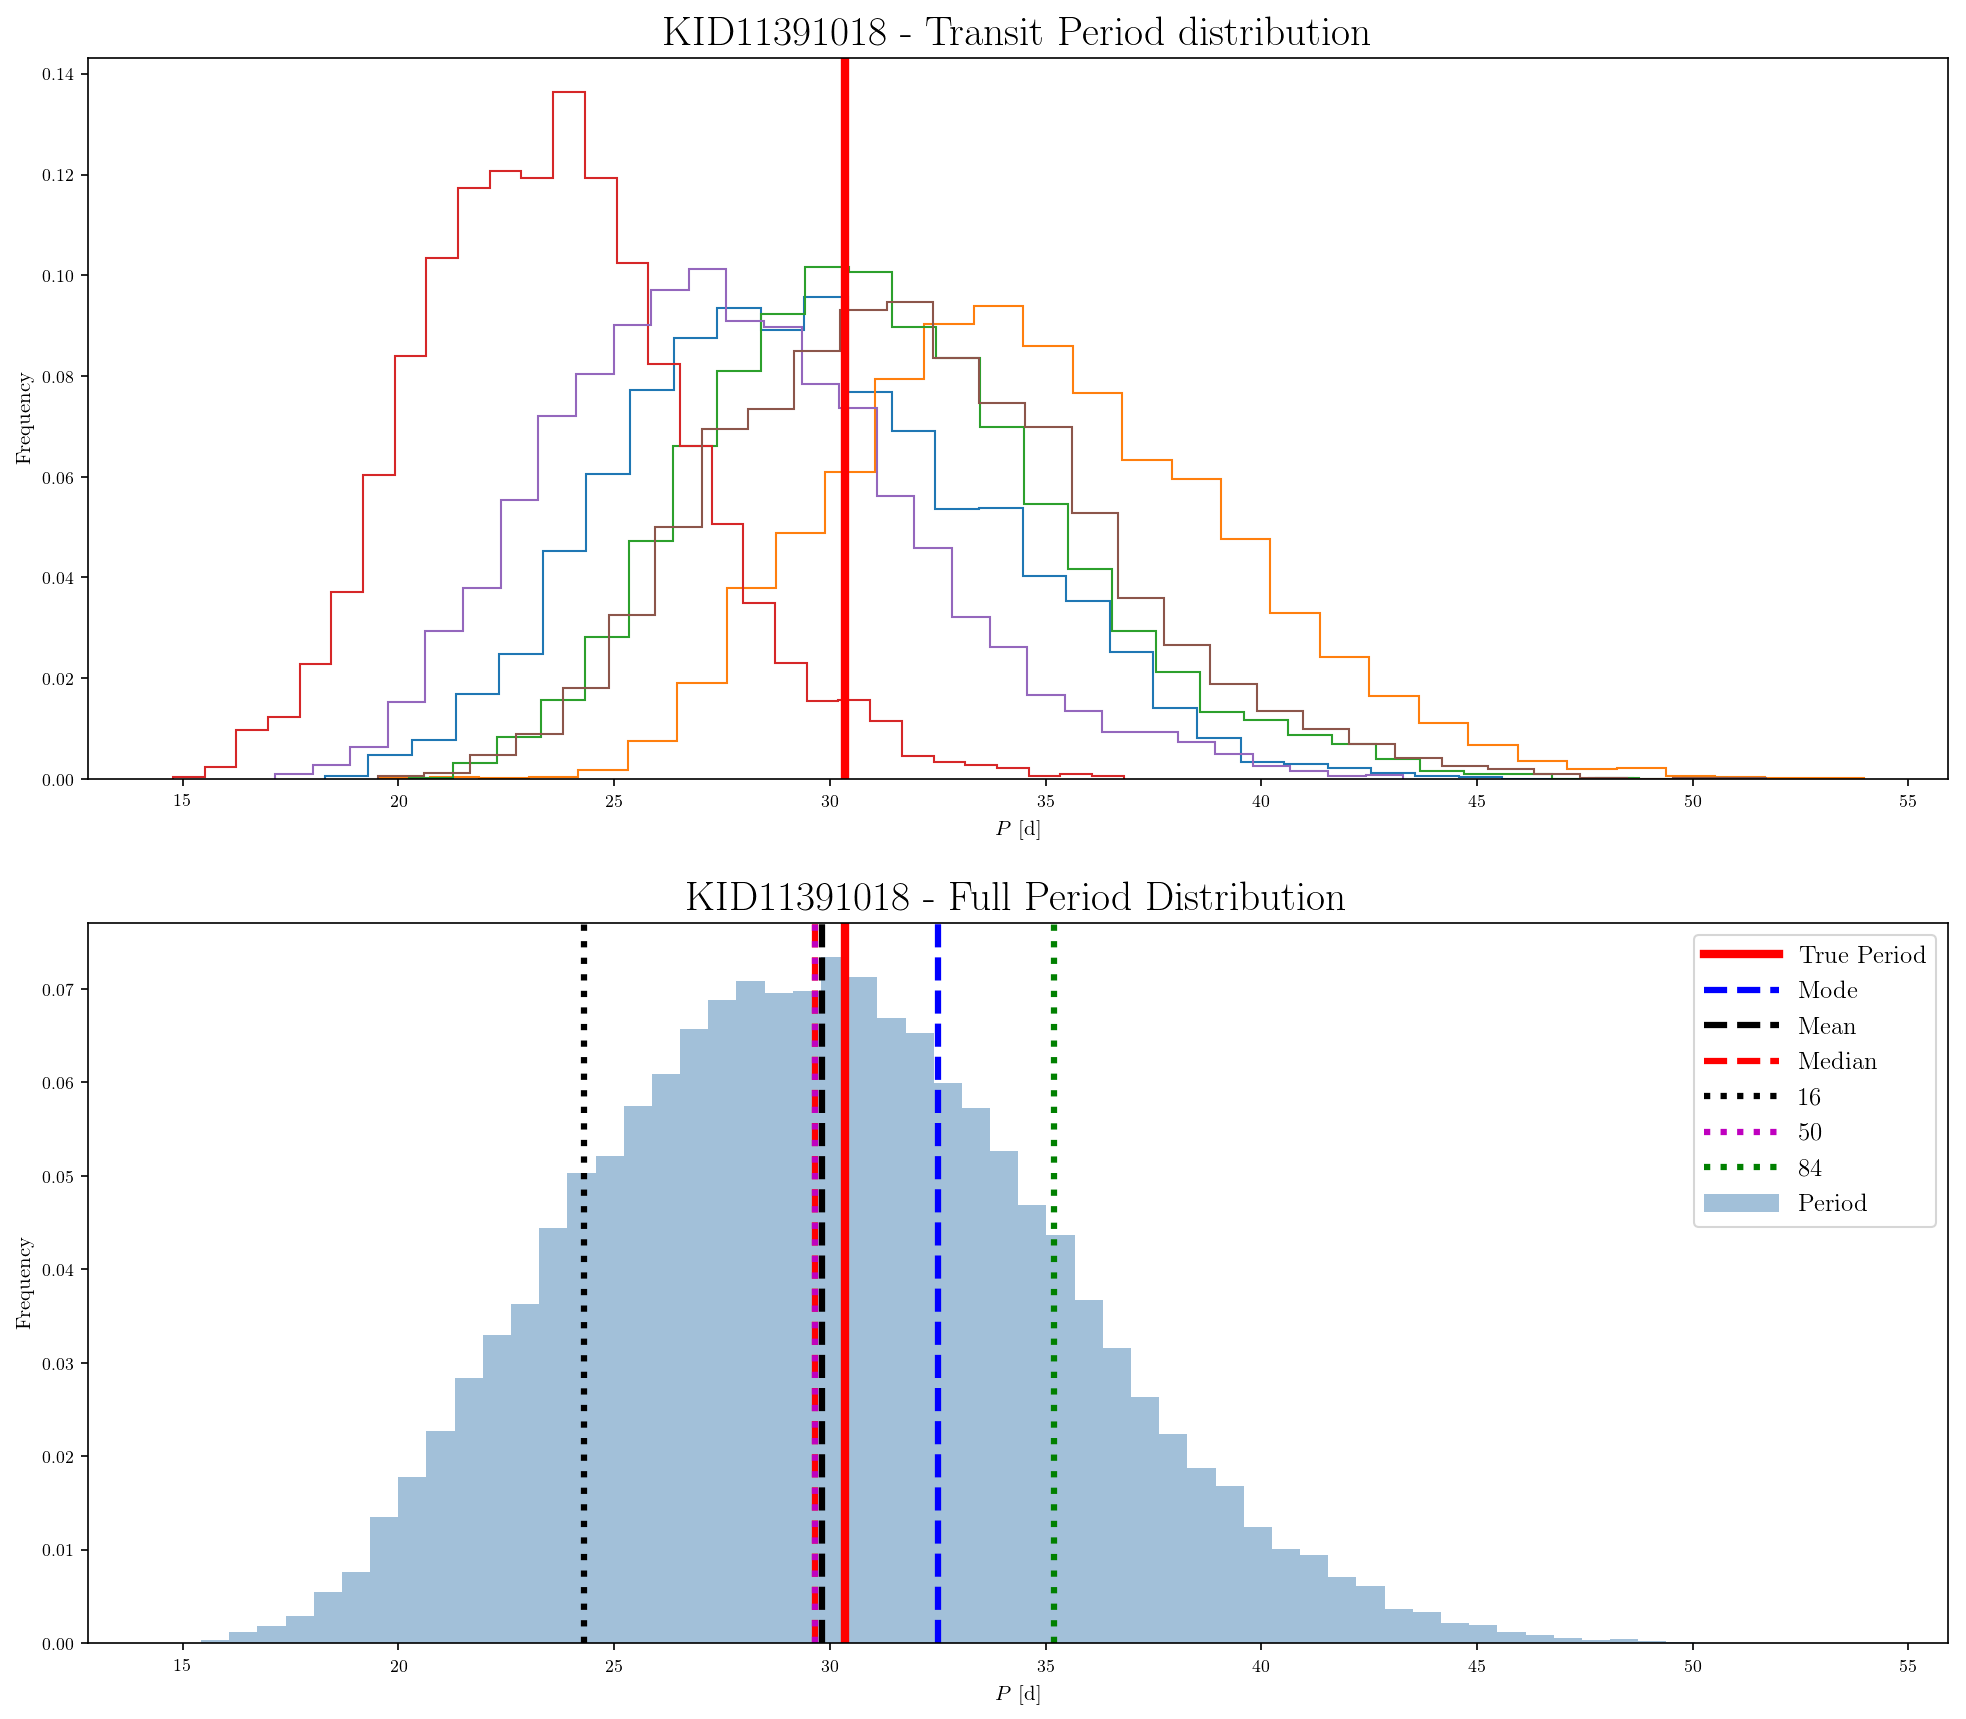

<Figure size 2400x1050 with 0 Axes>

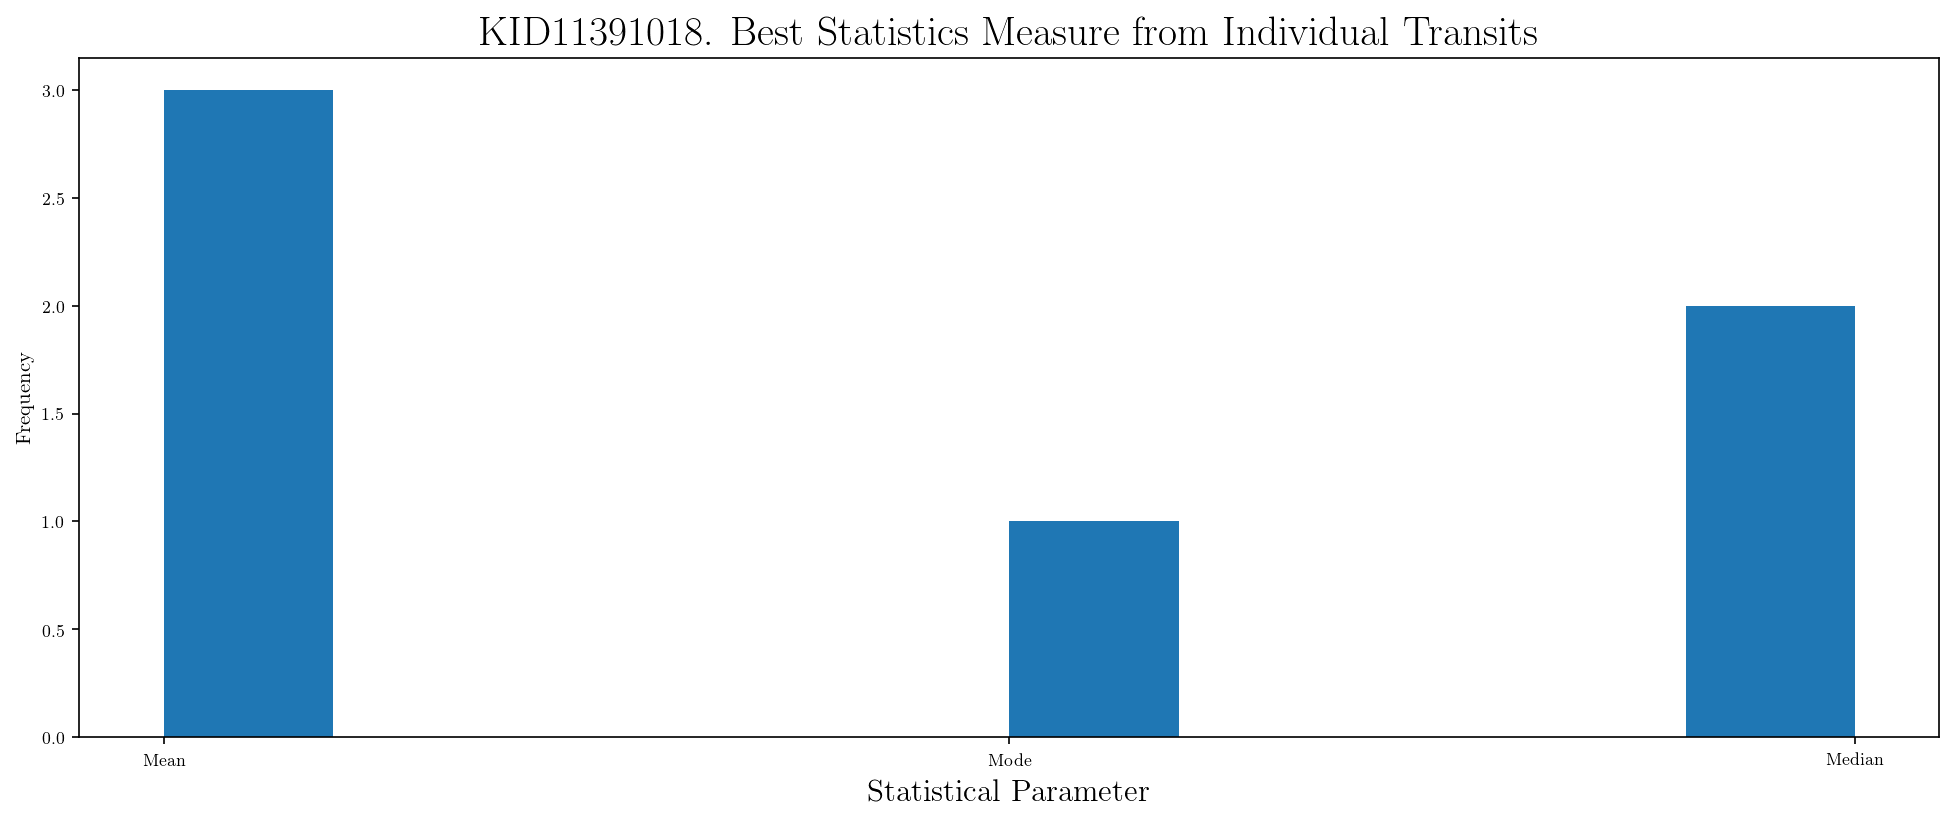

<Figure size 2400x1050 with 0 Axes>

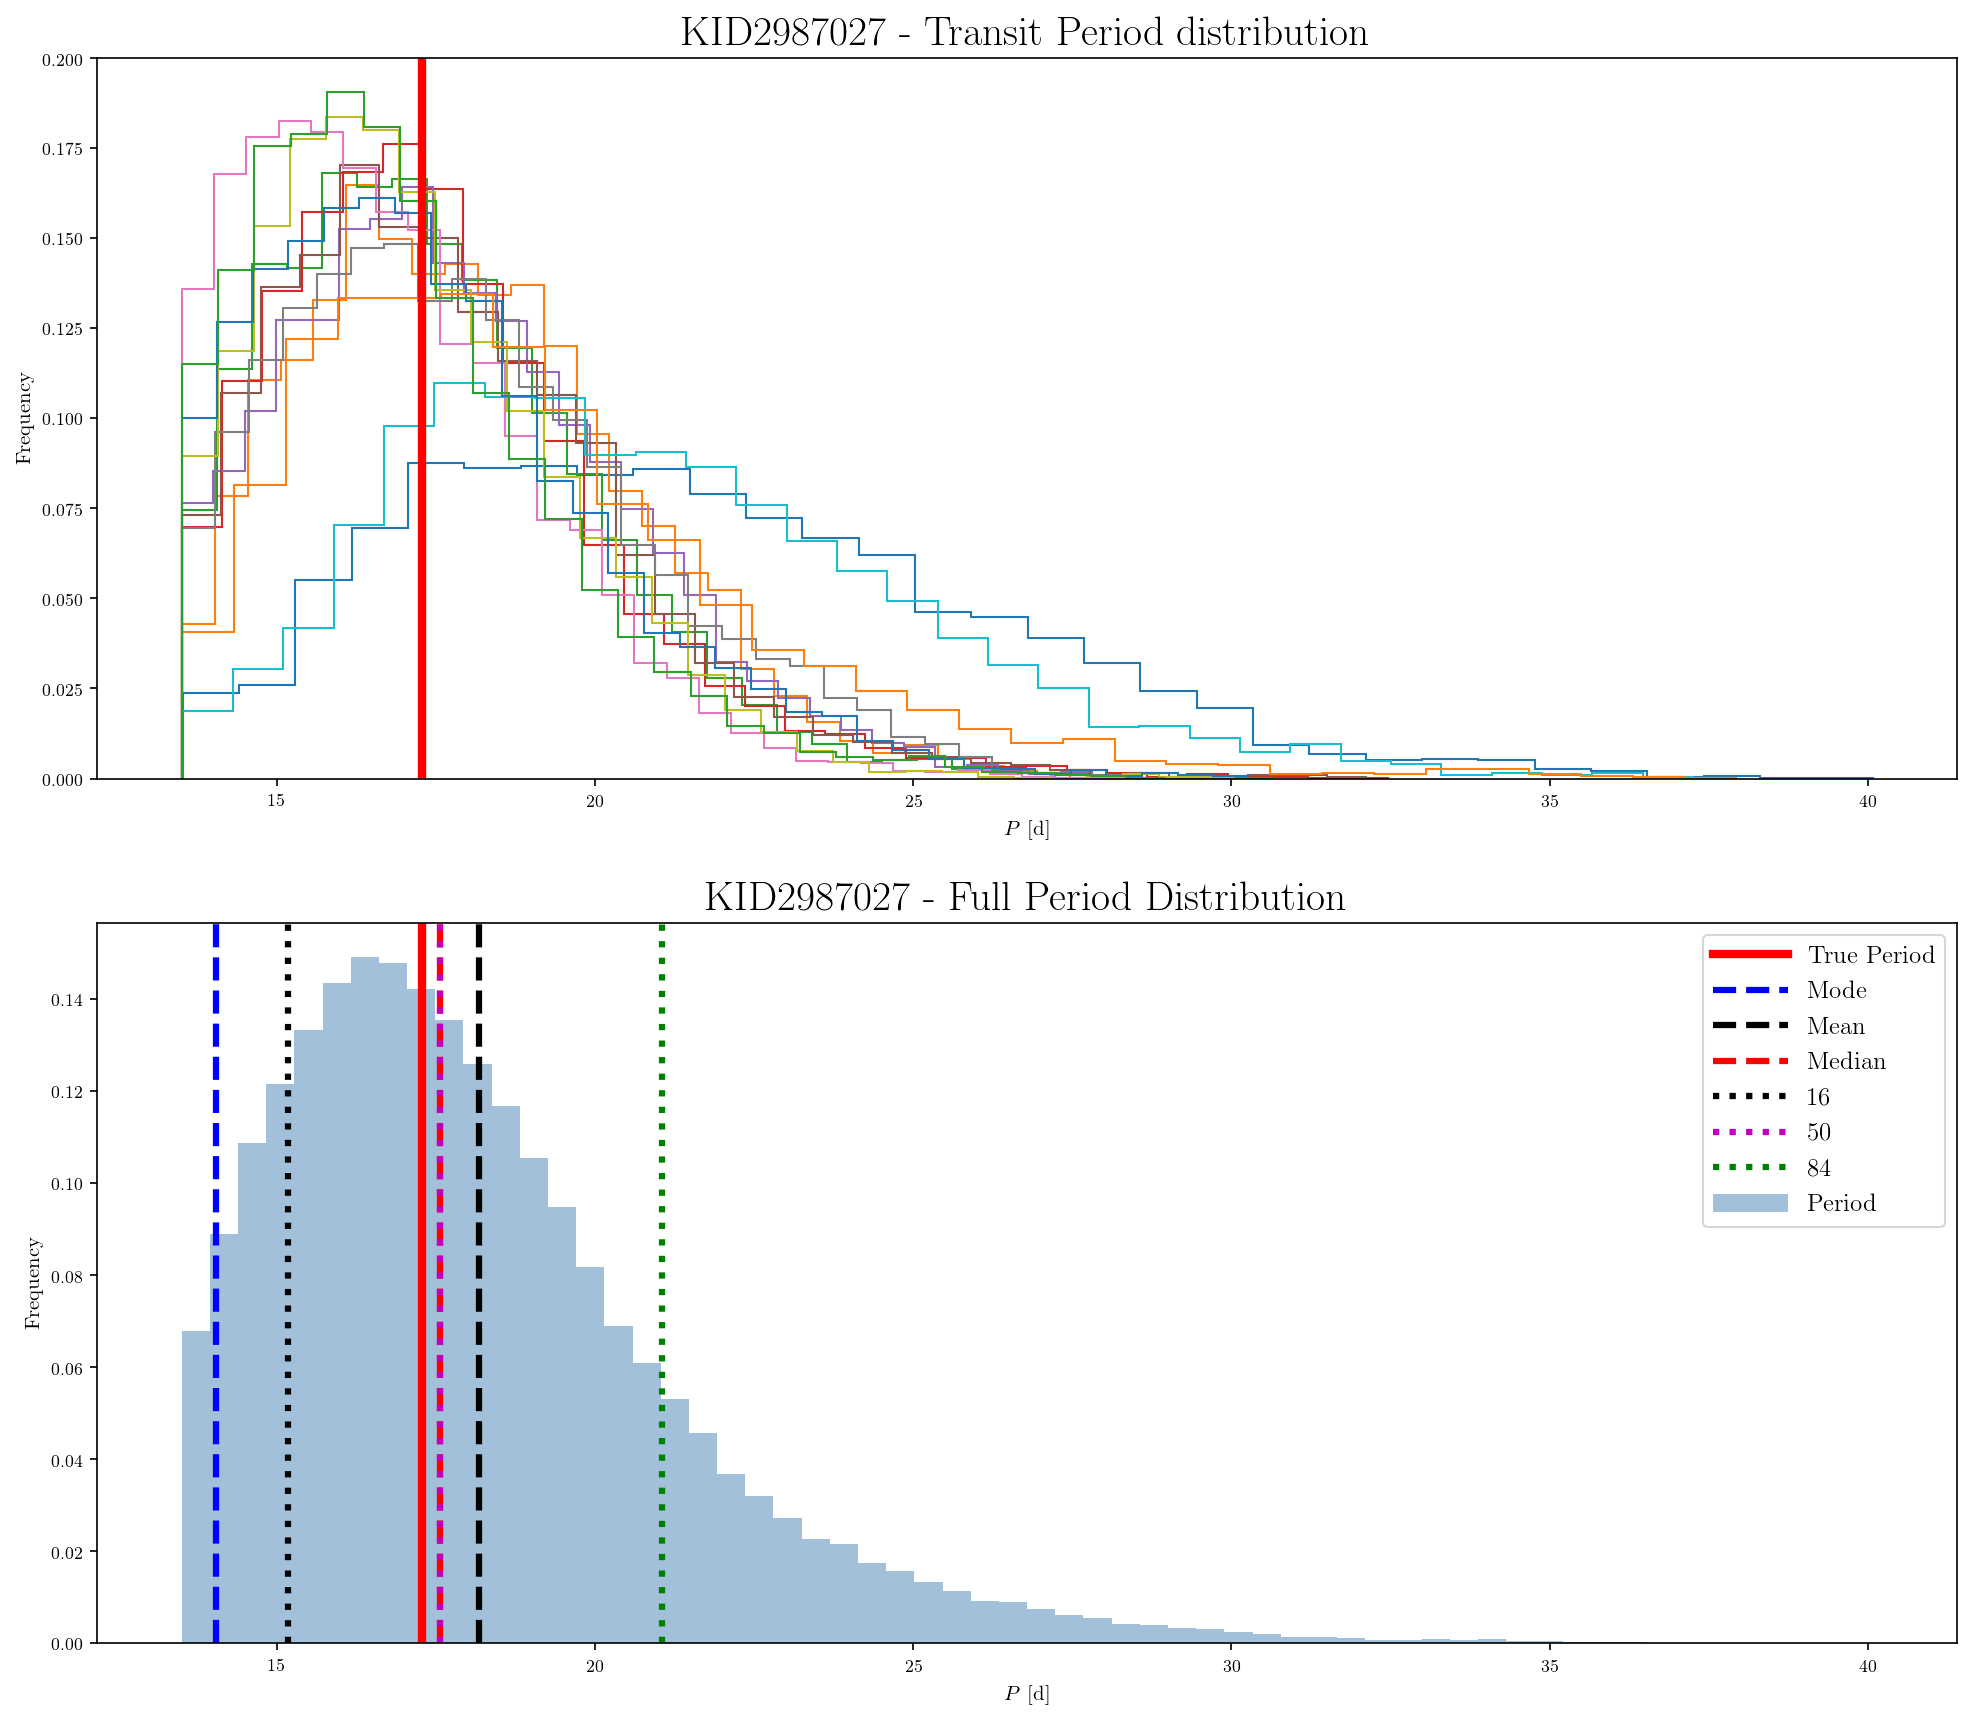

<Figure size 2400x1050 with 0 Axes>

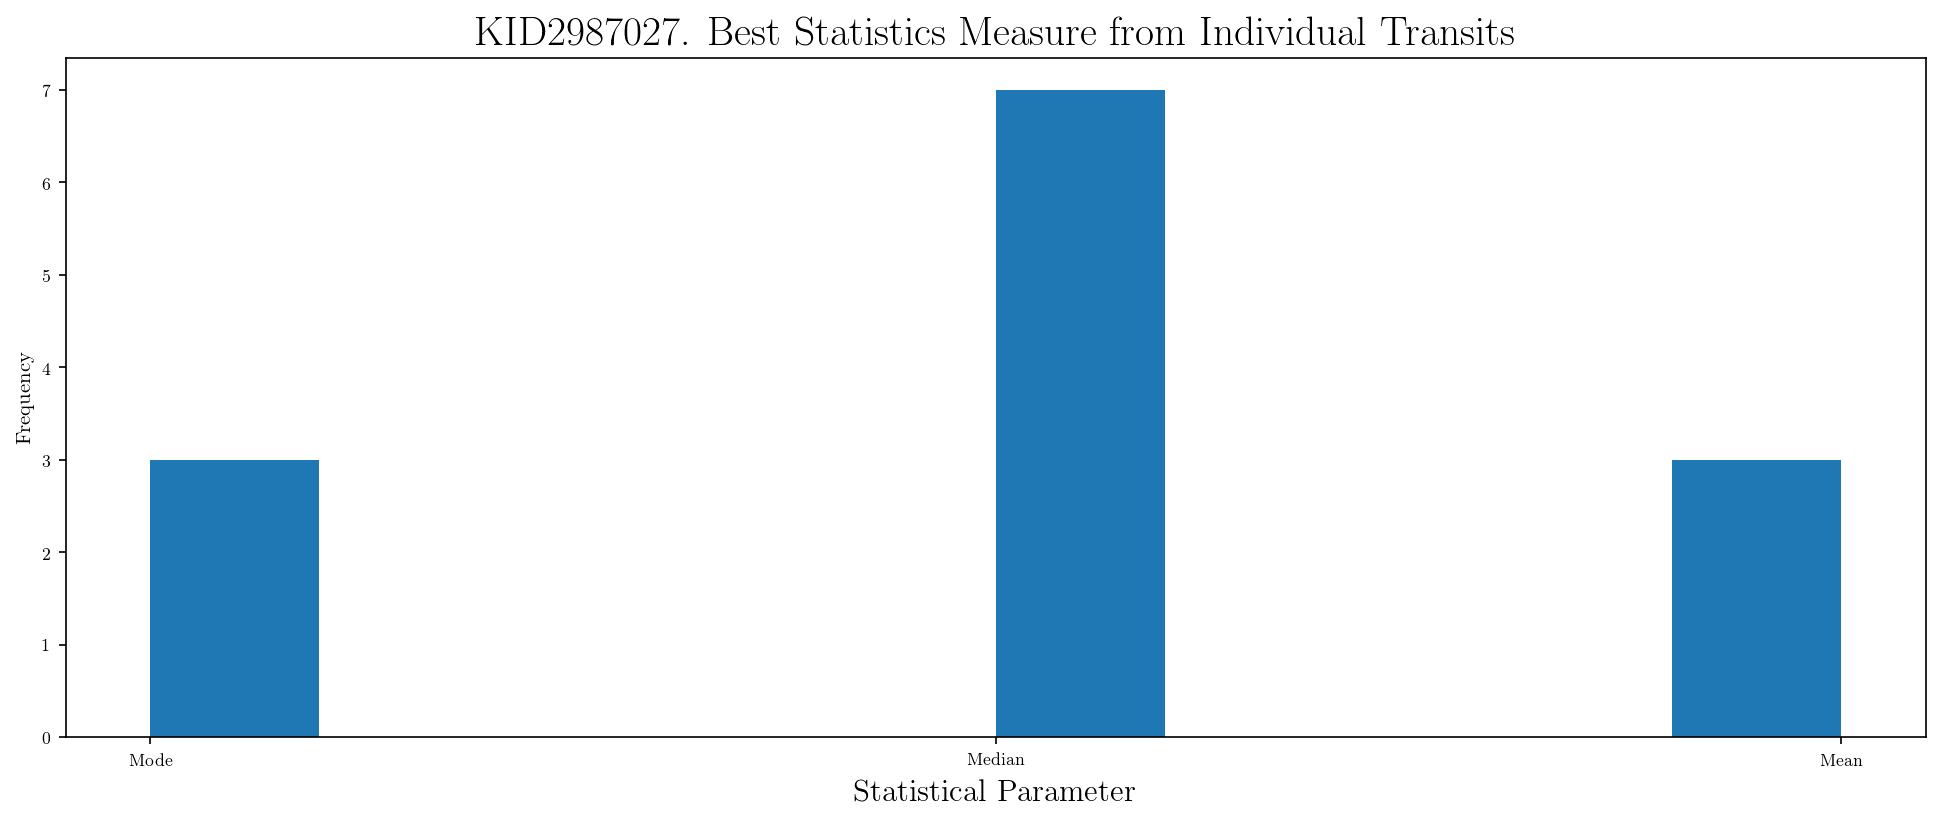

<Figure size 2400x1050 with 0 Axes>

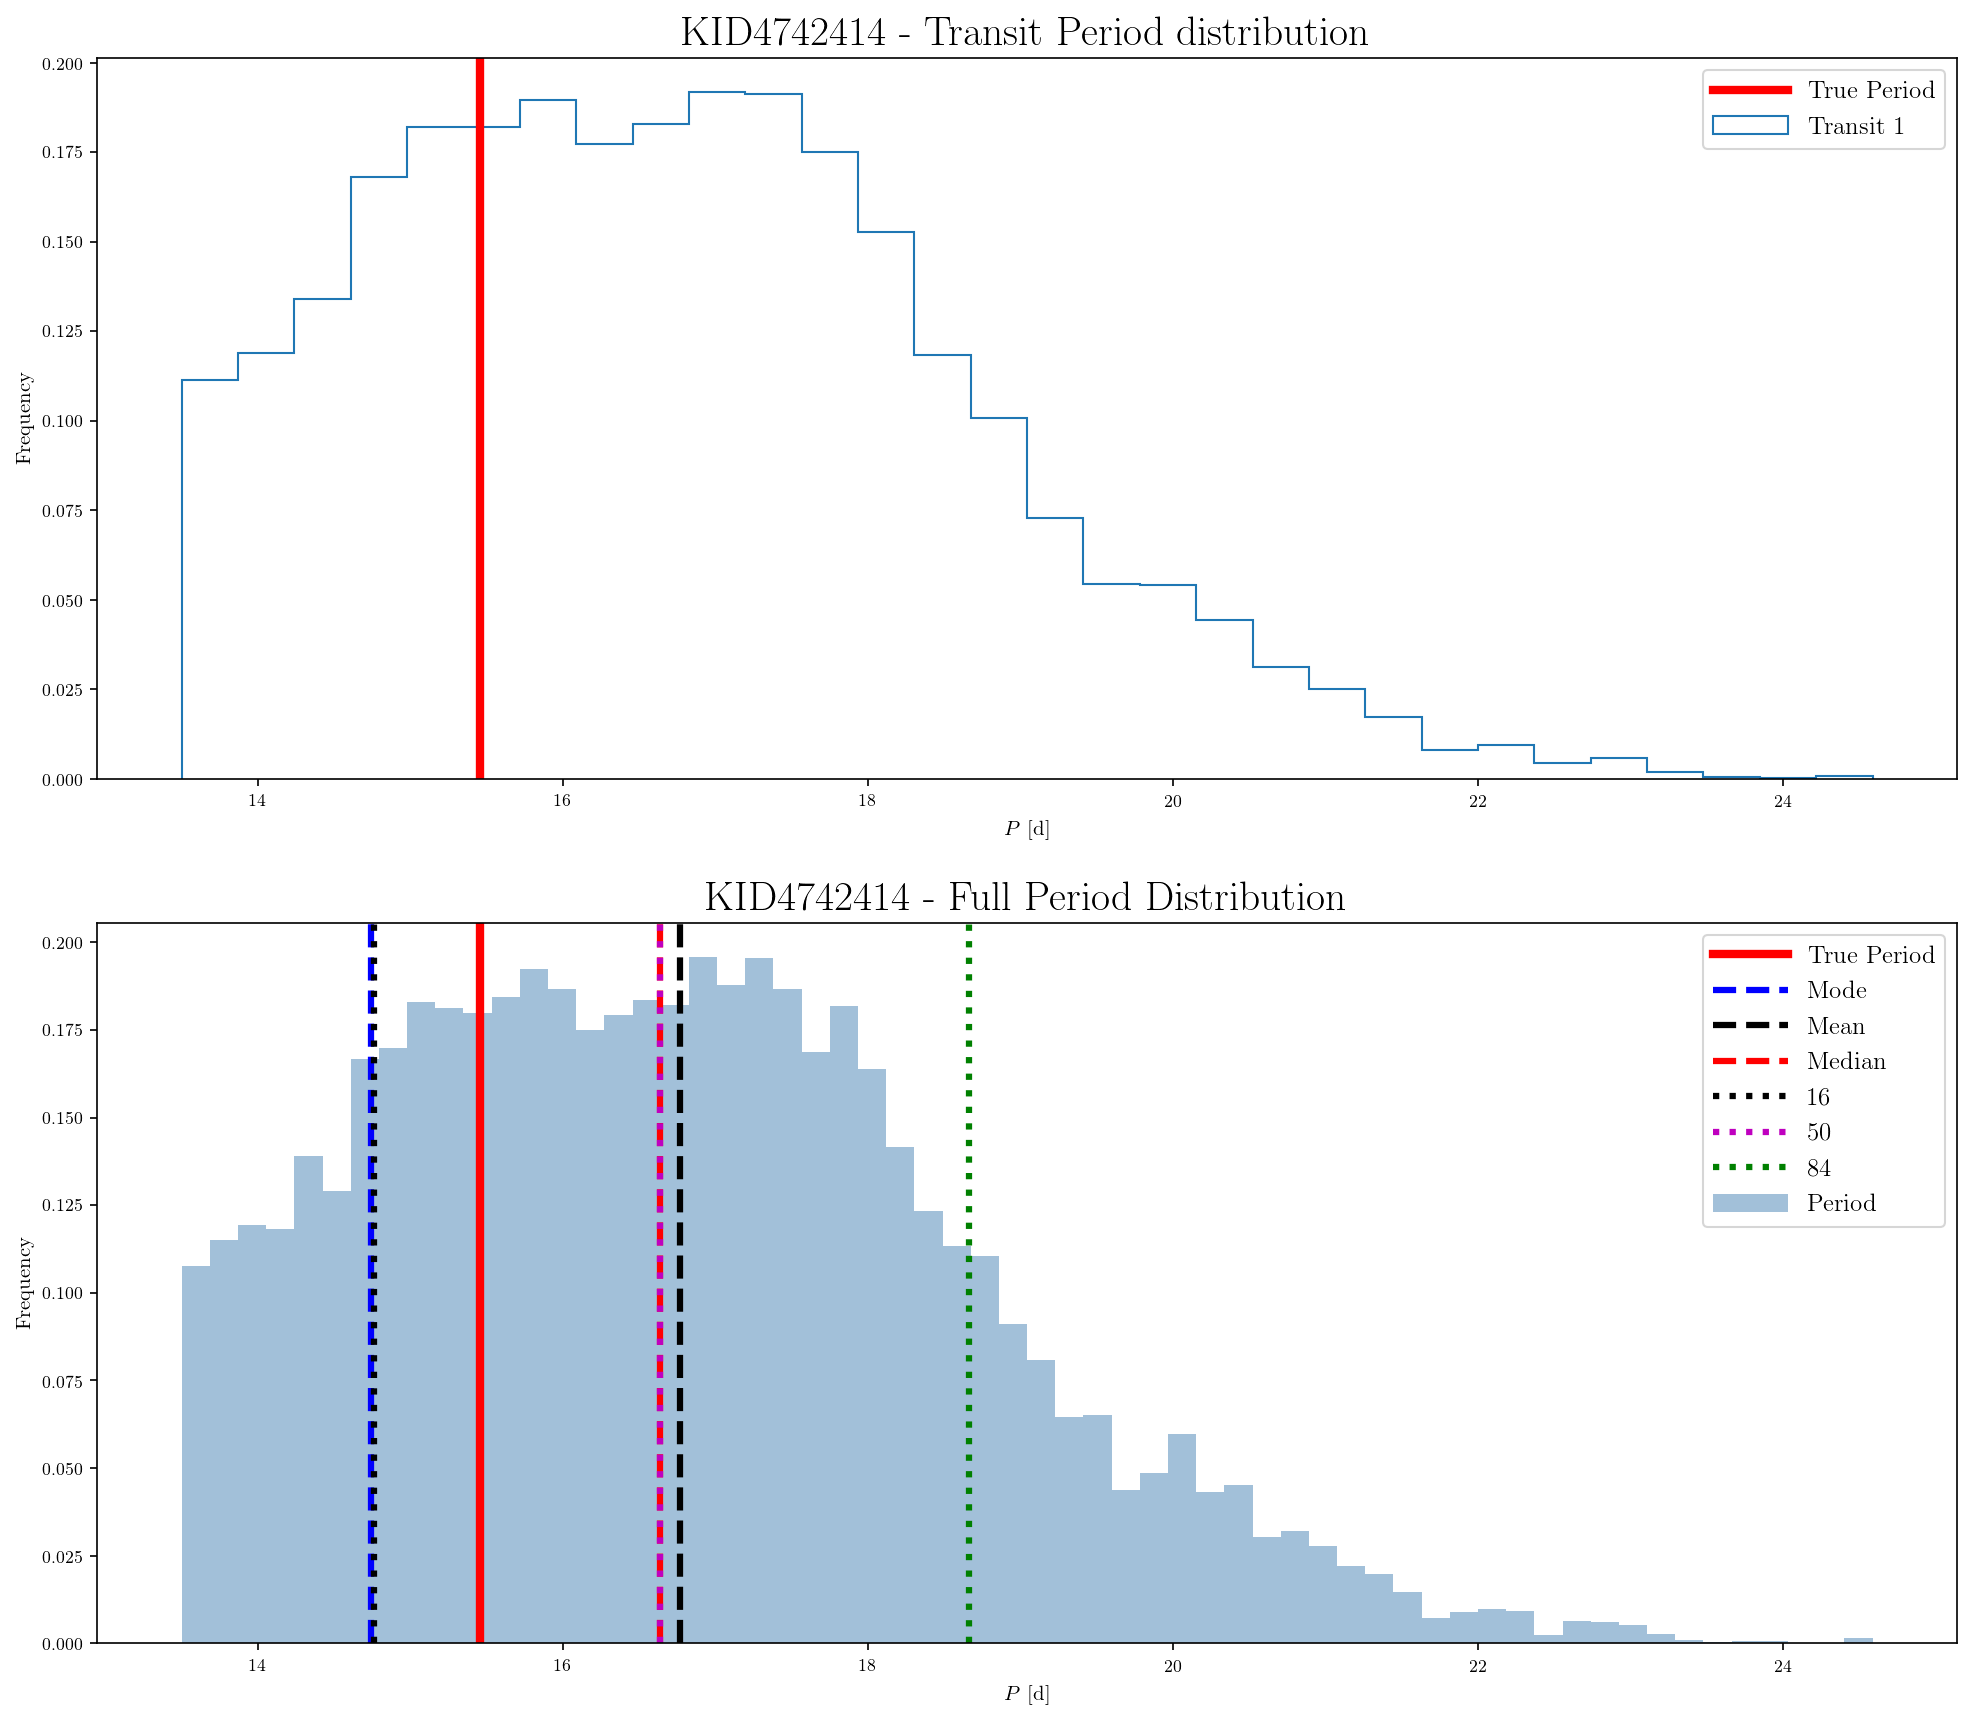

<Figure size 2400x1050 with 0 Axes>

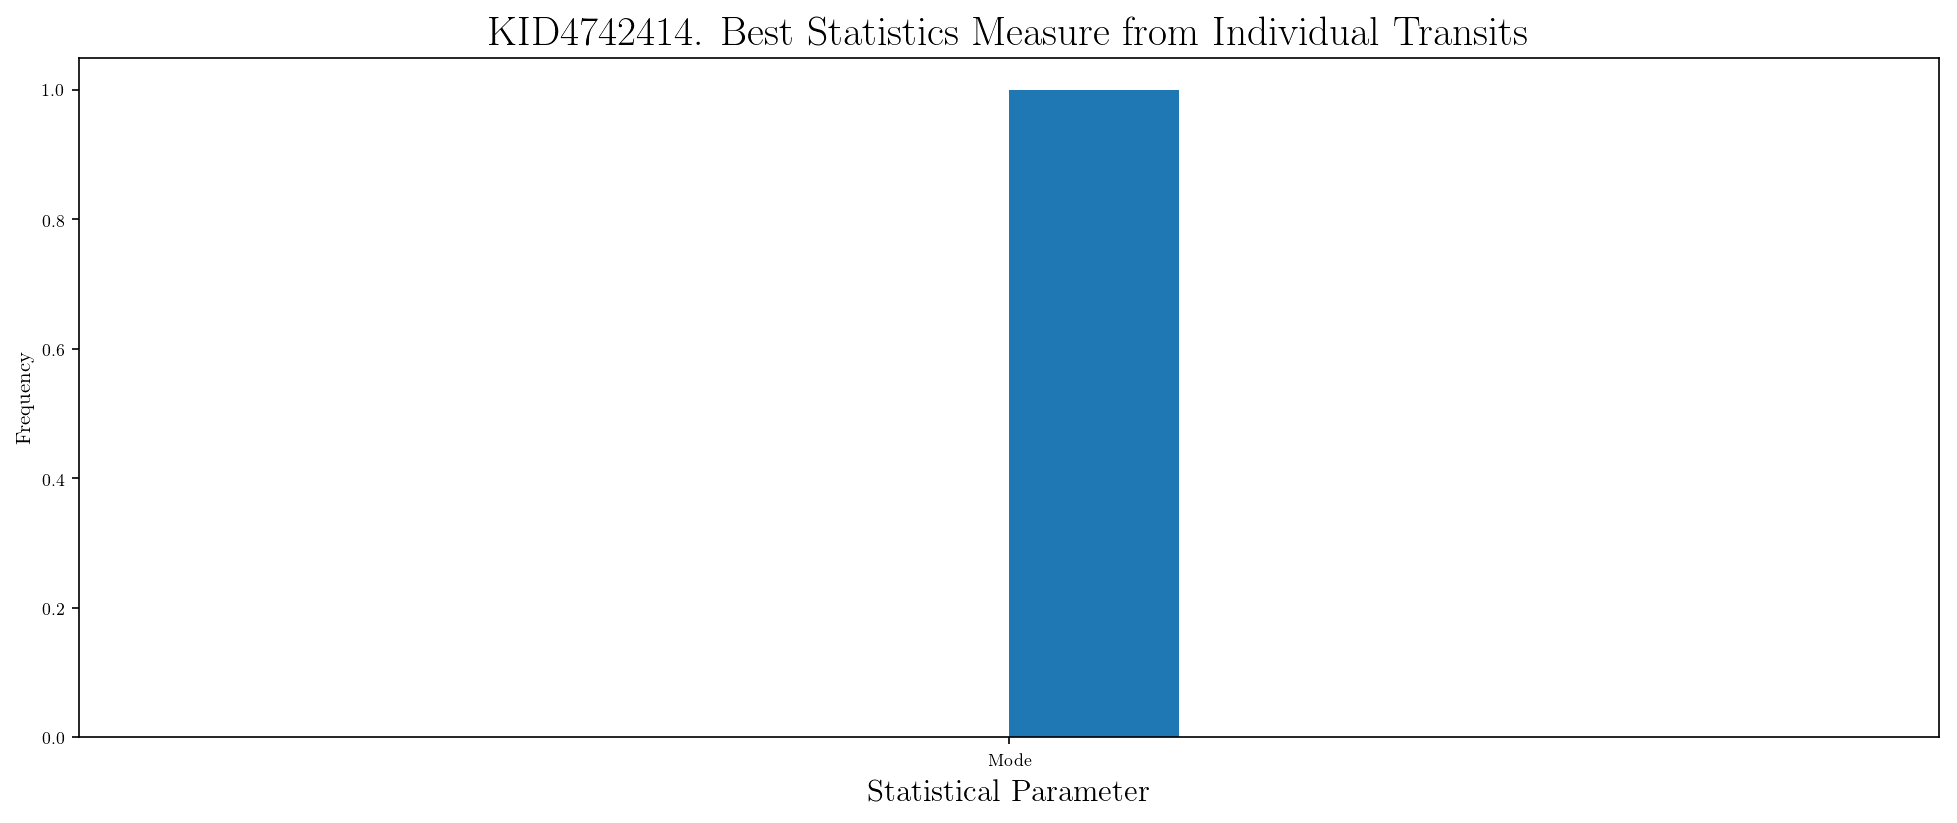

<Figure size 2400x1050 with 0 Axes>

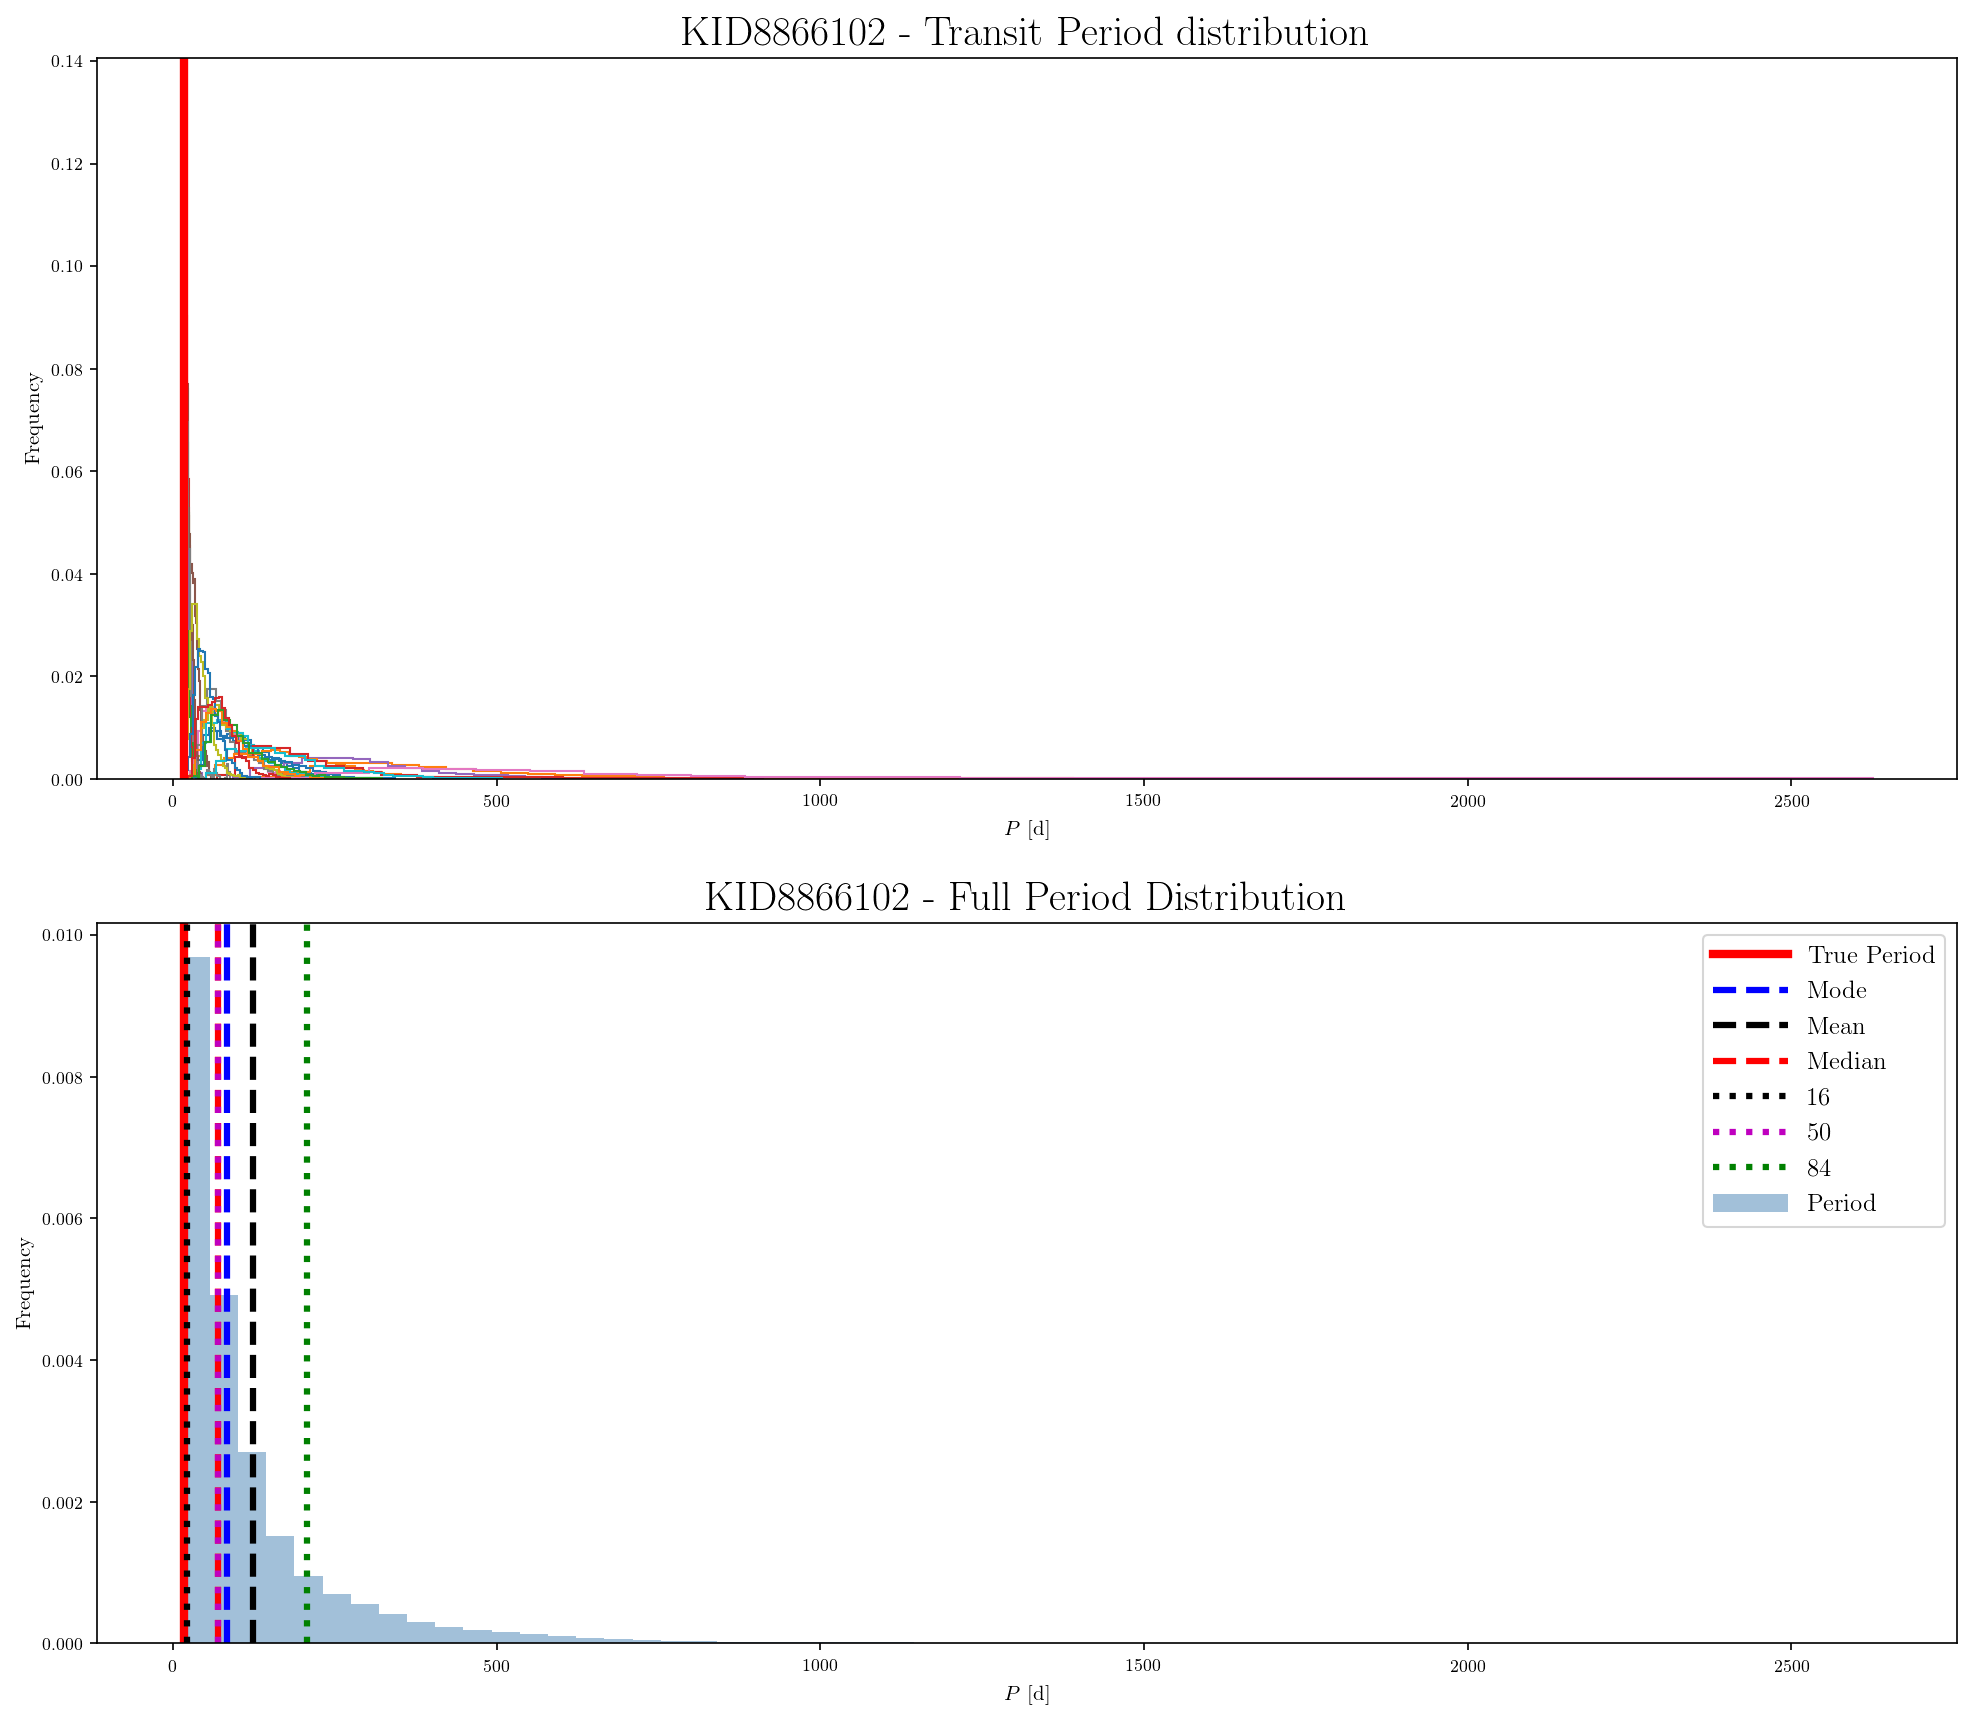

<Figure size 2400x1050 with 0 Axes>

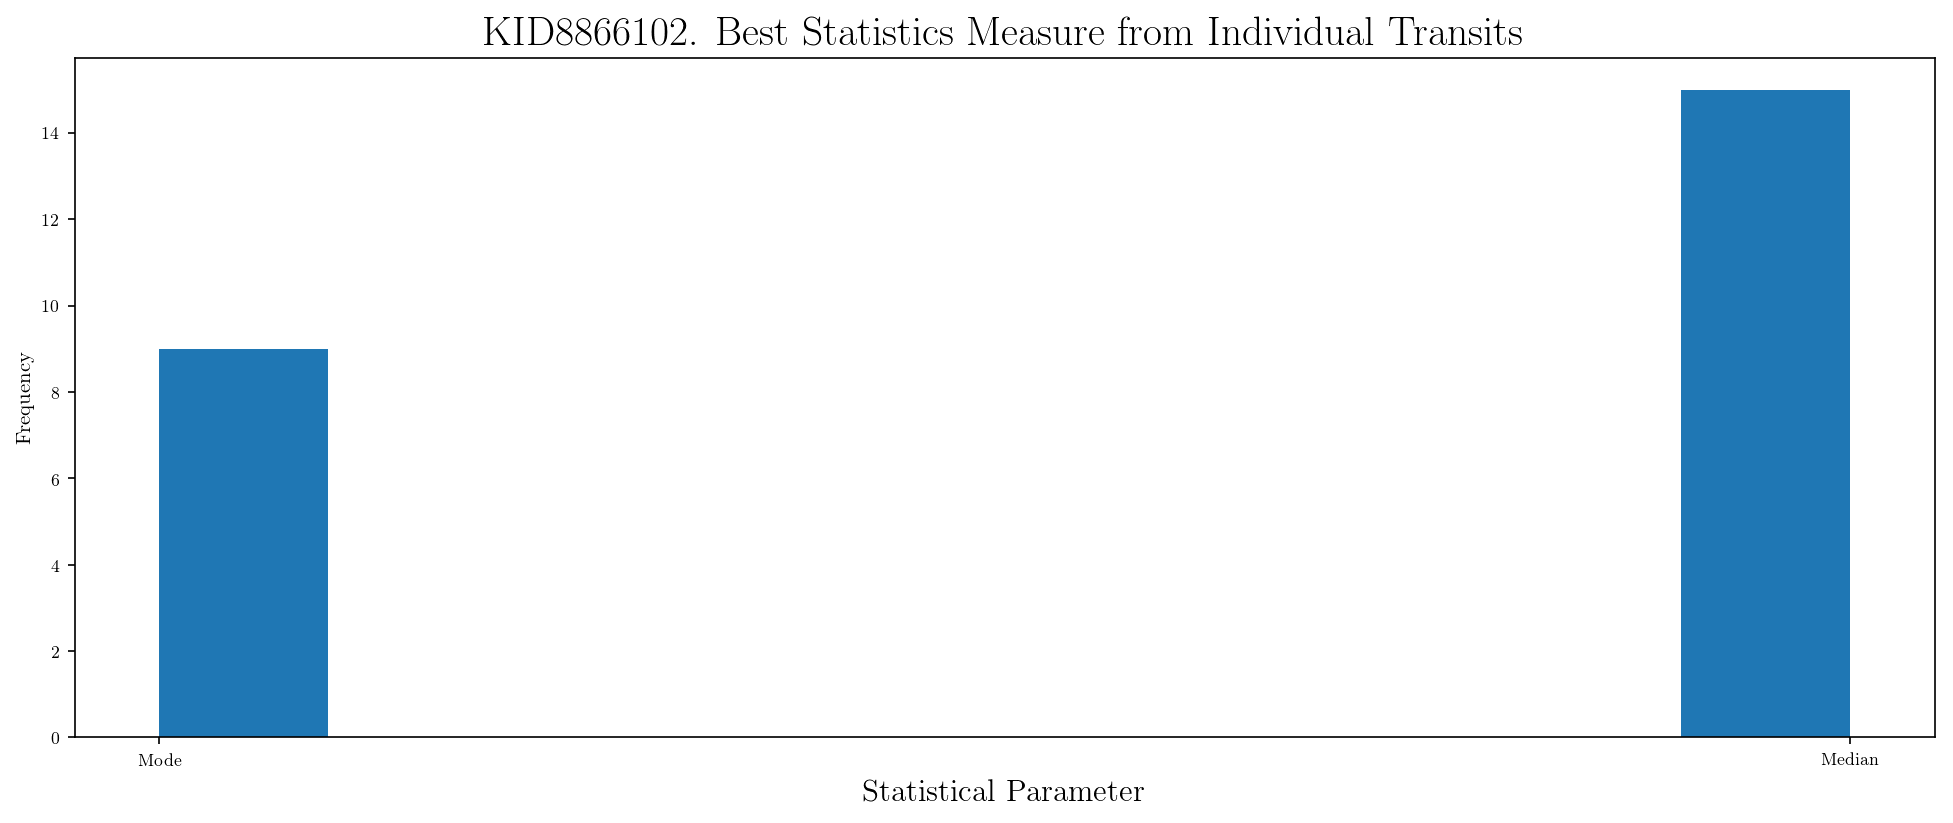

<Figure size 2400x1050 with 0 Axes>

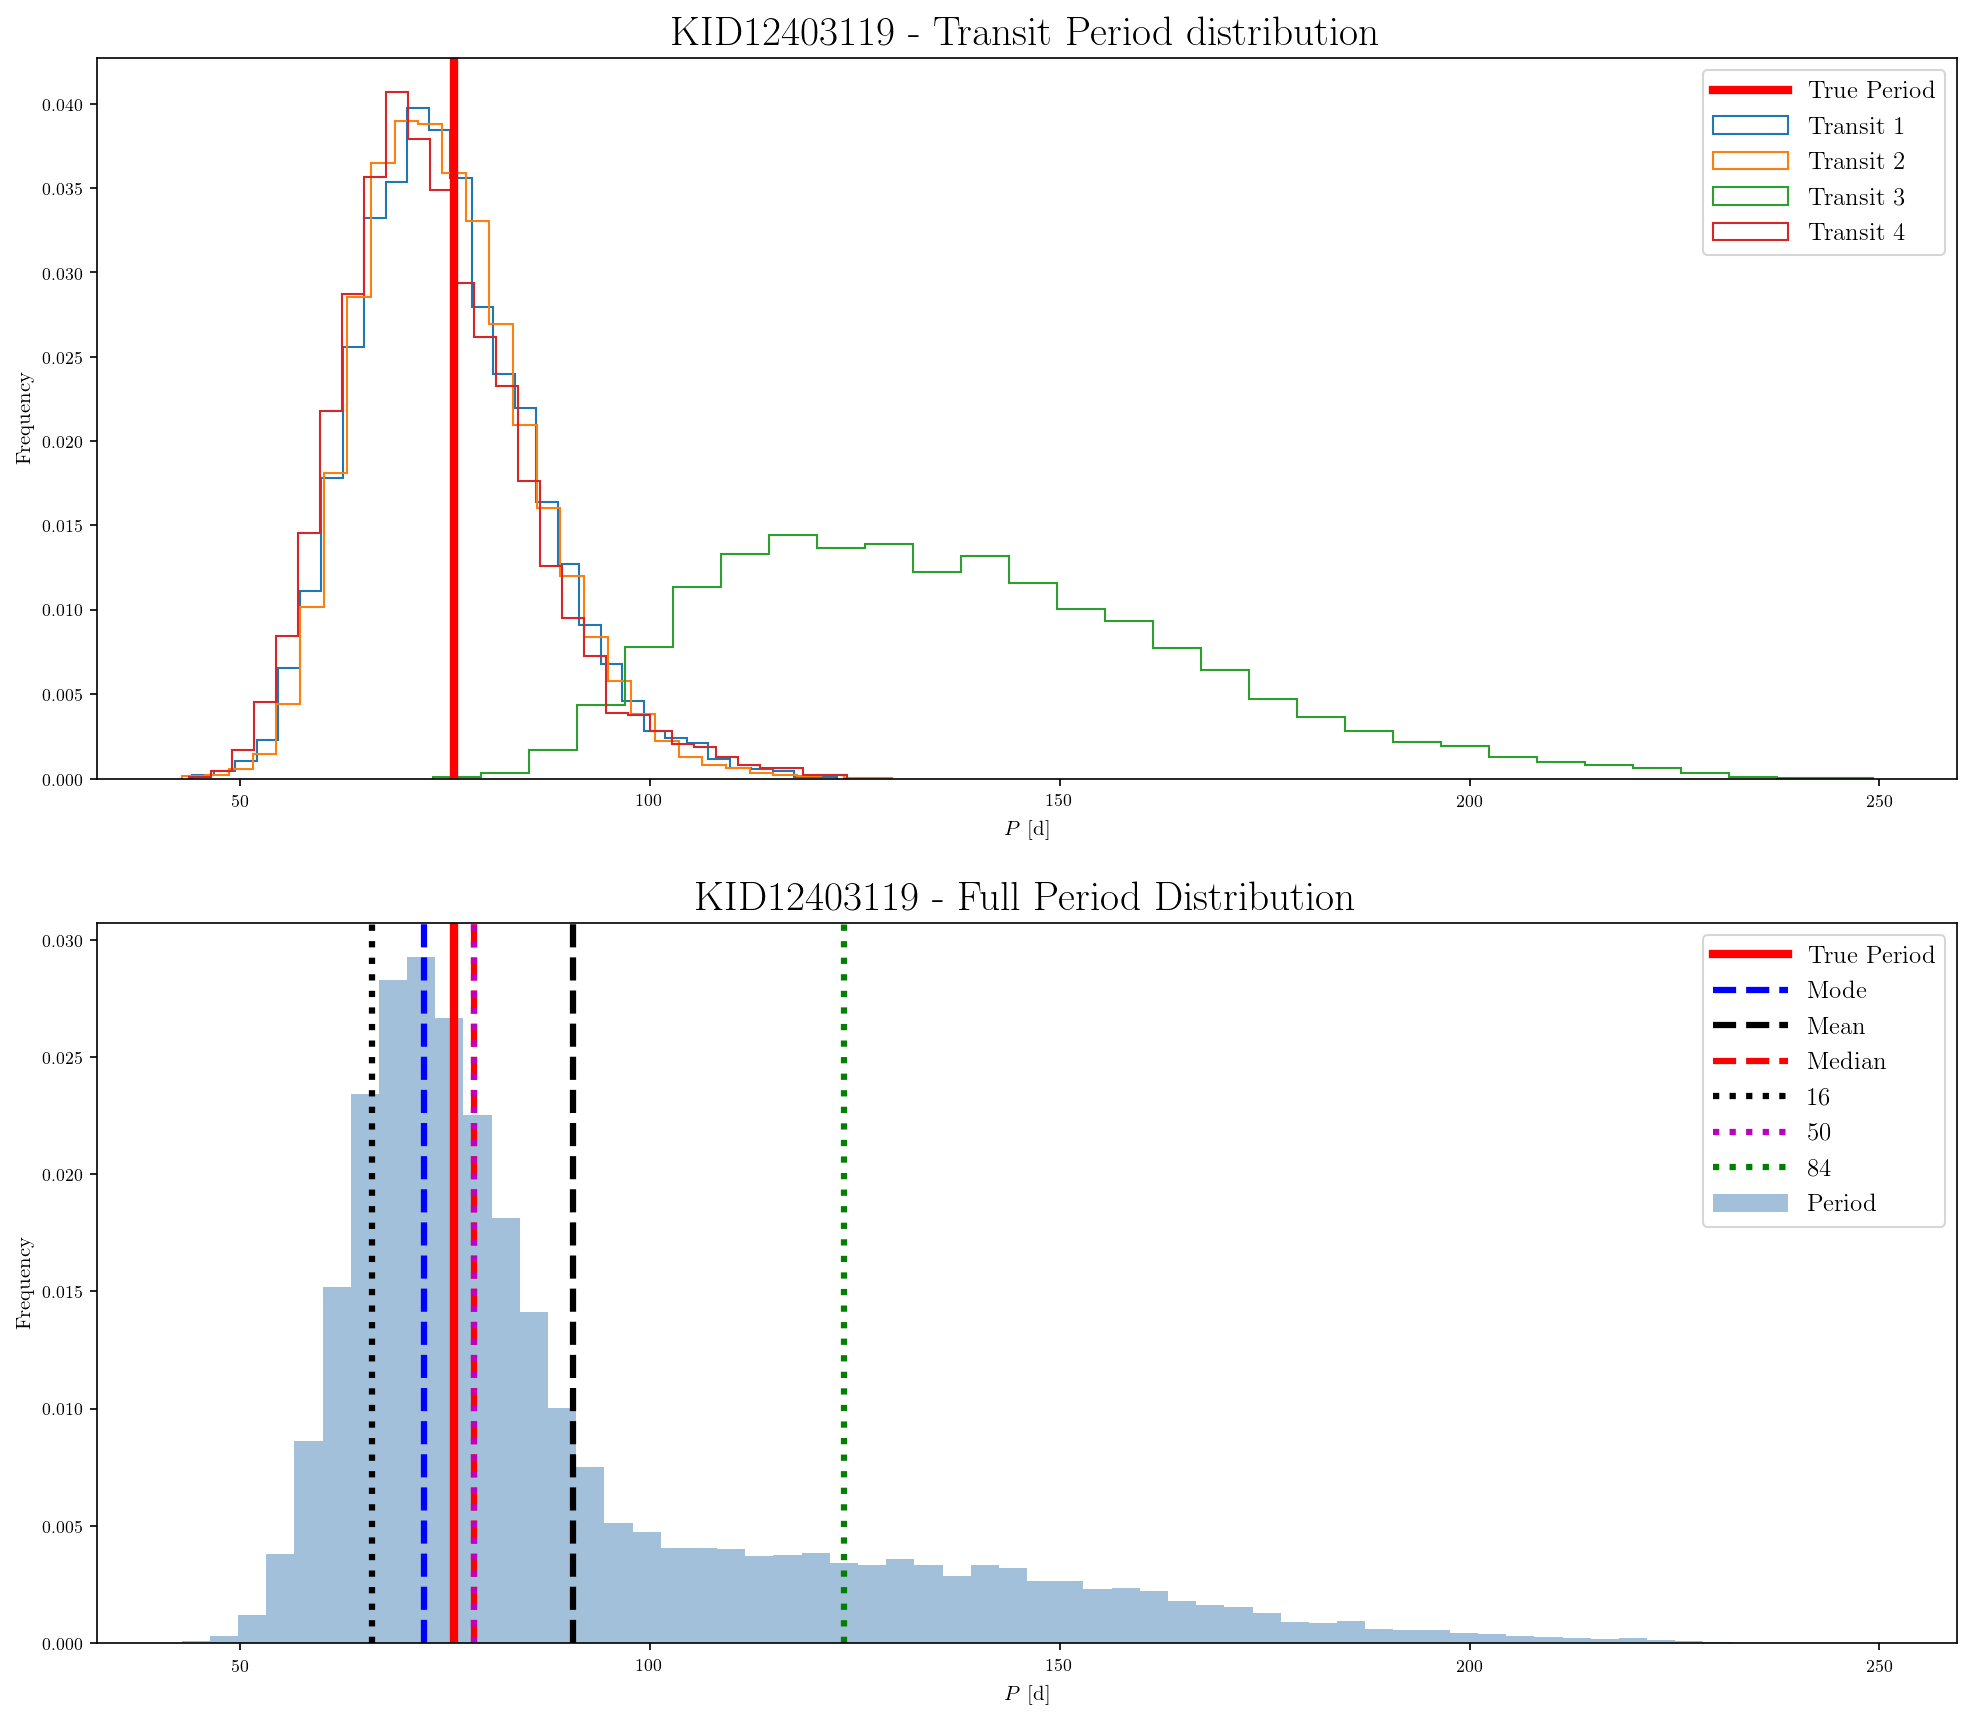

<Figure size 2400x1050 with 0 Axes>

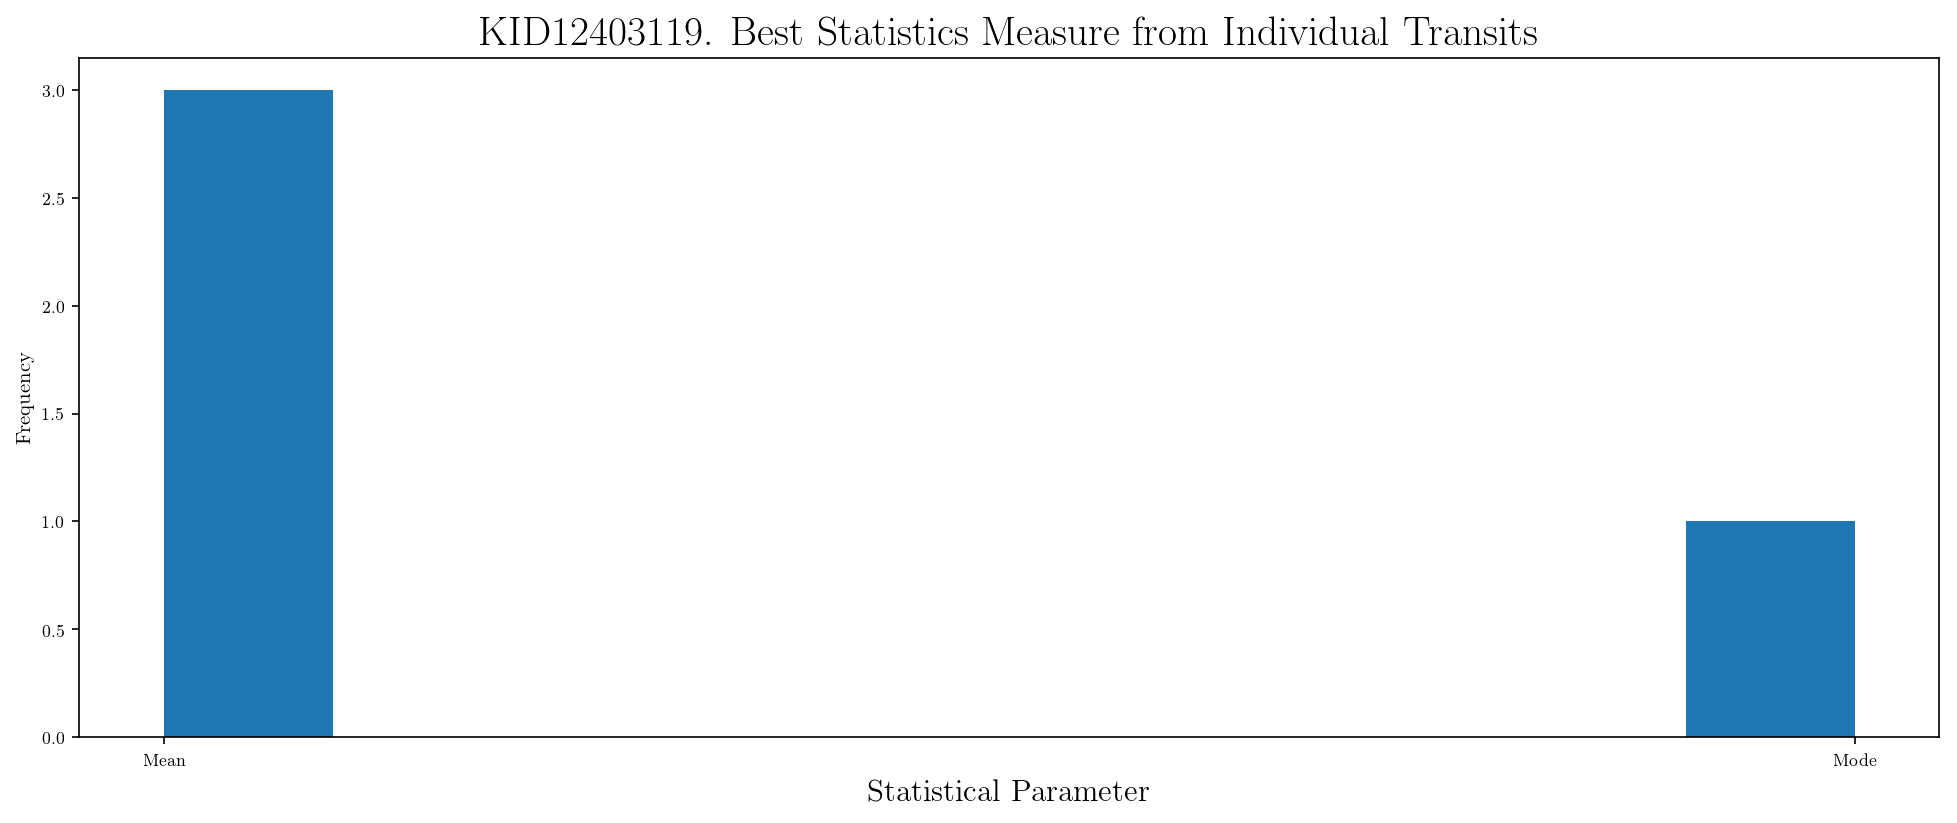

<Figure size 2400x1050 with 0 Axes>

In [61]:
path_newRs = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/period_distributions/'
os.chdir(path_newRs)

count = 0
save_best_stats = []

for target in targets:
    period_distribution = []
    P_trans_stats = []
    best_statistics = []
    
    search_files = glob.glob(path_newRs+str(target.kepid)+"*[!_BAD].txt")
    
    if len(search_files) != 0:
        for i in range(len(search_files)):
            filename = search_files[i]
            Ptrans = pd.read_csv(filename, sep = " ", names=['Period'], index_col = None)
            period_distribution.append(Ptrans)
            trans_stats = get_statistics(Ptrans['Period']).iloc[0]
            P_trans_stats.append(trans_stats)
            best_statistics.append(closest_statistic(trans_stats, target.P))
            
        
        target.full_P_trans = period_distribution
        target.full_P = pd.concat(period_distribution)
        
        target.best_stats = best_statistics
        save_best_stats.append(best_statistics)

        #Calculate statistical properties 
        target.full_P_trans_stats = P_trans_stats
        target.full_stats = get_statistics(target.full_P['Period'])
        
        plot_periods(target)
        show_best_stats(target)
        count += 1

In [81]:
print(count)
save_best_stats = list(itertools.chain.from_iterable(save_best_stats))

12


Text(0.5,0,'Statistical Measure')

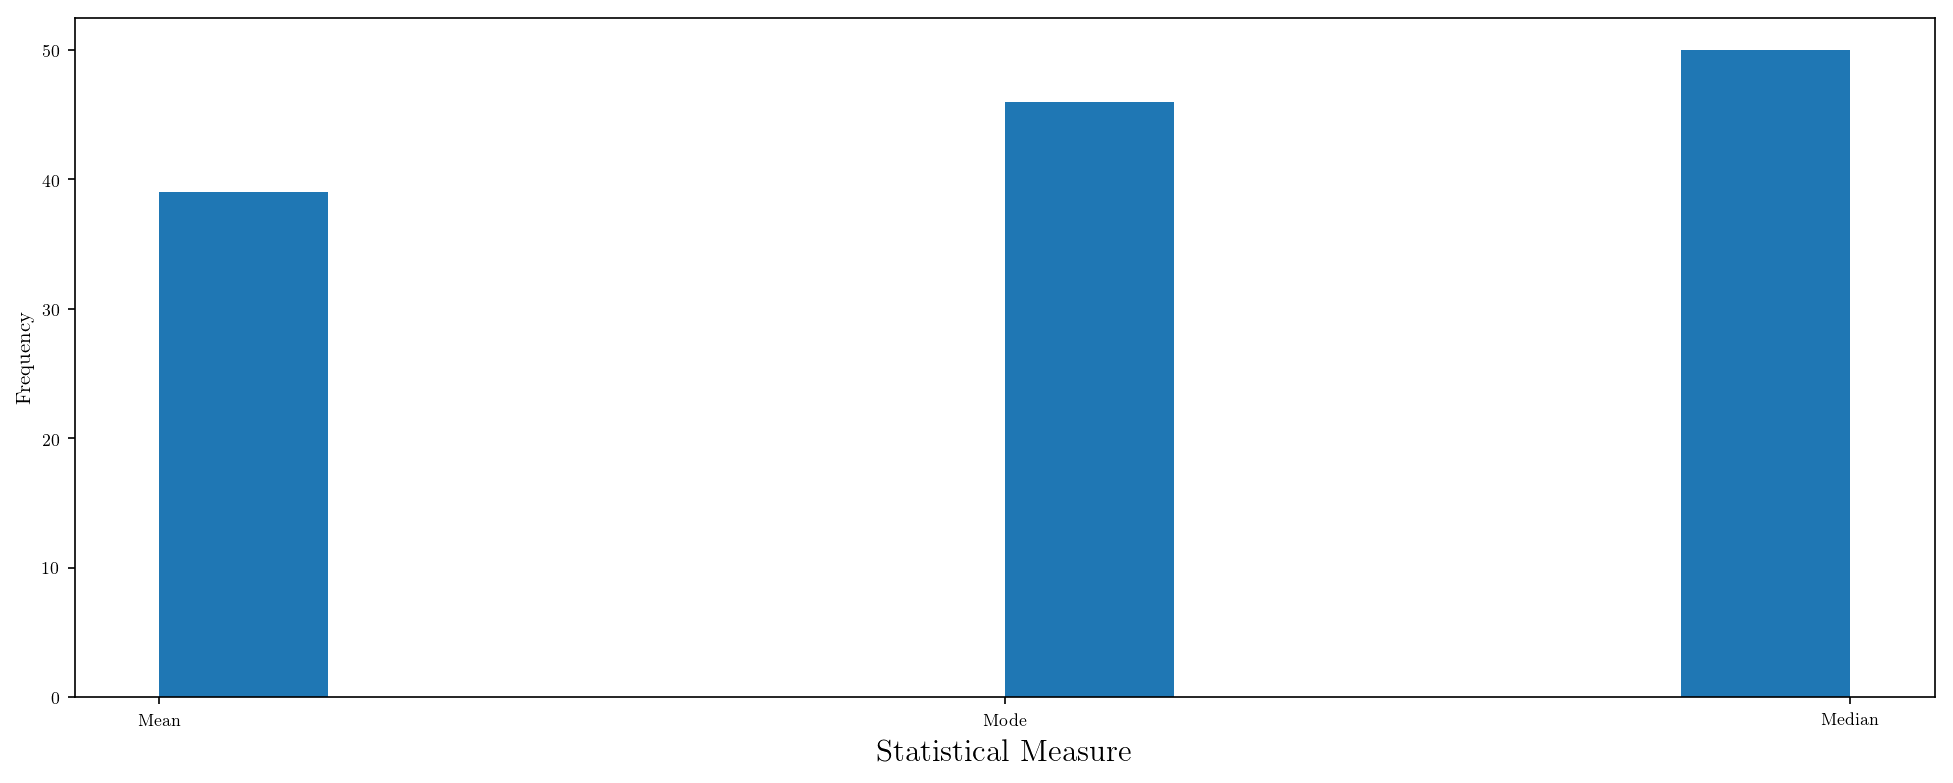

In [82]:
fig = plt.figure(figsize=(16,6))
ax=fig.add_subplot(111)
ax.hist(save_best_stats, density = False)
ax.set_ylabel('Frequency')
ax.set_xlabel('Statistical Measure', fontsize = 15) 

KID6471021
True Period: 125.6291479
Estimated Period: 113.05294814983077
[-12.57619975]
[1]


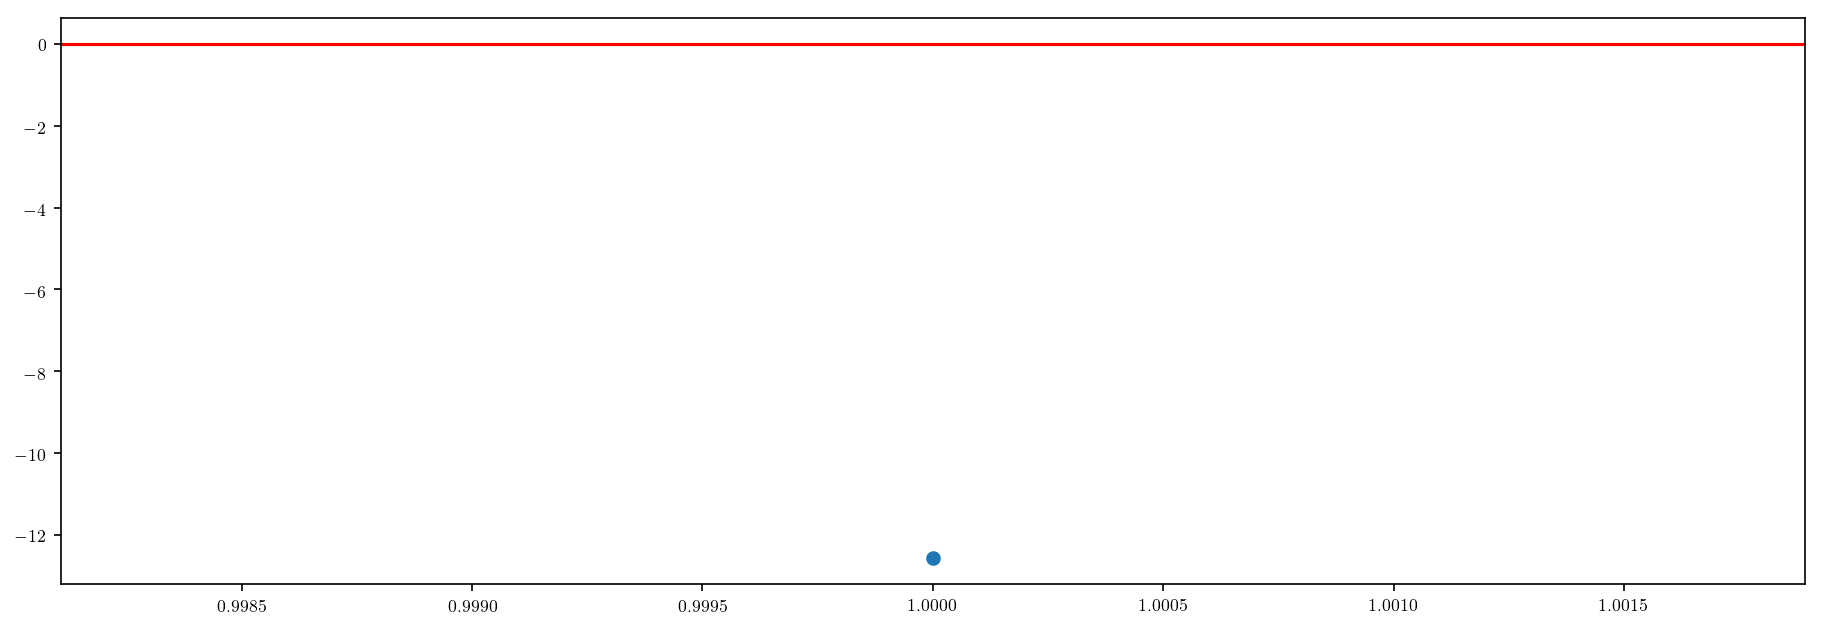

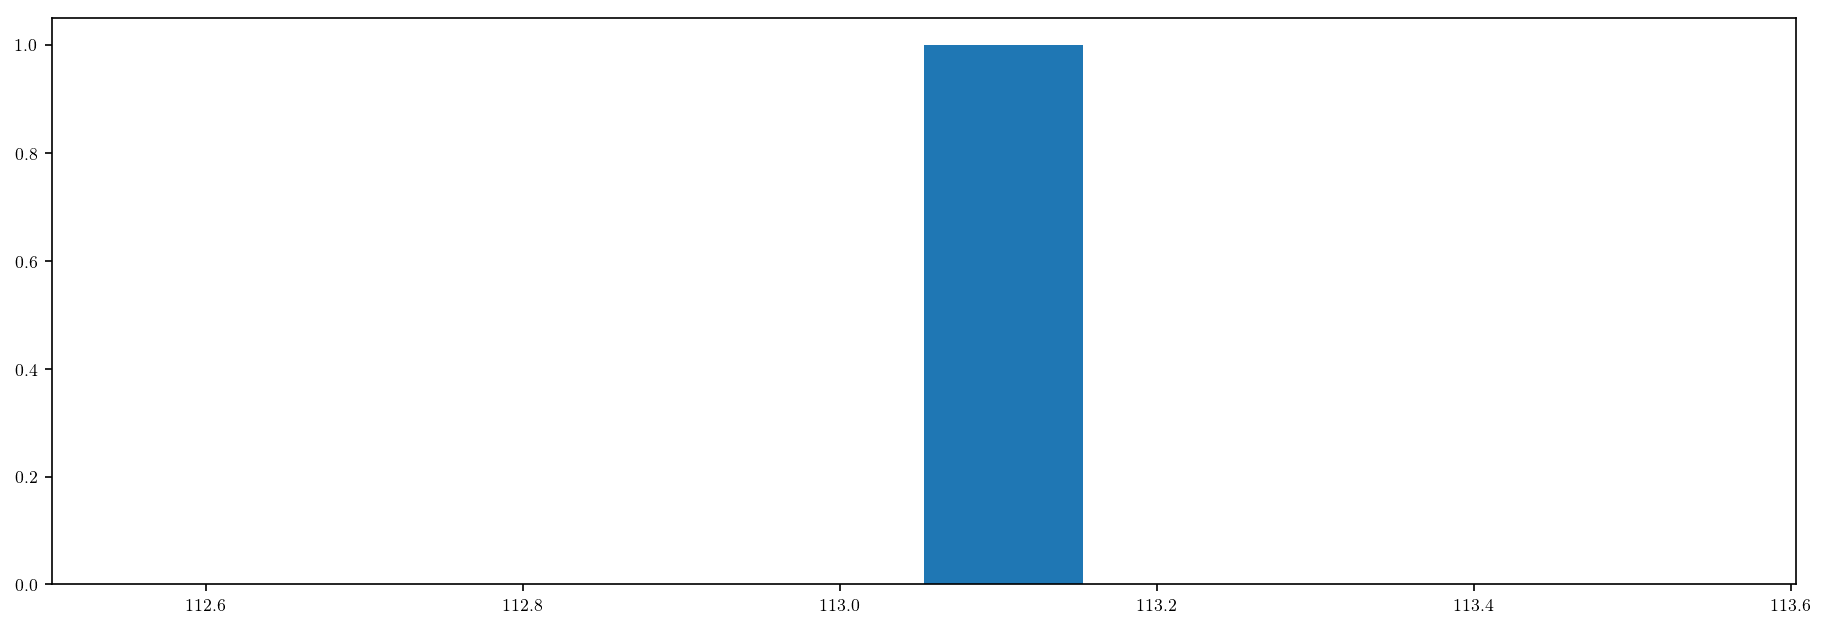

STD: 0.0
Mean: -12.576199750169238
KID5383248
True Period: 16.23847733
Estimated Period: 16.744789916700864
Estimated Period: 21.989191838549434
Estimated Period: 17.666205621269555
[0.50631259 5.75071451 1.42772829]
[1 2 3]


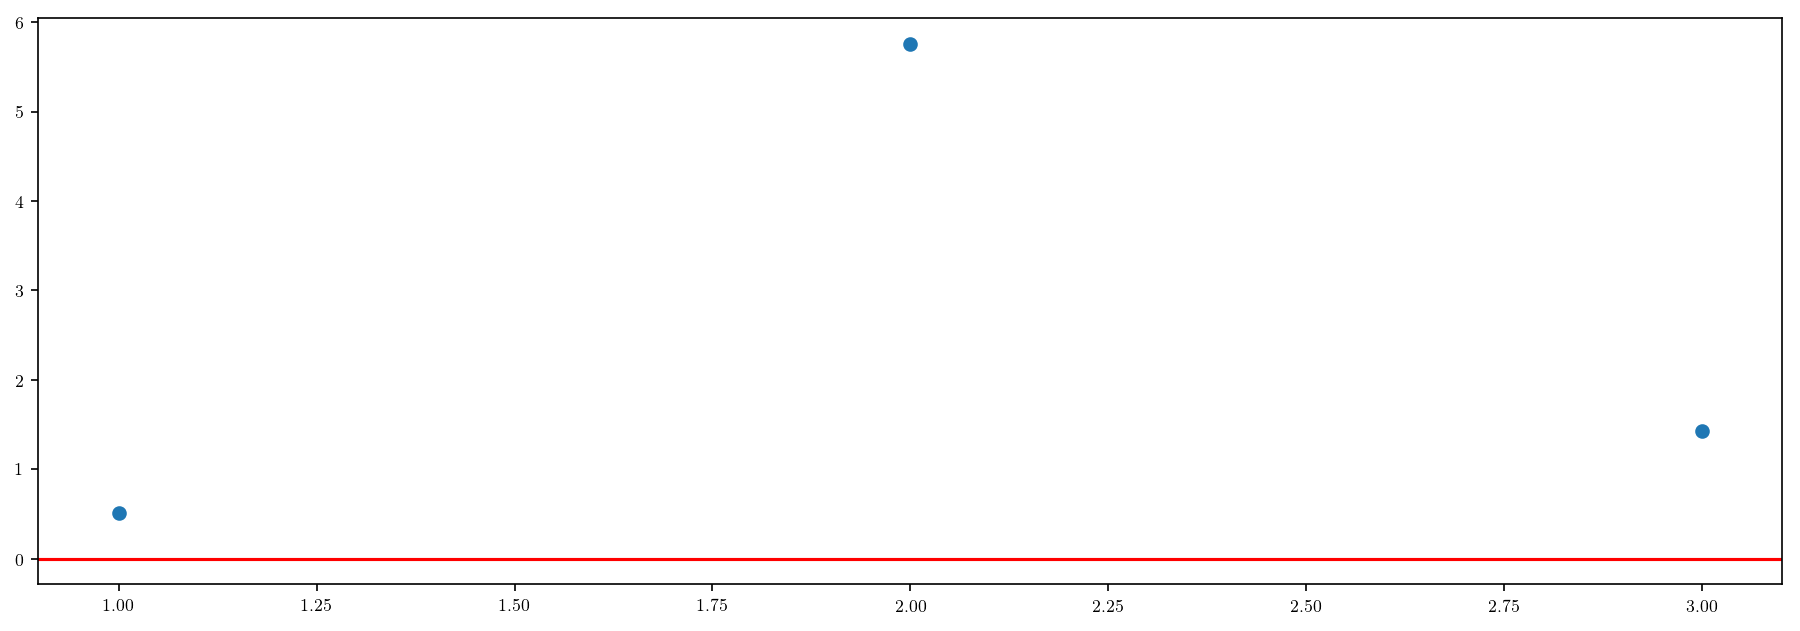

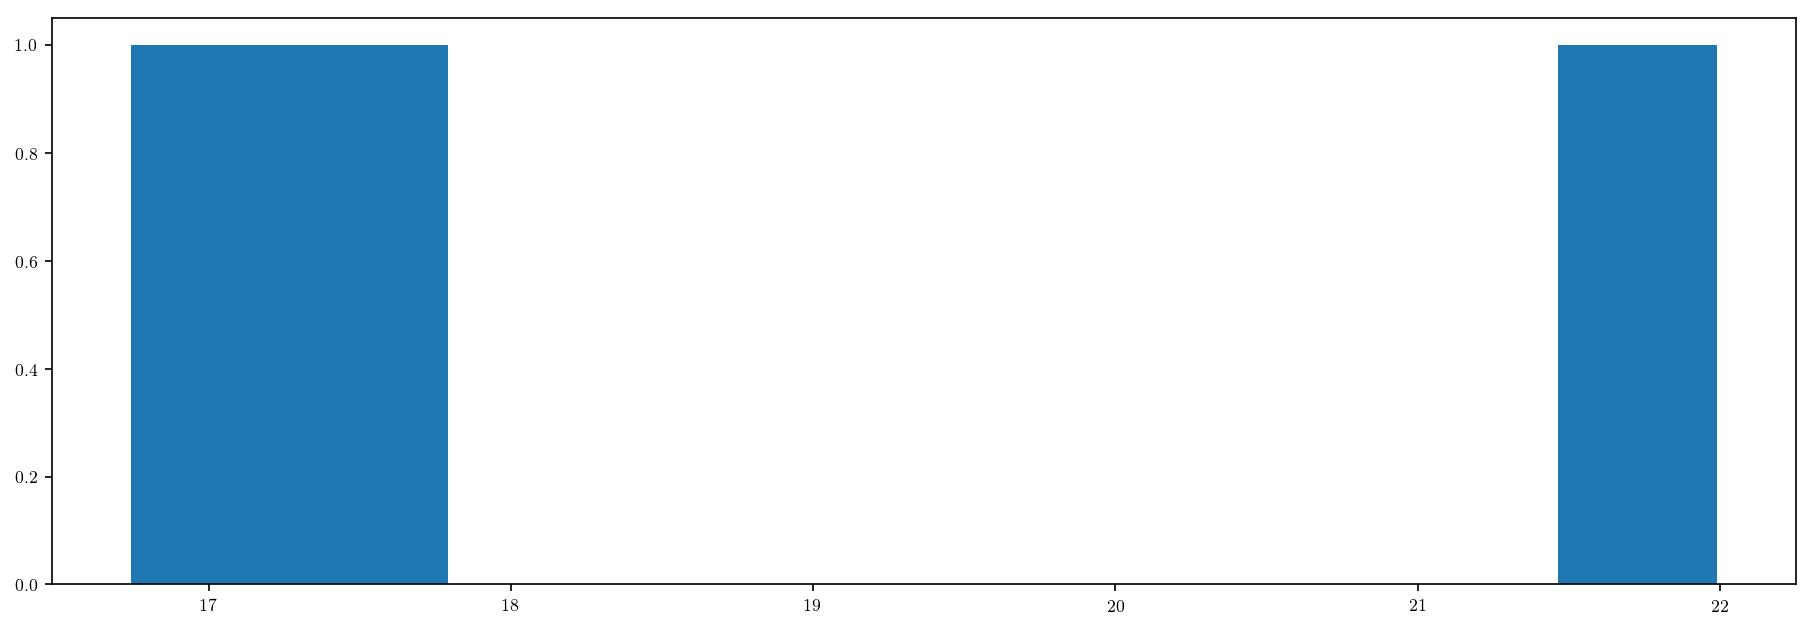

STD: 2.28621395550972
Mean: 2.5615851288399525
KID11074541
True Period: 29.88487723
Estimated Period: 25.690683891803467
[-4.19419334]
[1]


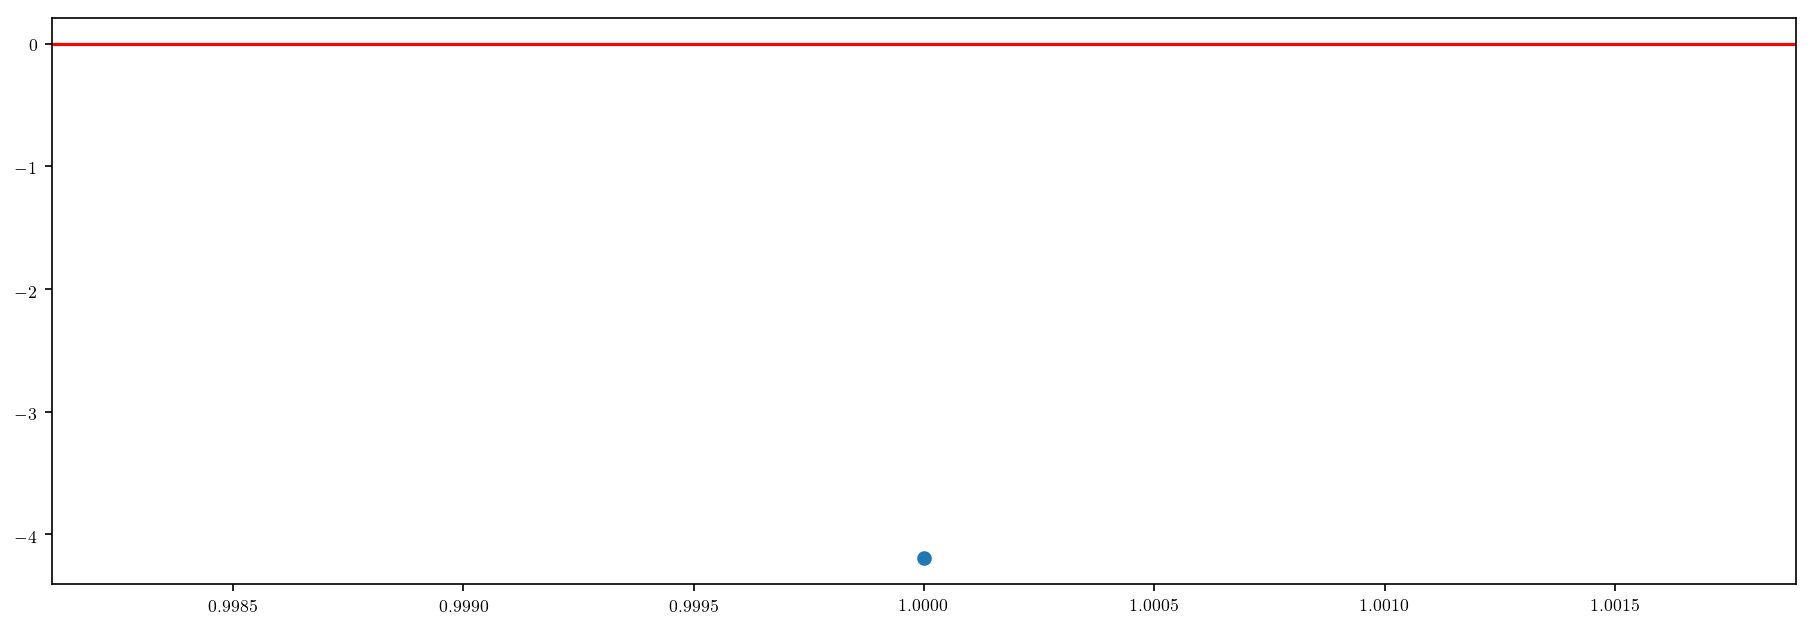

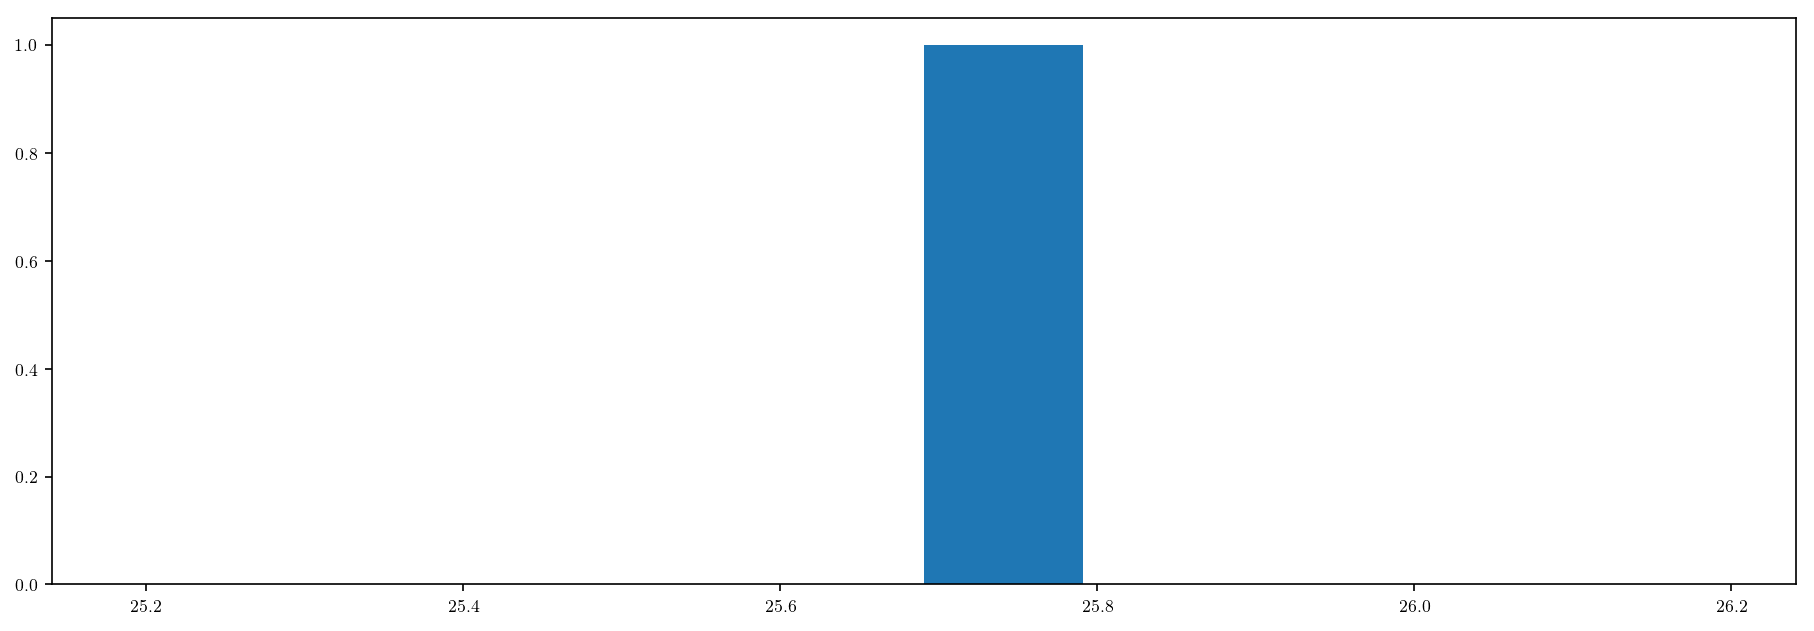

STD: 0.0
Mean: -4.194193338196534
KID5812701
True Period: 17.855221681
Estimated Period: 18.43446385852291
Estimated Period: 17.336481917609948
Estimated Period: 18.544706621942634
Estimated Period: 17.426726384359217
Estimated Period: 19.7954467706617
Estimated Period: 17.57870325325123
Estimated Period: 16.987676090031883
Estimated Period: 16.899073485688355
Estimated Period: 17.321756740356143
Estimated Period: 17.655907381514645
Estimated Period: 18.563455803325972
Estimated Period: 17.200910601991094
Estimated Period: 17.729436291935667
Estimated Period: 19.182233191424423
Estimated Period: 16.427575002647064
Estimated Period: 17.41528872113246
Estimated Period: 18.30692752678481
Estimated Period: 16.345609590605704
Estimated Period: 19.03850494187839
Estimated Period: 23.885529900637952
Estimated Period: 20.489214239630385
Estimated Period: 17.46041395343639
Estimated Period: 17.728318763640047
Estimated Period: 17.3612039409259
Estimated Period: 17.32355650381776
Estimated Perio

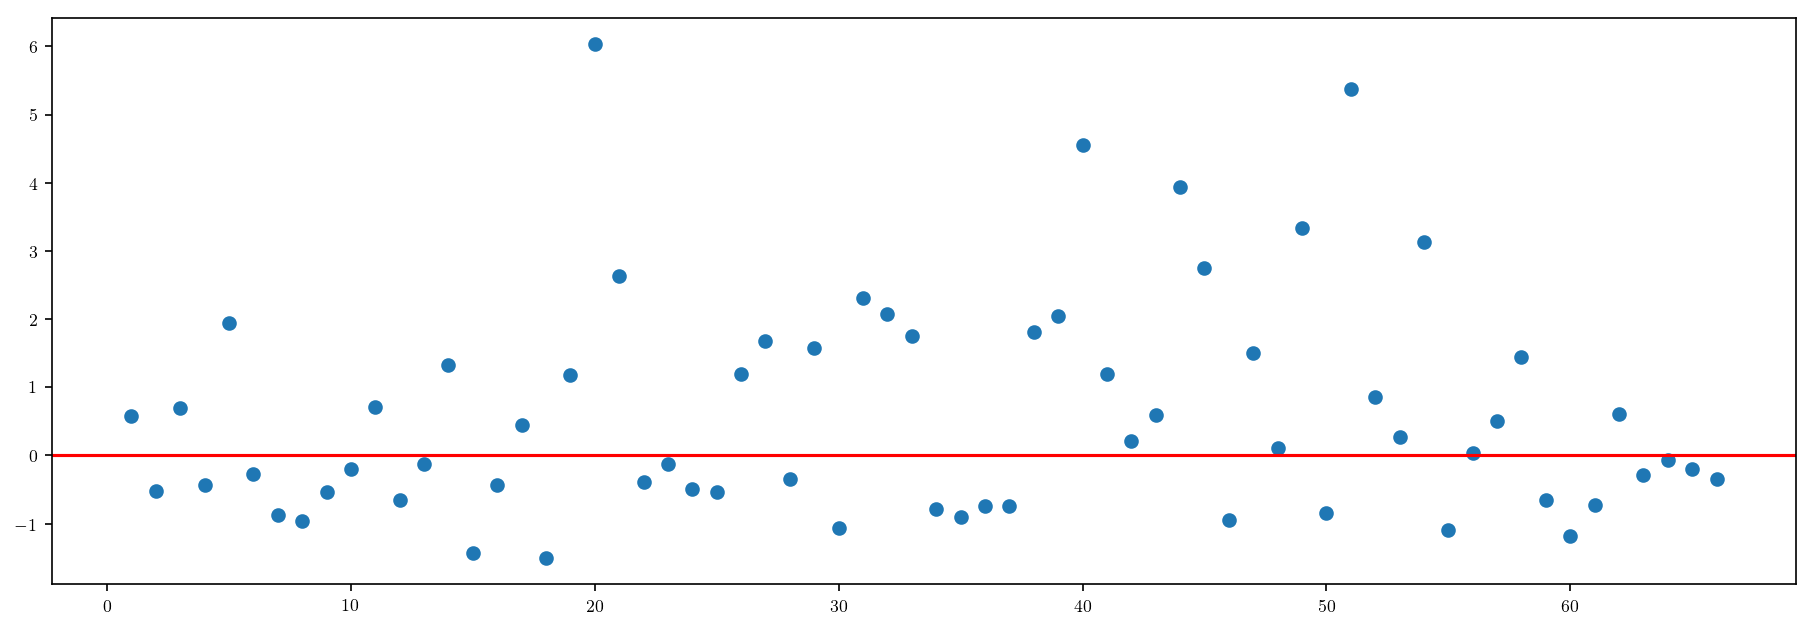

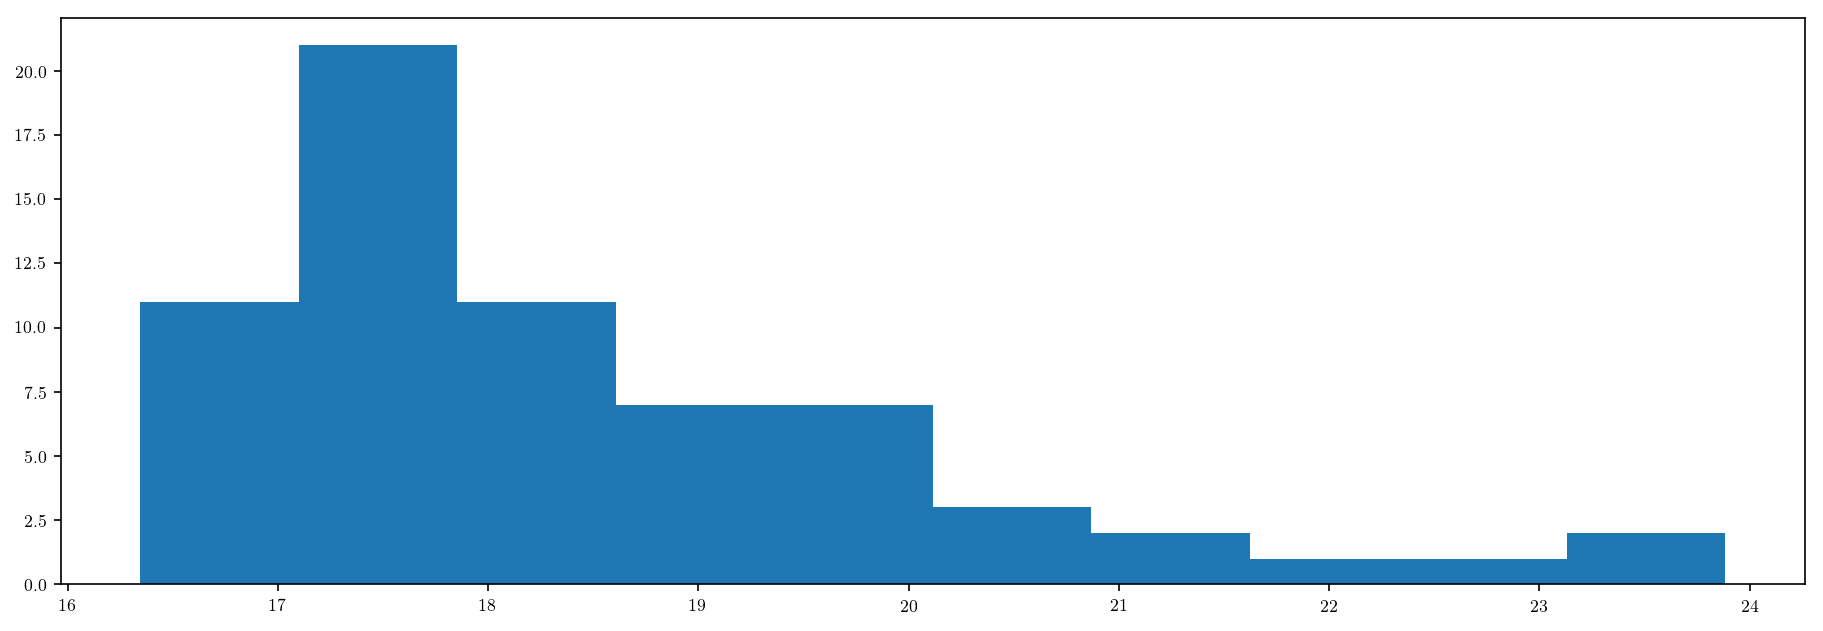

STD: 1.6184026455736442
Mean: 0.6050149410759554
KID11449844
True Period: 38.47876629
Estimated Period: 37.79453537550764
Estimated Period: 37.75462963251313
Estimated Period: 38.2625798886718
Estimated Period: 38.81409062294042
Estimated Period: 38.60321121039138
Estimated Period: 38.72701893669535
Estimated Period: 38.17388812518281
Estimated Period: 38.7655301329878
Estimated Period: 41.43773714918809
Estimated Period: 38.688682452243484
Estimated Period: 37.8385499608664
[-0.68423091 -0.72413666 -0.2161864   0.33532433  0.12444492  0.24825265
 -0.30487816  0.28676384  2.95897086  0.20991616 -0.64021633]
[ 1  2  3  4  5  6  7  8  9 10 11]


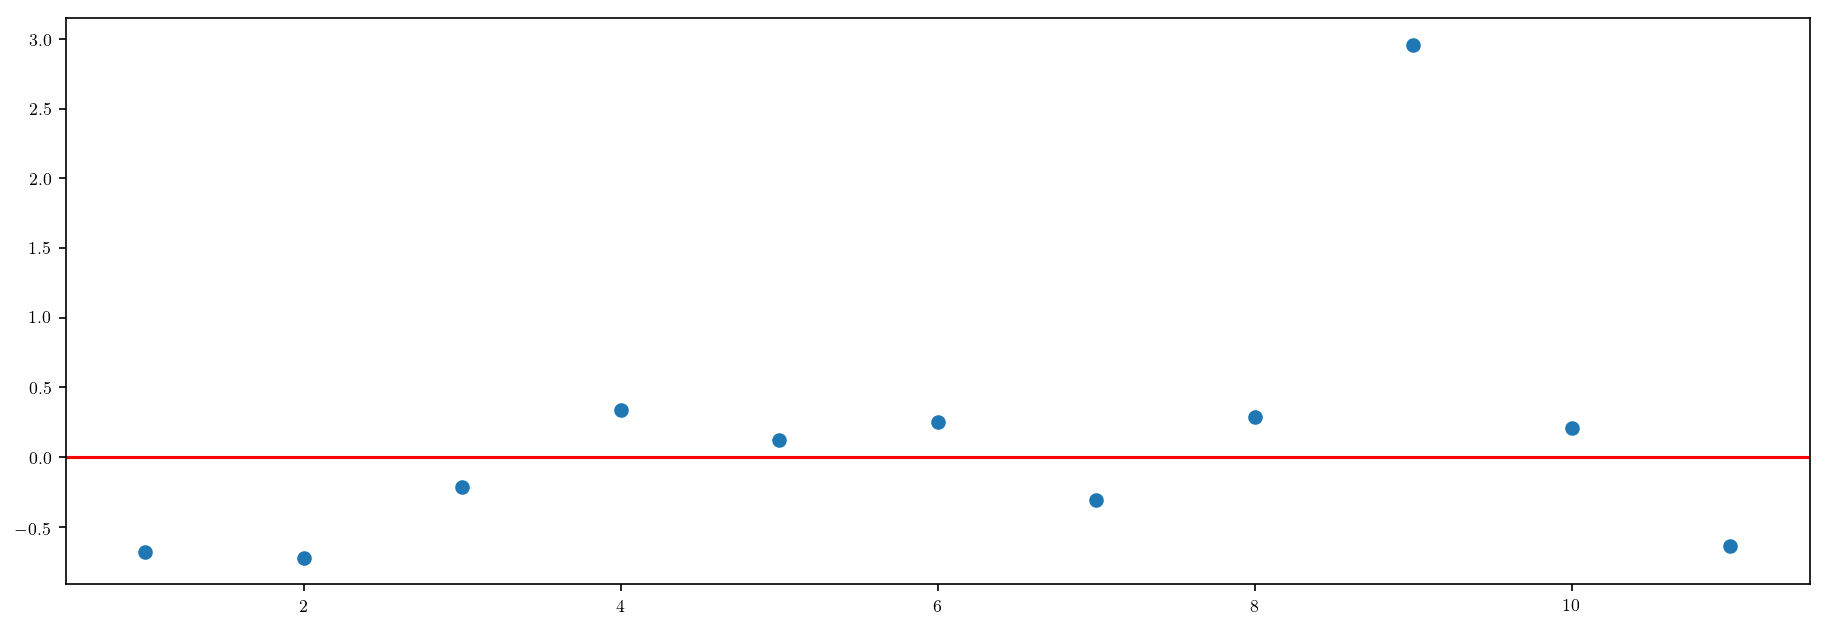

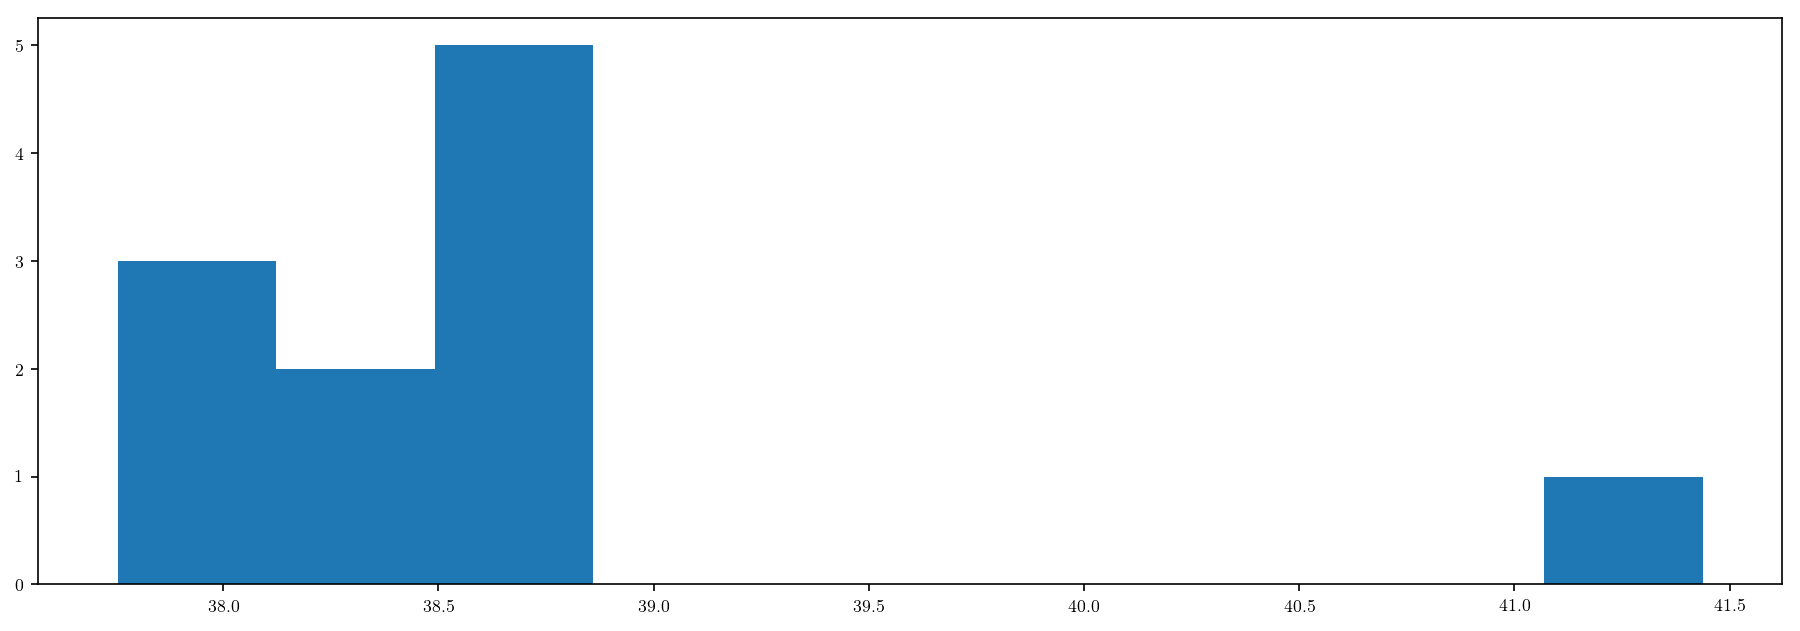

STD: 0.9715256548958678
Mean: 0.1449112997443888
KID5796675
True Period: 16.080657264000003
Estimated Period: 44.49854167282149
Estimated Period: 19.467216678637186
[28.41788441  3.38655941]
[1 2]


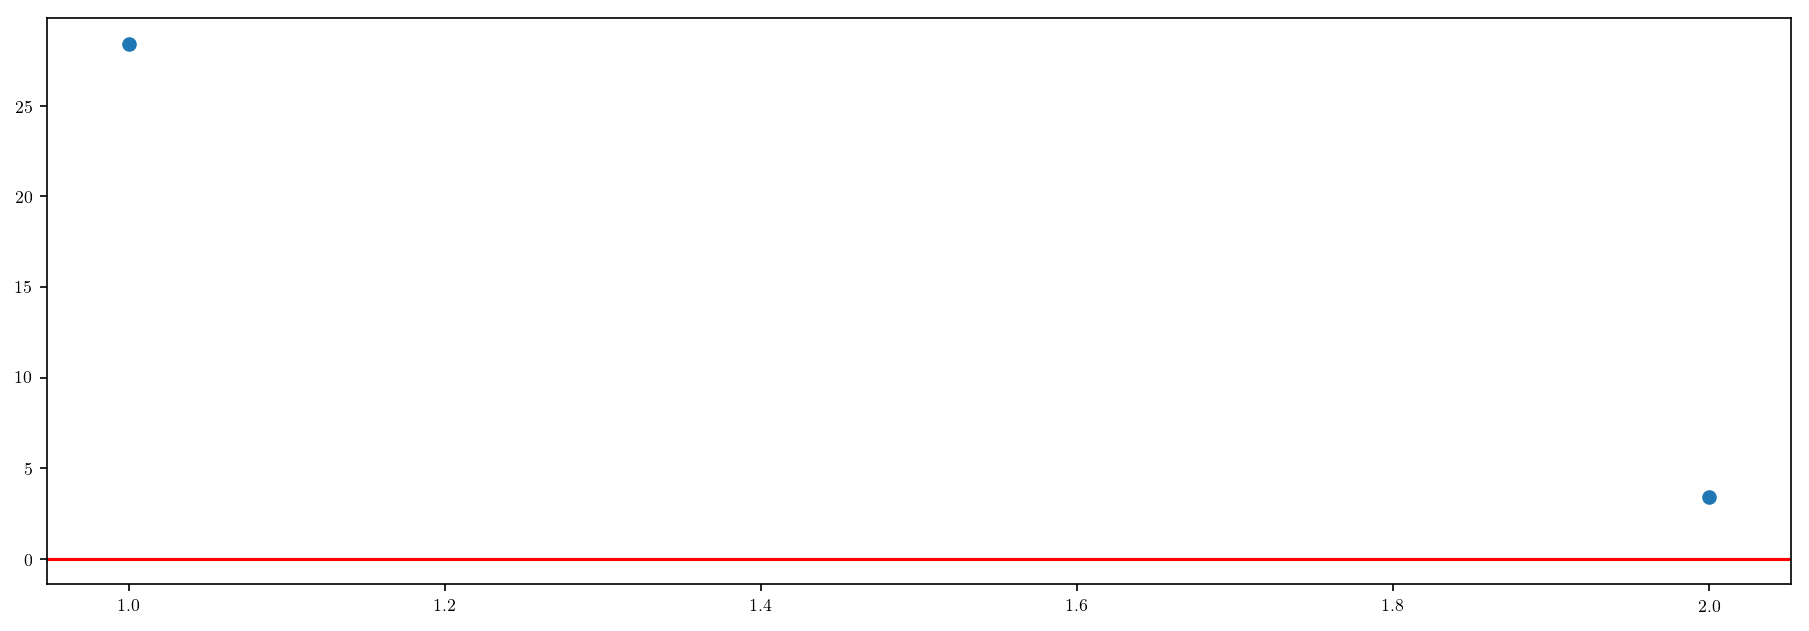

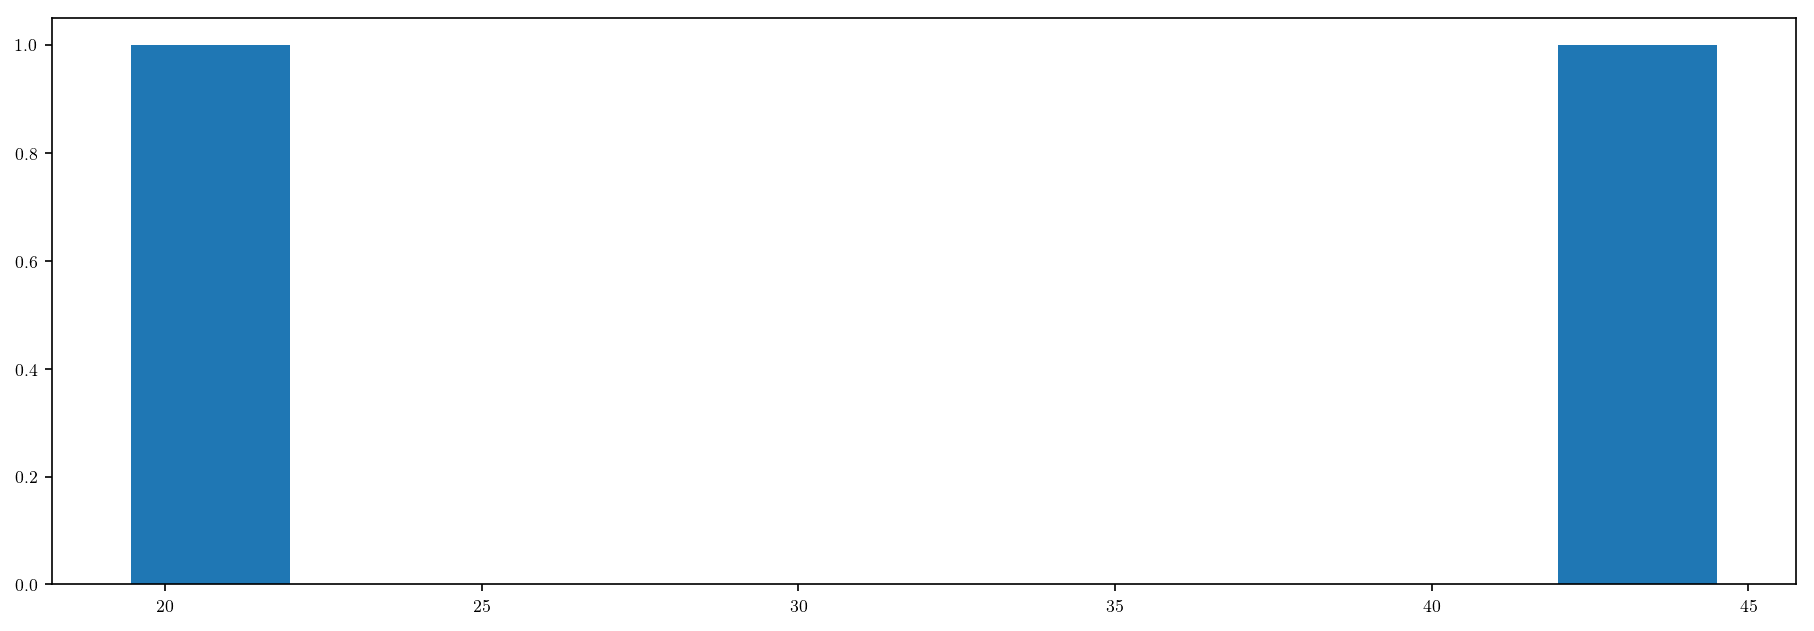

STD: 12.515662497092151
Mean: 15.902221911729335
KID8156120
True Period: 38.5833679
Estimated Period: 36.96125320276403
Estimated Period: 286.9117629141281
Estimated Period: 47.92089470745604
Estimated Period: 38.729251848736155
[-1.62211470e+00  2.48328395e+02  9.33752681e+00  1.45883949e-01]
[1 2 3 4]


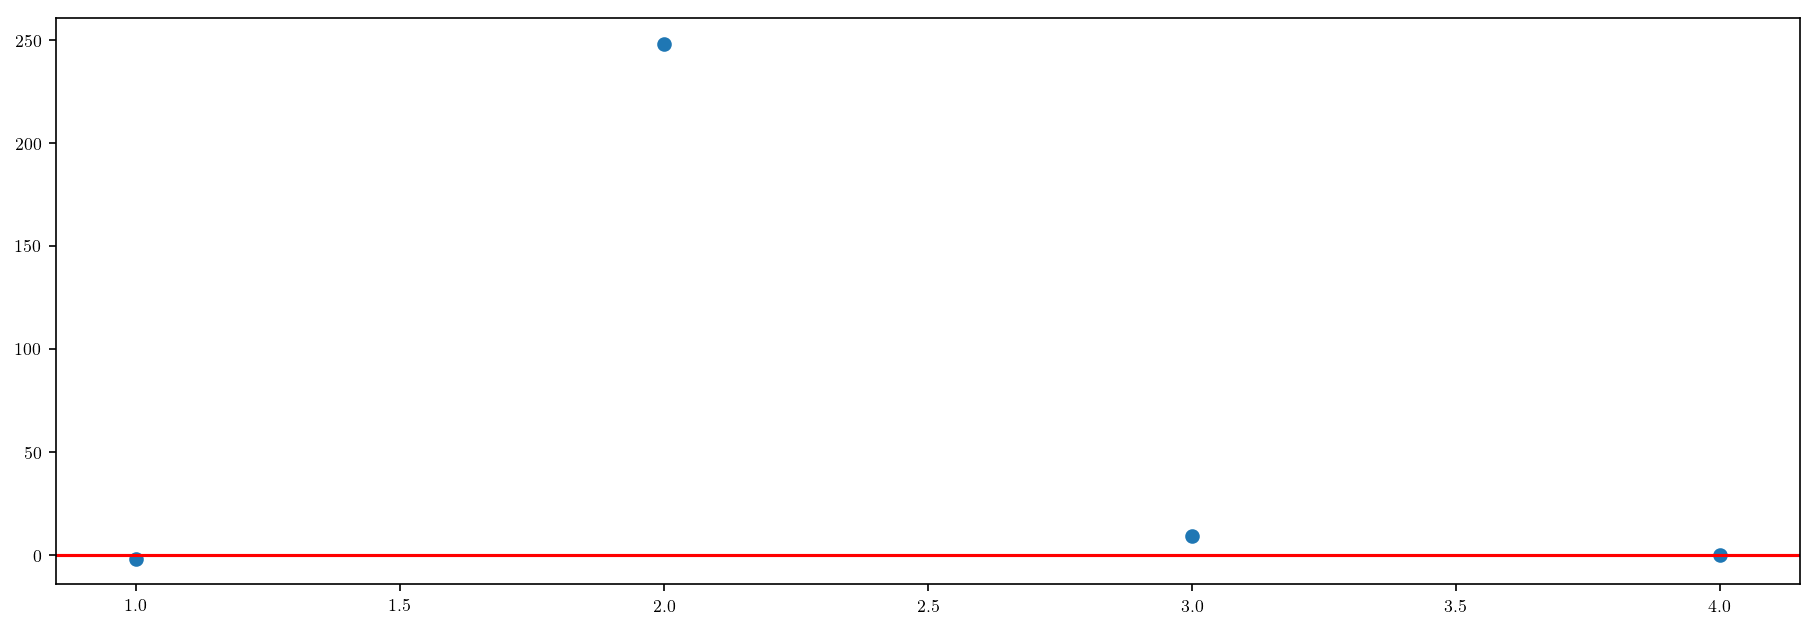

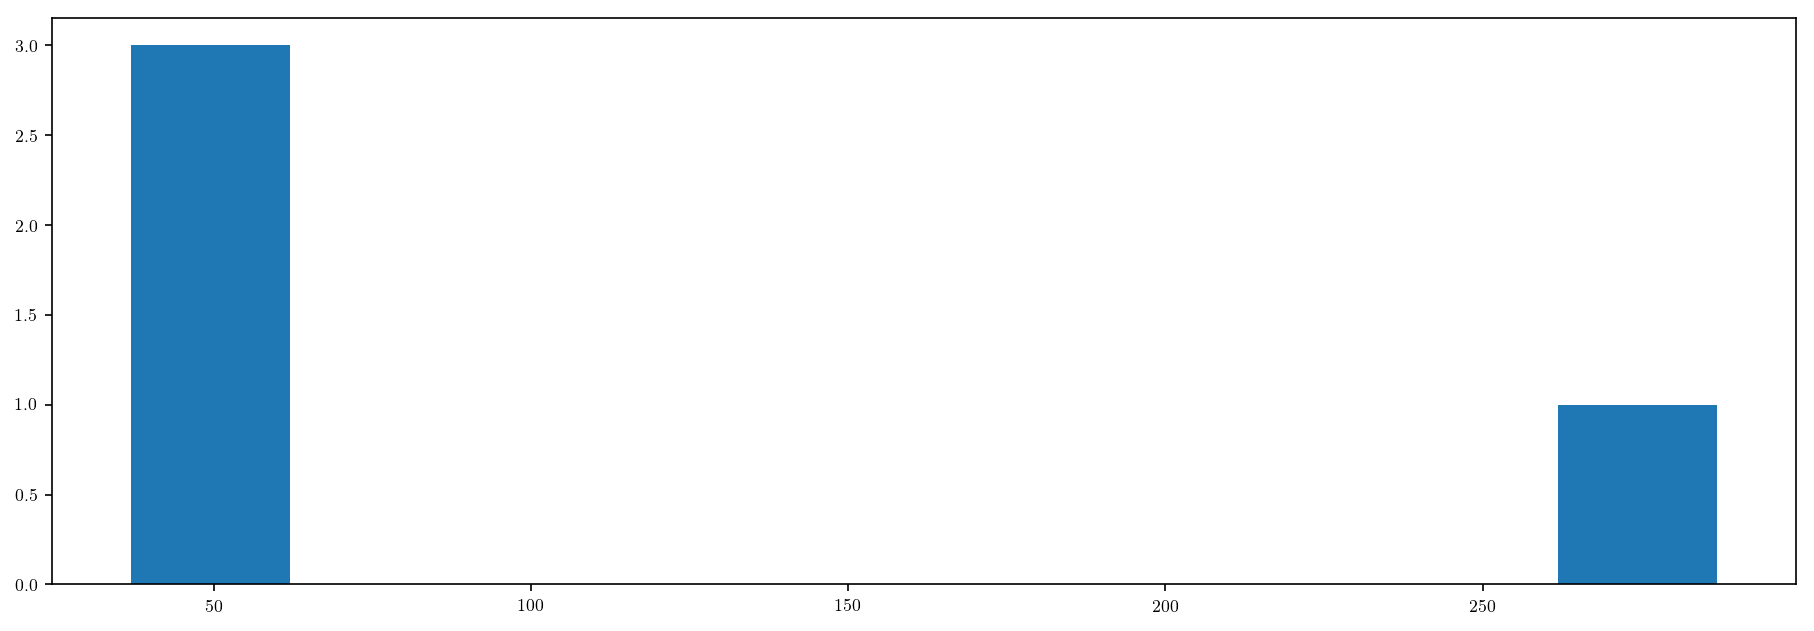

STD: 106.47598821137996
Mean: 64.04742276827108
KID11391018
True Period: 30.360445359
Estimated Period: 34.43867095700747
Estimated Period: 29.27222961136008
Estimated Period: 31.643519377244505
Estimated Period: 23.542853515687003
Estimated Period: 30.910295734558094
Estimated Period: 27.469287988901442
[ 4.0782256  -1.08821575  1.28307402 -6.81759184  0.54985038 -2.89115737]
[1 2 3 4 5 6]


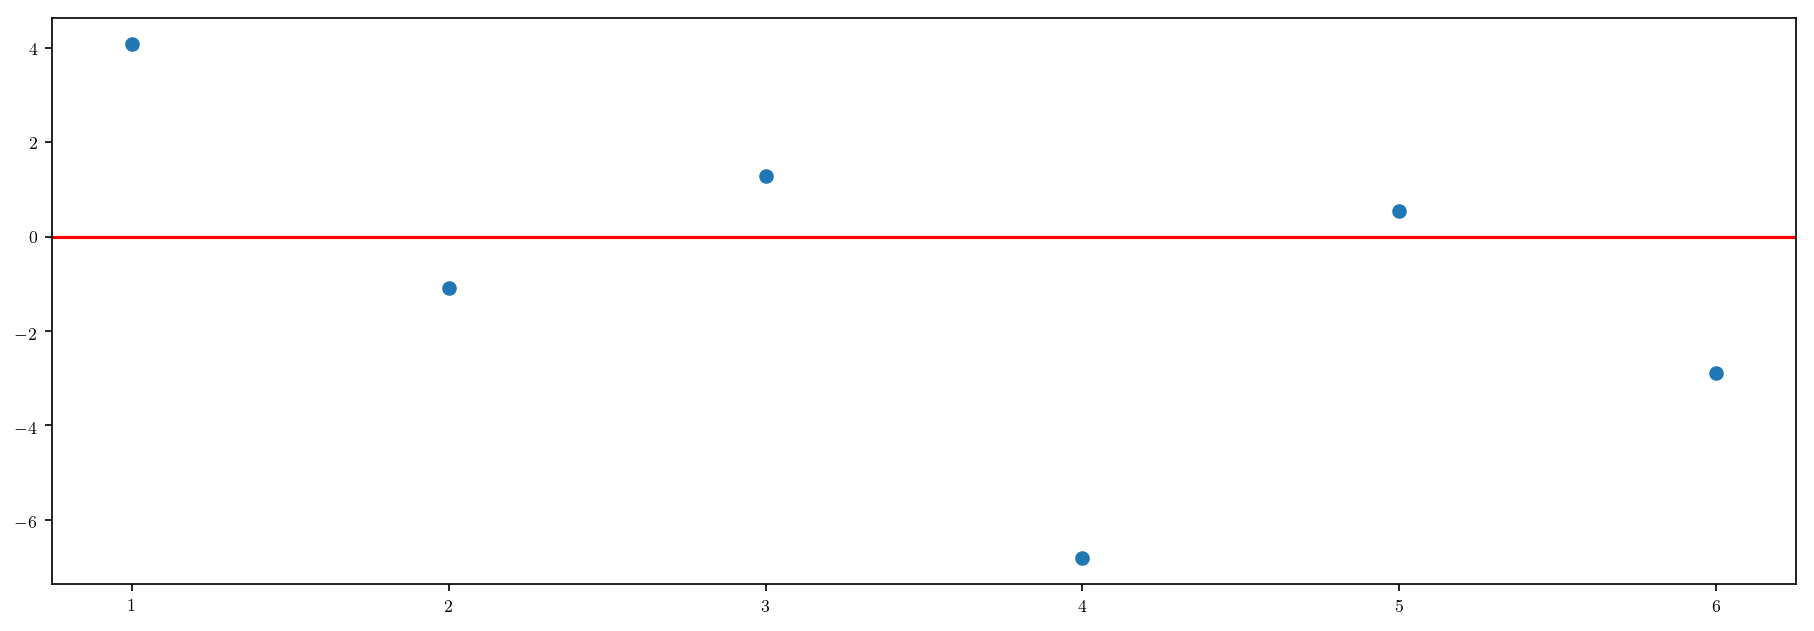

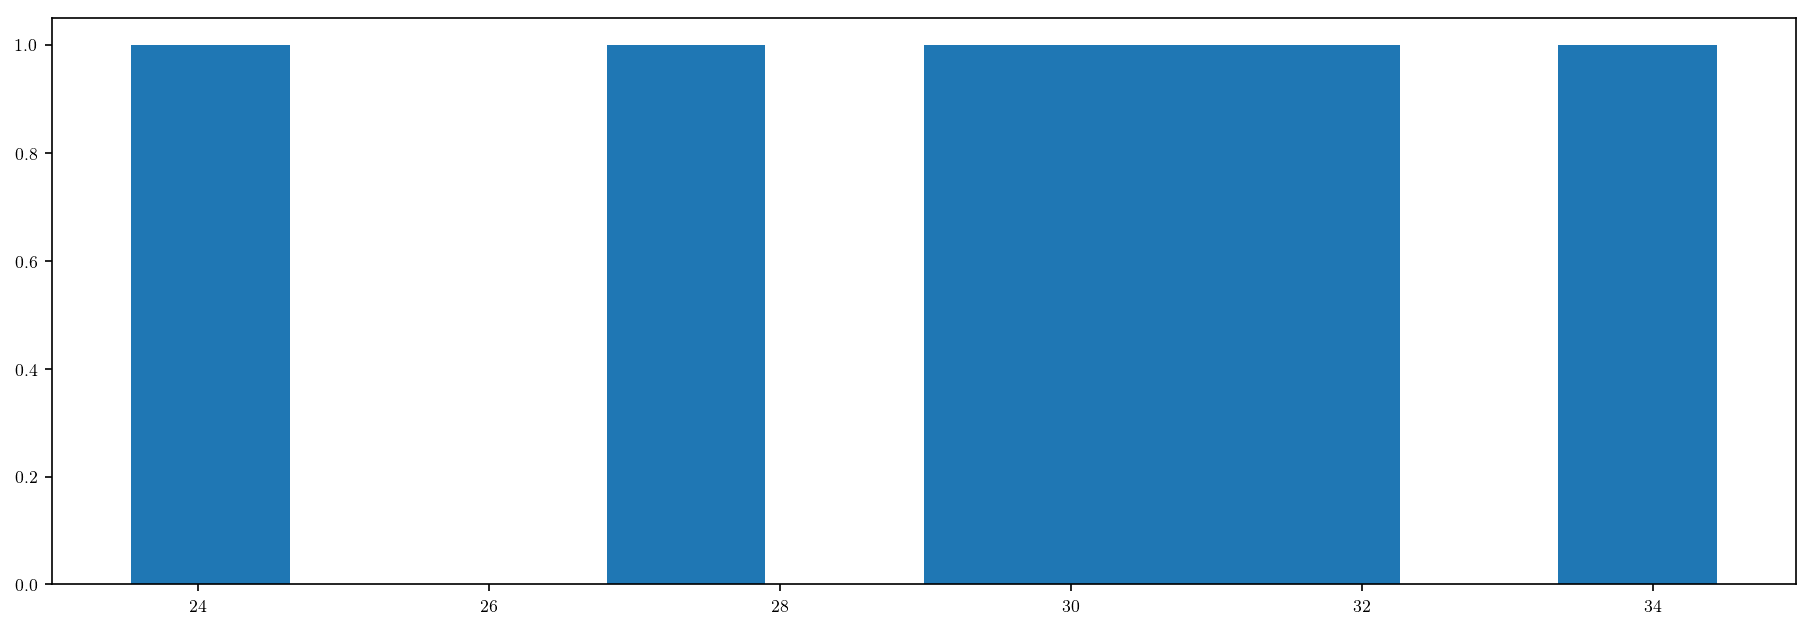

STD: 3.430854365780958
Mean: -0.8143024948735681
KID2987027
True Period: 17.276296682
Estimated Period: 20.269401061509303
Estimated Period: 16.835476070107777
Estimated Period: 17.590584412475078
Estimated Period: 16.46598092754947
Estimated Period: 16.574361337436102
Estimated Period: 18.198495296133203
Estimated Period: 17.06328338267921
Estimated Period: 17.142072380821727
Estimated Period: 21.056623721381342
Estimated Period: 17.758938886146197
Estimated Period: 17.30317192147416
Estimated Period: 17.198604662463207
Estimated Period: 17.535071479403385
[ 2.99310438 -0.44082061  0.31428773 -0.81031575 -0.70193534  0.92219861
 -0.2130133  -0.1342243   3.78032704  0.4826422   0.02687524 -0.07769202
  0.2587748 ]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]


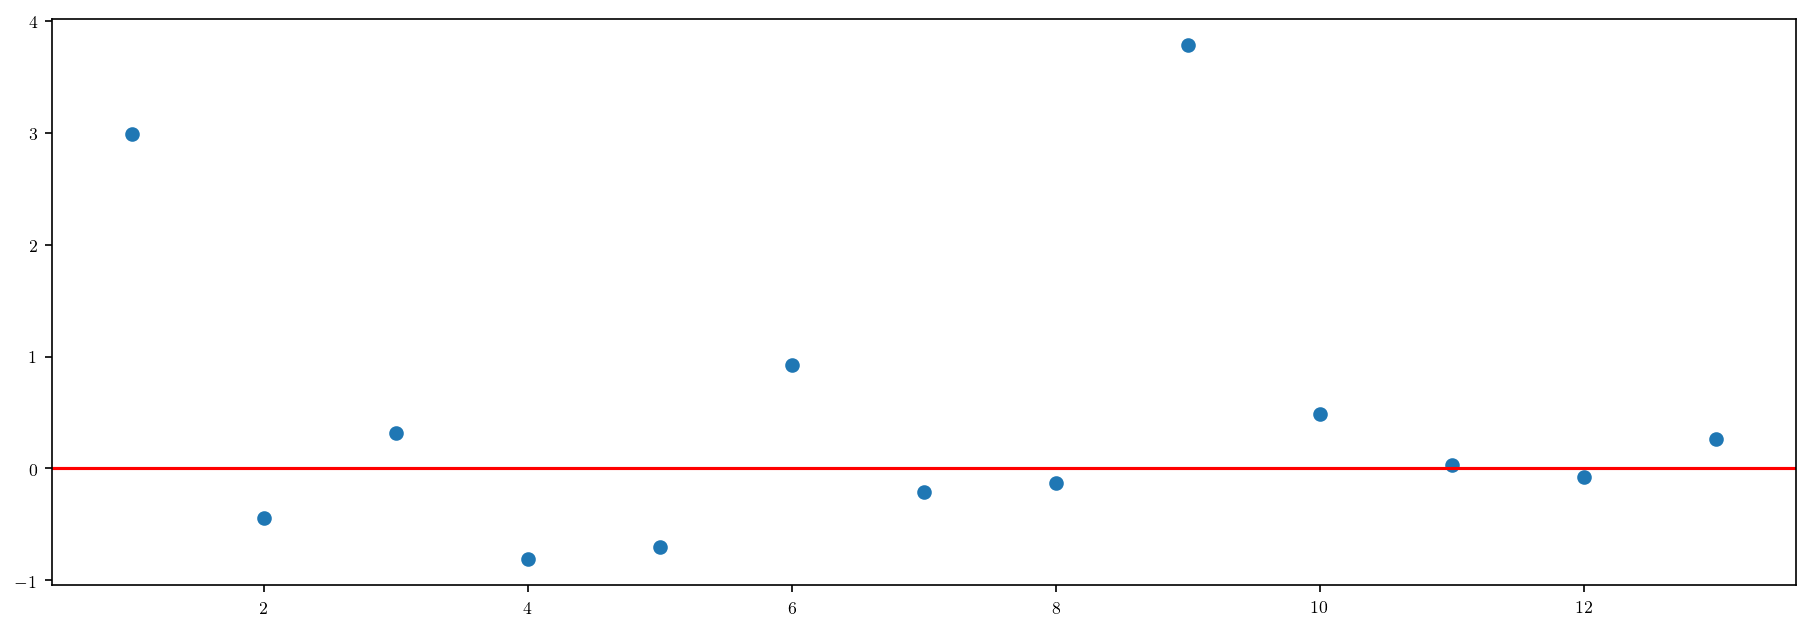

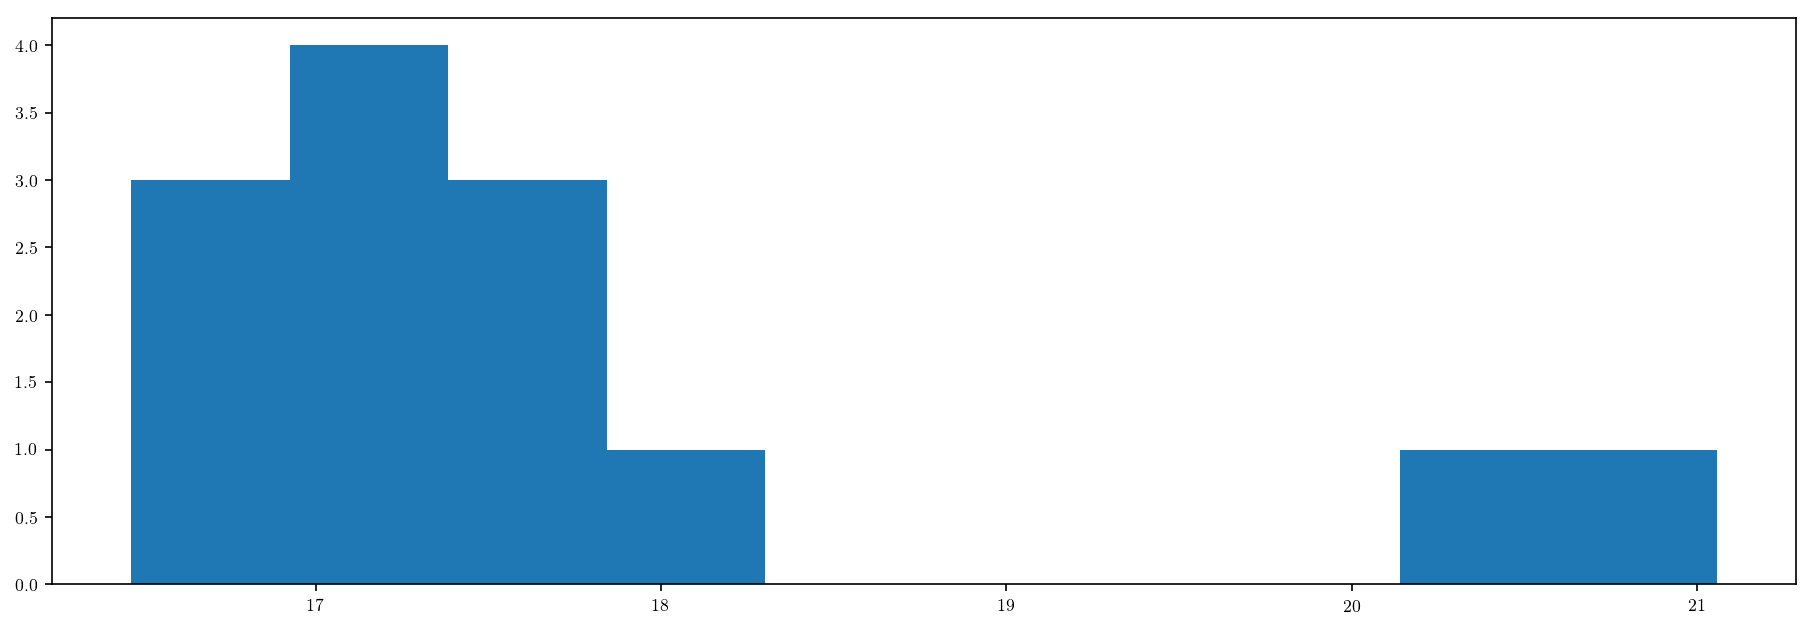

STD: 1.323210066096505
Mean: 0.4923237441215491
KID4742414
True Period: 15.458056682
Estimated Period: 16.634755260971303
[1.17669858]
[1]


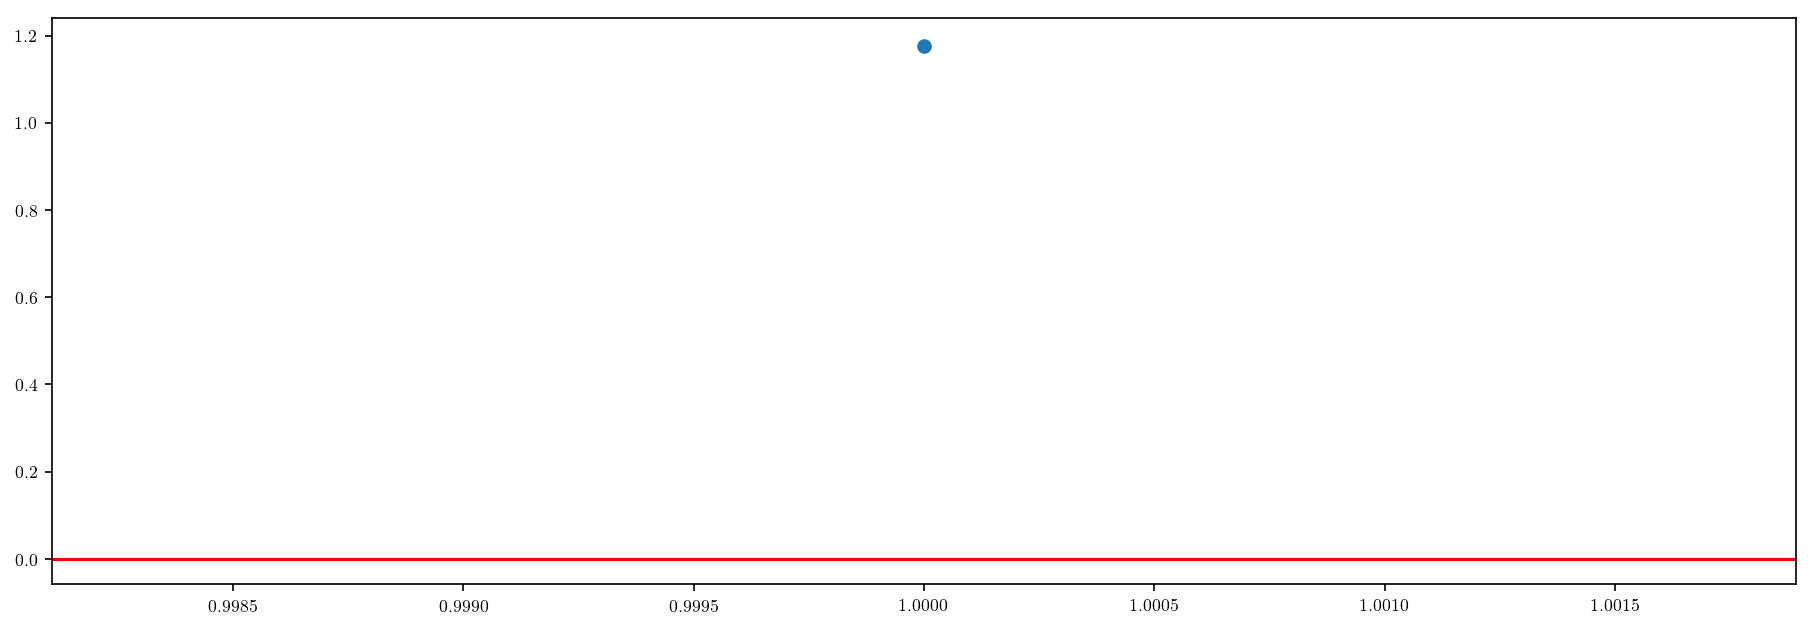

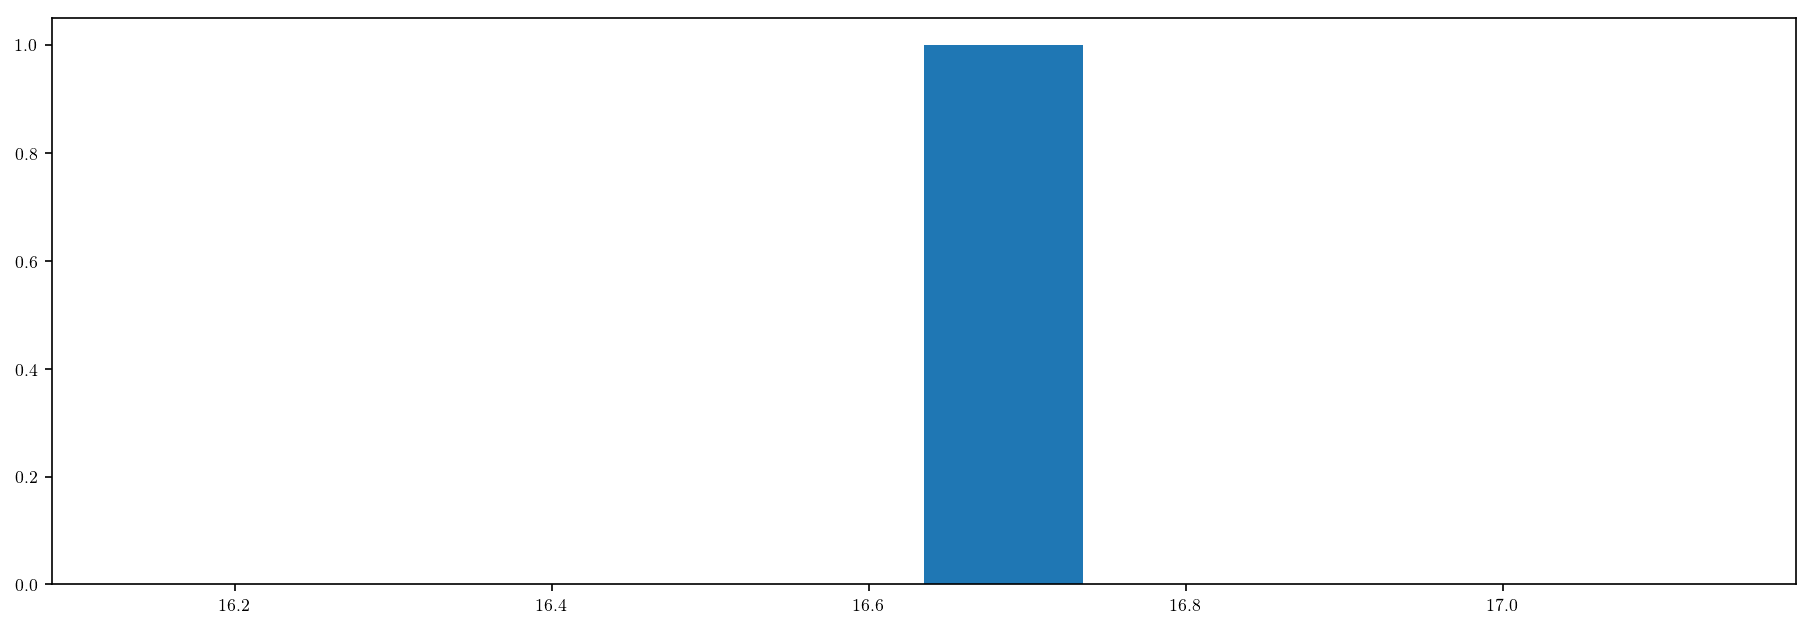

STD: 0.0
Mean: 1.176698578971303
KID8866102
True Period: 17.83367834
Estimated Period: 68.1651075494289
Estimated Period: 92.35983724369842
Estimated Period: 156.54997872656915
Estimated Period: 39.995208217308296
Estimated Period: 20.543958603644672
Estimated Period: 78.9537827219875
Estimated Period: 50.60102431788383
Estimated Period: 78.95766451072114
Estimated Period: 72.28037660982864
Estimated Period: 76.52394334444345
Estimated Period: 28.92295408958707
Estimated Period: 271.504933664497
Estimated Period: 514.4132486110652
Estimated Period: 21.598138561163083
Estimated Period: 19.780053995464236
Estimated Period: 183.74804652723384
Estimated Period: 19.69615457491441
Estimated Period: 171.20030911922433
Estimated Period: 106.21864055570883
Estimated Period: 90.70645675653296
Estimated Period: 17.999443671733115
Estimated Period: 365.25189321486243
Estimated Period: 99.72775483911967
Estimated Period: 19.900217565610895
[5.03314292e+01 7.45261589e+01 1.38716300e+02 2.21615299e+0

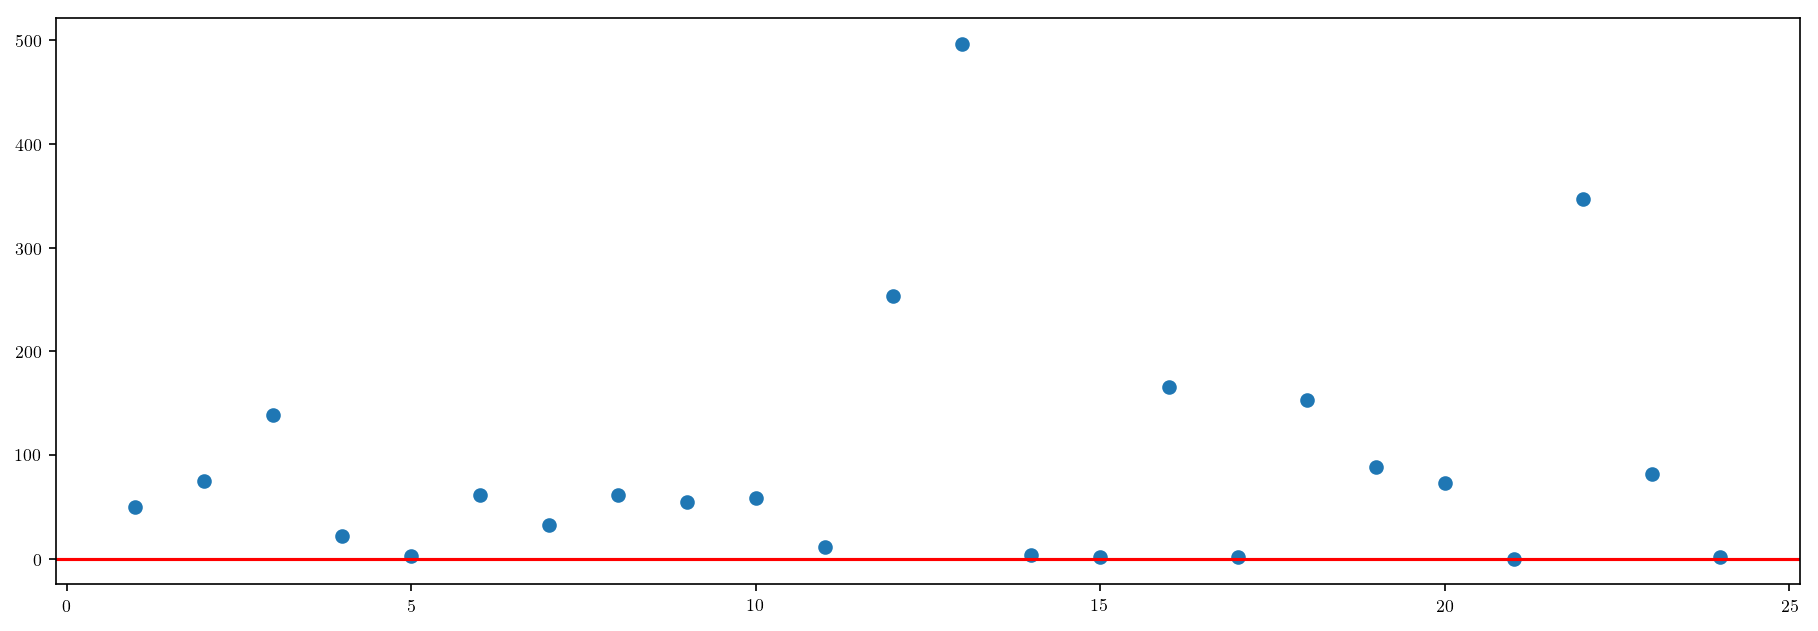

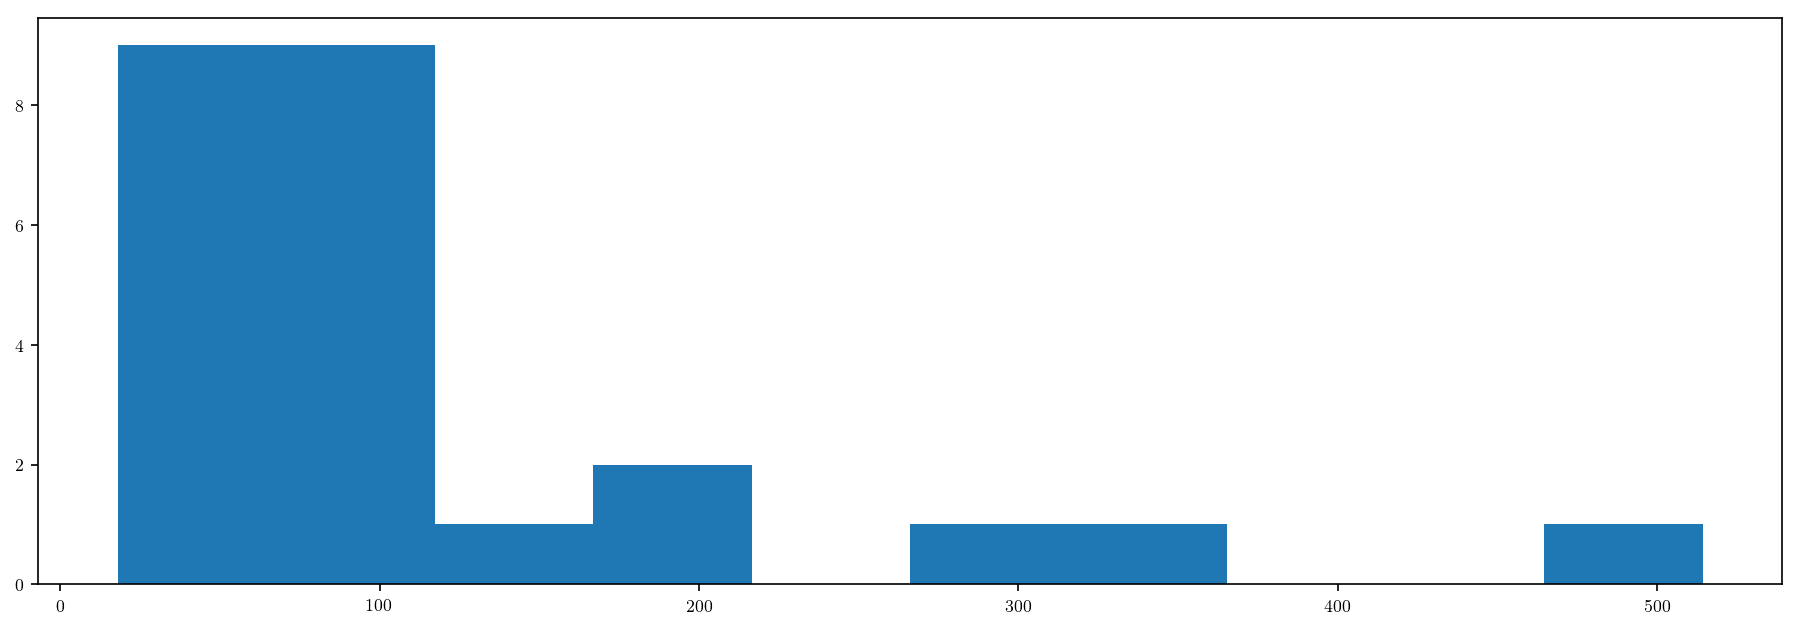

STD: 118.46795701001672
Mean: 93.23295197634296
KID12403119
True Period: 76.13622222
Estimated Period: 74.17834779641866
Estimated Period: 72.6882317427494
Estimated Period: 74.37203744553344
Estimated Period: 134.063851946431
[-1.95787442 -3.44799048 -1.76418477 57.92762973]
[1 2 3 4]


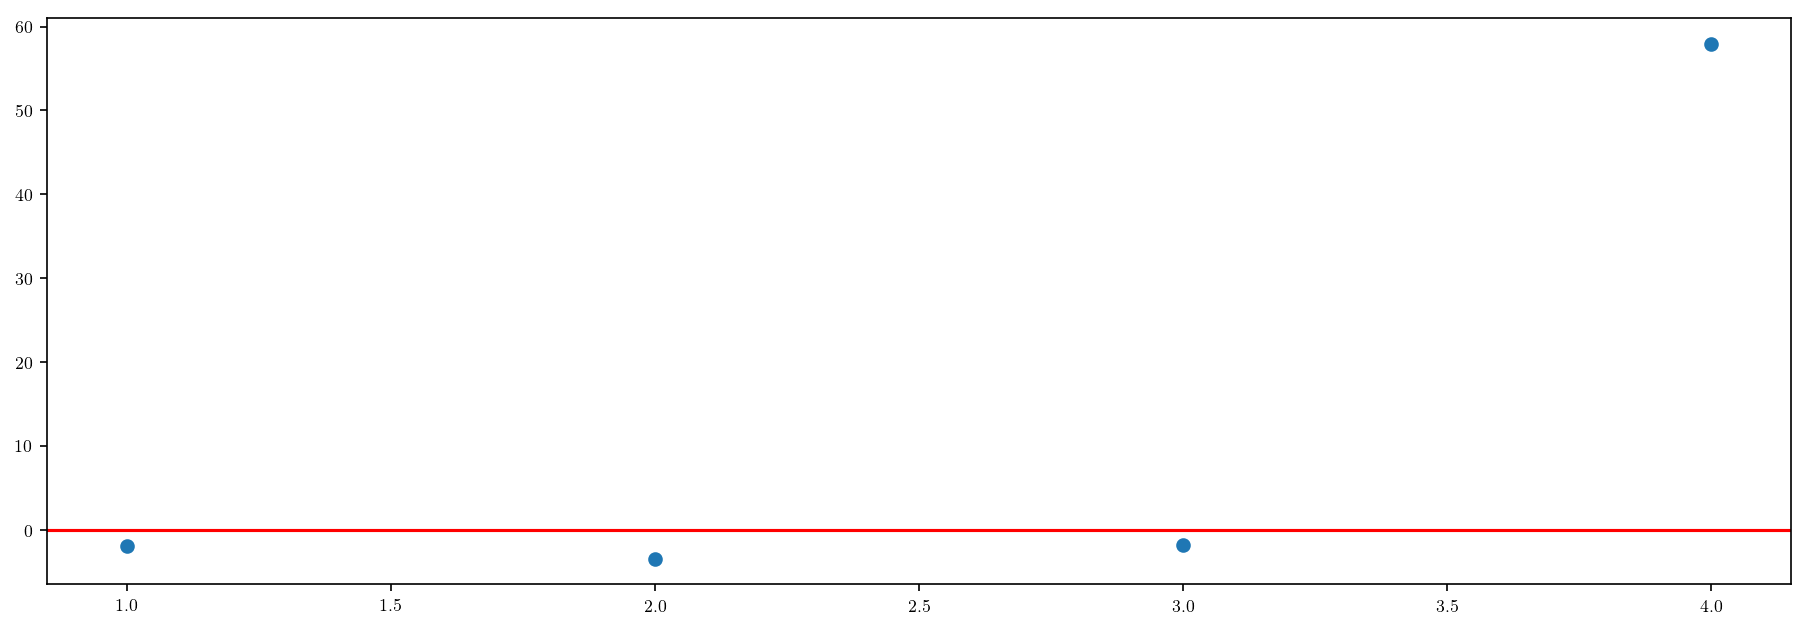

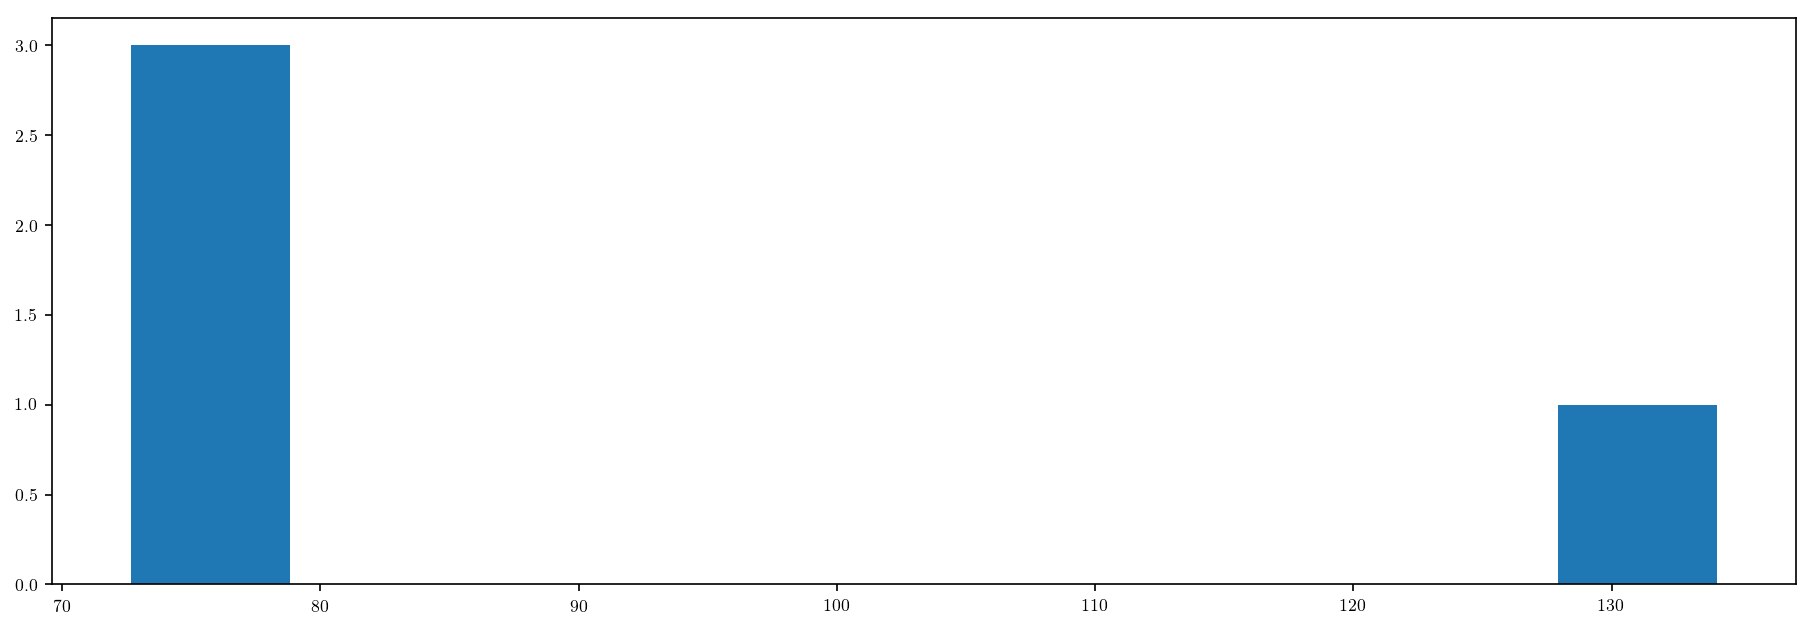

STD: 26.126430875020485
Mean: 12.689395012783127


In [163]:
path_resMCMC = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/results/MCMC_results/'

compareP = []
true_P = []

for target in targets:
    getmc = glob.glob(path_resMCMC+str(target.kepid)+"*[!_BAD].txt")
    num_trans = 0
    
    
    if len(getmc) != 0:
        print("KID"+str(target.kepid))
        print("True Period:", target.P)
        true_P.append(target.P)
        calcP = []
        for filename in getmc: 
            num_trans += 1
            data = {}
            for line in open(filename):
                if line.startswith("#"):
                    continue
                field_name, values = line.split(":")
                data[field_name] = values.split(" ")
            df = pd.DataFrame(data)
            est_p = df['Orbital Period (P, [days])'][1]
            calcP.append(float(est_p))
            print("Estimated Period:", est_p)
        
        xtrans = np.arange(1, num_trans+1, 1)
        residuals = np.array(calcP)-target.P
        print(residuals)
        print(xtrans)
        
        fig = plt.figure(figsize=(15,5))
        ax = fig.add_subplot(111)
        ax.axhline(y=0, c='r')
        ax.scatter(xtrans, residuals)
        plt.show()
        
        fig2 = plt.figure(figsize=(15,5))
        ax=fig2.add_subplot(111)
        ax.hist(calcP)
        plt.show()
        
        print("STD:", np.std(residuals))
        print("Mean:", np.mean(residuals))

In [116]:
len(compareP)

12

In [ ]:
print(
        